In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import KernelPCA
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from skmultilearn.model_selection import iterative_train_test_split
from sklearn import svm
from sklearn.decomposition import PCA
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from    tensorflow.keras import layers, optimizers, datasets
import  os
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL']='0'
pd.options.mode.use_inf_as_na = True


G:\Ana_Location\envs\tensorflow_1\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
G:\Ana_Location\envs\tensorflow_1\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
G:\Ana_Location\envs\tensorflow_1\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
fingerprint = pd.read_csv('fingerPrint.csv', keep_default_na=True, low_memory=False)
#转换为数字
fingerprint.iloc[:, 1:] = fingerprint.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

#丢弃Name这一行
fingerprint.drop(['Name'],axis=1 , inplace = True)

In [3]:
LR = 0.00007
Random_seed = 2
EPOCHS = 5000
BATCH_SIZE = 32
DROPRATE = 0.25
BAOCUNNAME  = 'Ext_test_2.h5'

In [4]:
fingerprint

,ExtFP1,ExtFP2,ExtFP3,ExtFP4,ExtFP5,ExtFP6,ExtFP7,ExtFP8,ExtFP9,ExtFP10,...,ExtFP1016,ExtFP1017,ExtFP1018,ExtFP1019,ExtFP1020,ExtFP1021,ExtFP1022,ExtFP1023,ExtFP1024,Response
0,1,0,1,1,0,0,1,1,1,0,...,1,1,0,0,0,0,0,0,0,4.05
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2.94
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.50
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.09
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7408,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2.20
7409,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.50
7410,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3.01
7411,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.45


In [5]:
#调整整体的分布，疑似不同
response = np.array(fingerprint.pop('Response'))

#暂时不考虑缩放
#scaler = StandardScaler()
# fit后可通过standardScaler查看均值和标准差
# standardScaler.mean_：查看均值
# standardScaler.scale_：查看标准差


#随机划分训练，测试，验证集合(6 : 2: 2)
X_train, X_test, Y_train, Y_test = train_test_split(fingerprint, response, test_size=0.2, random_state=233)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=233)


In [6]:


Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)
Y_val = Y_val.reshape(-1, 1)
# #将所有的Response按照大小归一化到
# from sklearn.preprocessing import MinMaxScaler
# y1 =  MinMaxScaler().fit(Y_train)
# Y_train = y1.transform(Y_train)
# Y_test = y1.transform(Y_test)
# Y_val = y1.transform(Y_val)

In [7]:
Y_val

array([[1.64],
       [3.42],
       [2.14],
       ...,
       [1.51],
       [2.36],
       [1.67]])

In [8]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_val = X_val.to_numpy()

In [9]:
np.random.seed(Random_seed)
np.random.shuffle(X_train)
np.random.seed(Random_seed)
np.random.shuffle(Y_train)


In [10]:
METRICS = [
    keras.metrics.MeanSquaredError(name='MSE'),
    keras.metrics.RootMeanSquaredError(name='RMSE'),
    keras.metrics.MeanAbsoluteError(name='MAE'),
    keras.metrics.MeanAbsolutePercentageError(name='MAPE'),
    keras.metrics.MeanSquaredLogarithmicError(name='MSLE'),
    keras.metrics.CosineSimilarity(name='CosSimilarity'),
    keras.metrics.LogCoshError(name='LCE'),
]


def make_model(metrics=METRICS, output_bias=None):
    model = keras.Sequential()
    model.add(keras.layers.Dense(256, input_shape=(X_train.shape[-1],), 
                      kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('sigmoid'))
    model.add(keras.layers.Dropout(rate=DROPRATE))
    model.add(keras.layers.Dense(64,kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('sigmoid'))
    model.add(keras.layers.Dropout(rate=DROPRATE))
    model.add(keras.layers.Dense(32,kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('sigmoid'))
    model.add(keras.layers.Dropout(rate=DROPRATE))
    model.add(keras.layers.Dense(1,kernel_initializer='he_uniform'))

    model.compile(
      optimizer=keras.optimizers.Adam(lr=LR),
      loss=keras.losses.MeanAbsoluteError(),
      metrics=metrics)

    return model

In [11]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0

In [12]:
checkpoint = keras.callbacks.ModelCheckpoint(BAOCUNNAME, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

In [13]:
baseline_history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val),
    callbacks=[checkpoint],
    epochs=EPOCHS)

Epoch 1/5000
139/139 [==============================] - ETA: 0s - loss: 1.8765 - MSE: 4.6662 - RMSE: 2.1601 - MAE: 1.8765 - MAPE: 69.9077 - MSLE: 0.6888 - CosSimilarity: 0.8277 - LCE: 1.2685
Epoch 00001: val_loss improved from inf to 1.85501, saving model to Ext_test_2.h5
139/139 [==============================] - 2s 16ms/step - loss: 1.8765 - MSE: 4.6662 - RMSE: 2.1601 - MAE: 1.8765 - MAPE: 69.9077 - MSLE: 0.6888 - CosSimilarity: 0.8277 - LCE: 1.2685 - val_loss: 1.8550 - val_MSE: 4.3006 - val_RMSE: 2.0738 - val_MAE: 1.8550 - val_MAPE: 68.5646 - val_MSLE: 0.5587 - val_CosSimilarity: 1.0000 - val_LCE: 1.2302
Epoch 2/5000
136/139 [============================>.] - ETA: 0s - loss: 1.7172 - MSE: 4.0428 - RMSE: 2.0107 - MAE: 1.7172 - MAPE: 63.3077 - MSLE: 0.5520 - CosSimilarity: 0.9187 - LCE: 1.1296
Epoch 00002: val_loss improved from 1.85501 to 1.58824, saving model to Ext_test_2.h5
139/139 [==============================] - 2s 15ms/step - loss: 1.7120 - MSE: 4.0205 - RMSE: 2.0051 - MAE: 1

Epoch 28/5000
138/139 [============================>.] - ETA: 0s - loss: 0.6457 - MSE: 0.7123 - RMSE: 0.8440 - MAE: 0.6457 - MAPE: 27.1787 - MSLE: 0.0548 - CosSimilarity: 1.0000 - LCE: 0.2719
Epoch 00028: val_loss did not improve from 0.51422
139/139 [==============================] - 2s 15ms/step - loss: 0.6459 - MSE: 0.7135 - RMSE: 0.8447 - MAE: 0.6459 - MAPE: 27.2068 - MSLE: 0.0548 - CosSimilarity: 1.0000 - LCE: 0.2722 - val_loss: 0.5151 - val_MSE: 0.4702 - val_RMSE: 0.6857 - val_MAE: 0.5151 - val_MAPE: 21.7287 - val_MSLE: 0.0360 - val_CosSimilarity: 1.0000 - val_LCE: 0.1903
Epoch 29/5000
139/139 [==============================] - ETA: 0s - loss: 0.6571 - MSE: 0.7366 - RMSE: 0.8582 - MAE: 0.6571 - MAPE: 27.5139 - MSLE: 0.0562 - CosSimilarity: 1.0000 - LCE: 0.2800
Epoch 00029: val_loss improved from 0.51422 to 0.51040, saving model to Ext_test_2.h5
139/139 [==============================] - 2s 14ms/step - loss: 0.6571 - MSE: 0.7366 - RMSE: 0.8582 - MAE: 0.6571 - MAPE: 27.5139 - MSLE:

Epoch 42/5000
138/139 [============================>.] - ETA: 0s - loss: 0.6233 - MSE: 0.6706 - RMSE: 0.8189 - MAE: 0.6233 - MAPE: 26.3190 - MSLE: 0.0515 - CosSimilarity: 1.0000 - LCE: 0.2575
Epoch 00042: val_loss did not improve from 0.50536
139/139 [==============================] - 2s 15ms/step - loss: 0.6247 - MSE: 0.6742 - RMSE: 0.8211 - MAE: 0.6247 - MAPE: 26.3527 - MSLE: 0.0517 - CosSimilarity: 1.0000 - LCE: 0.2585 - val_loss: 0.5057 - val_MSE: 0.4519 - val_RMSE: 0.6723 - val_MAE: 0.5057 - val_MAPE: 21.6958 - val_MSLE: 0.0350 - val_CosSimilarity: 1.0000 - val_LCE: 0.1842
Epoch 43/5000
139/139 [==============================] - ETA: 0s - loss: 0.6083 - MSE: 0.6363 - RMSE: 0.7977 - MAE: 0.6083 - MAPE: 25.5932 - MSLE: 0.0484 - CosSimilarity: 1.0000 - LCE: 0.2468
Epoch 00043: val_loss did not improve from 0.50536
139/139 [==============================] - 2s 15ms/step - loss: 0.6083 - MSE: 0.6363 - RMSE: 0.7977 - MAE: 0.6083 - MAPE: 25.5932 - MSLE: 0.0484 - CosSimilarity: 1.0000 - L

Epoch 56/5000
137/139 [============================>.] - ETA: 0s - loss: 0.5862 - MSE: 0.5951 - RMSE: 0.7714 - MAE: 0.5862 - MAPE: 24.7563 - MSLE: 0.0456 - CosSimilarity: 1.0000 - LCE: 0.2335
Epoch 00056: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.5857 - MSE: 0.5932 - RMSE: 0.7702 - MAE: 0.5857 - MAPE: 24.7377 - MSLE: 0.0455 - CosSimilarity: 1.0000 - LCE: 0.2330 - val_loss: 0.5112 - val_MSE: 0.4553 - val_RMSE: 0.6748 - val_MAE: 0.5112 - val_MAPE: 22.2753 - val_MSLE: 0.0358 - val_CosSimilarity: 1.0000 - val_LCE: 0.1866
Epoch 57/5000
137/139 [============================>.] - ETA: 0s - loss: 0.5864 - MSE: 0.5929 - RMSE: 0.7700 - MAE: 0.5864 - MAPE: 24.8179 - MSLE: 0.0455 - CosSimilarity: 1.0000 - LCE: 0.2333
Epoch 00057: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.5870 - MSE: 0.5932 - RMSE: 0.7702 - MAE: 0.5870 - MAPE: 24.8052 - MSLE: 0.0455 - CosSimilarity: 1.0000 - L

139/139 [==============================] - ETA: 0s - loss: 0.5742 - MSE: 0.5685 - RMSE: 0.7540 - MAE: 0.5742 - MAPE: 24.1009 - MSLE: 0.0426 - CosSimilarity: 1.0000 - LCE: 0.2243
Epoch 00070: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.5742 - MSE: 0.5685 - RMSE: 0.7540 - MAE: 0.5742 - MAPE: 24.1009 - MSLE: 0.0426 - CosSimilarity: 1.0000 - LCE: 0.2243 - val_loss: 0.5144 - val_MSE: 0.4610 - val_RMSE: 0.6790 - val_MAE: 0.5144 - val_MAPE: 21.8931 - val_MSLE: 0.0362 - val_CosSimilarity: 1.0000 - val_LCE: 0.1882
Epoch 71/5000
138/139 [============================>.] - ETA: 0s - loss: 0.5677 - MSE: 0.5587 - RMSE: 0.7475 - MAE: 0.5677 - MAPE: 23.7992 - MSLE: 0.0419 - CosSimilarity: 1.0000 - LCE: 0.2215
Epoch 00071: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.5683 - MSE: 0.5598 - RMSE: 0.7482 - MAE: 0.5683 - MAPE: 23.8387 - MSLE: 0.0420 - CosSimilarity: 1.0000 - LCE: 0.2218 - v

Epoch 84/5000
136/139 [============================>.] - ETA: 0s - loss: 0.5522 - MSE: 0.5369 - RMSE: 0.7328 - MAE: 0.5522 - MAPE: 23.1352 - MSLE: 0.0399 - CosSimilarity: 1.0000 - LCE: 0.2125
Epoch 00084: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.5526 - MSE: 0.5371 - RMSE: 0.7329 - MAE: 0.5526 - MAPE: 23.1752 - MSLE: 0.0400 - CosSimilarity: 1.0000 - LCE: 0.2127 - val_loss: 0.5171 - val_MSE: 0.4592 - val_RMSE: 0.6776 - val_MAE: 0.5171 - val_MAPE: 22.4924 - val_MSLE: 0.0362 - val_CosSimilarity: 1.0000 - val_LCE: 0.1881
Epoch 85/5000
137/139 [============================>.] - ETA: 0s - loss: 0.5547 - MSE: 0.5415 - RMSE: 0.7359 - MAE: 0.5547 - MAPE: 23.3542 - MSLE: 0.0408 - CosSimilarity: 1.0000 - LCE: 0.2140
Epoch 00085: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.5546 - MSE: 0.5412 - RMSE: 0.7357 - MAE: 0.5546 - MAPE: 23.3869 - MSLE: 0.0408 - CosSimilarity: 1.0000 - L

136/139 [============================>.] - ETA: 0s - loss: 0.5287 - MSE: 0.4993 - RMSE: 0.7066 - MAE: 0.5287 - MAPE: 22.1957 - MSLE: 0.0370 - CosSimilarity: 1.0000 - LCE: 0.1991
Epoch 00098: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.5280 - MSE: 0.4971 - RMSE: 0.7050 - MAE: 0.5280 - MAPE: 22.1907 - MSLE: 0.0369 - CosSimilarity: 1.0000 - LCE: 0.1985 - val_loss: 0.5154 - val_MSE: 0.4550 - val_RMSE: 0.6745 - val_MAE: 0.5154 - val_MAPE: 22.4165 - val_MSLE: 0.0360 - val_CosSimilarity: 1.0000 - val_LCE: 0.1866
Epoch 99/5000
134/139 [===========================>..] - ETA: 0s - loss: 0.5371 - MSE: 0.5165 - RMSE: 0.7187 - MAE: 0.5371 - MAPE: 22.4564 - MSLE: 0.0384 - CosSimilarity: 1.0000 - LCE: 0.2038
Epoch 00099: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.5377 - MSE: 0.5180 - RMSE: 0.7197 - MAE: 0.5377 - MAPE: 22.4996 - MSLE: 0.0386 - CosSimilarity: 1.0000 - LCE: 0.2044 - v

138/139 [============================>.] - ETA: 0s - loss: 0.5250 - MSE: 0.4967 - RMSE: 0.7048 - MAE: 0.5250 - MAPE: 21.8930 - MSLE: 0.0363 - CosSimilarity: 1.0000 - LCE: 0.1973
Epoch 00112: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.5264 - MSE: 0.4992 - RMSE: 0.7065 - MAE: 0.5264 - MAPE: 21.9042 - MSLE: 0.0365 - CosSimilarity: 1.0000 - LCE: 0.1981 - val_loss: 0.5160 - val_MSE: 0.4581 - val_RMSE: 0.6768 - val_MAE: 0.5160 - val_MAPE: 22.7083 - val_MSLE: 0.0363 - val_CosSimilarity: 1.0000 - val_LCE: 0.1878
Epoch 113/5000
135/139 [============================>.] - ETA: 0s - loss: 0.5211 - MSE: 0.4732 - RMSE: 0.6879 - MAE: 0.5211 - MAPE: 21.9620 - MSLE: 0.0353 - CosSimilarity: 1.0000 - LCE: 0.1914
Epoch 00113: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.5206 - MSE: 0.4720 - RMSE: 0.6870 - MAE: 0.5206 - MAPE: 21.9660 - MSLE: 0.0352 - CosSimilarity: 1.0000 - LCE: 0.1911 - 

138/139 [============================>.] - ETA: 0s - loss: 0.4999 - MSE: 0.4531 - RMSE: 0.6732 - MAE: 0.4999 - MAPE: 21.0214 - MSLE: 0.0331 - CosSimilarity: 1.0000 - LCE: 0.1820
Epoch 00126: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.5000 - MSE: 0.4528 - RMSE: 0.6729 - MAE: 0.5000 - MAPE: 21.0570 - MSLE: 0.0331 - CosSimilarity: 1.0000 - LCE: 0.1820 - val_loss: 0.5171 - val_MSE: 0.4584 - val_RMSE: 0.6771 - val_MAE: 0.5171 - val_MAPE: 22.4995 - val_MSLE: 0.0364 - val_CosSimilarity: 1.0000 - val_LCE: 0.1876
Epoch 127/5000
136/139 [============================>.] - ETA: 0s - loss: 0.5066 - MSE: 0.4648 - RMSE: 0.6817 - MAE: 0.5066 - MAPE: 21.4228 - MSLE: 0.0344 - CosSimilarity: 1.0000 - LCE: 0.1864
Epoch 00127: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.5058 - MSE: 0.4638 - RMSE: 0.6810 - MAE: 0.5058 - MAPE: 21.3461 - MSLE: 0.0342 - CosSimilarity: 1.0000 - LCE: 0.1860 - 

136/139 [============================>.] - ETA: 0s - loss: 0.5090 - MSE: 0.4659 - RMSE: 0.6826 - MAE: 0.5090 - MAPE: 21.3988 - MSLE: 0.0339 - CosSimilarity: 1.0000 - LCE: 0.1868
Epoch 00140: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.5085 - MSE: 0.4649 - RMSE: 0.6819 - MAE: 0.5085 - MAPE: 21.3538 - MSLE: 0.0339 - CosSimilarity: 1.0000 - LCE: 0.1865 - val_loss: 0.5181 - val_MSE: 0.4612 - val_RMSE: 0.6791 - val_MAE: 0.5181 - val_MAPE: 22.7674 - val_MSLE: 0.0367 - val_CosSimilarity: 1.0000 - val_LCE: 0.1888
Epoch 141/5000
137/139 [============================>.] - ETA: 0s - loss: 0.5011 - MSE: 0.4492 - RMSE: 0.6702 - MAE: 0.5011 - MAPE: 21.0483 - MSLE: 0.0331 - CosSimilarity: 1.0000 - LCE: 0.1813
Epoch 00141: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.5007 - MSE: 0.4485 - RMSE: 0.6697 - MAE: 0.5007 - MAPE: 20.9966 - MSLE: 0.0330 - CosSimilarity: 1.0000 - LCE: 0.1811 - 

137/139 [============================>.] - ETA: 0s - loss: 0.4976 - MSE: 0.4517 - RMSE: 0.6721 - MAE: 0.4976 - MAPE: 20.8900 - MSLE: 0.0330 - CosSimilarity: 1.0000 - LCE: 0.1808
Epoch 00154: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.4966 - MSE: 0.4507 - RMSE: 0.6714 - MAE: 0.4966 - MAPE: 20.8383 - MSLE: 0.0330 - CosSimilarity: 1.0000 - LCE: 0.1803 - val_loss: 0.5187 - val_MSE: 0.4680 - val_RMSE: 0.6841 - val_MAE: 0.5187 - val_MAPE: 22.2011 - val_MSLE: 0.0370 - val_CosSimilarity: 1.0000 - val_LCE: 0.1905
Epoch 155/5000
139/139 [==============================] - ETA: 0s - loss: 0.4991 - MSE: 0.4556 - RMSE: 0.6750 - MAE: 0.4991 - MAPE: 20.9318 - MSLE: 0.0333 - CosSimilarity: 1.0000 - LCE: 0.1822
Epoch 00155: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.4991 - MSE: 0.4556 - RMSE: 0.6750 - MAE: 0.4991 - MAPE: 20.9318 - MSLE: 0.0333 - CosSimilarity: 1.0000 - LCE: 0.1822 - 

137/139 [============================>.] - ETA: 0s - loss: 0.4821 - MSE: 0.4199 - RMSE: 0.6480 - MAE: 0.4821 - MAPE: 20.0257 - MSLE: 0.0303 - CosSimilarity: 1.0000 - LCE: 0.1706
Epoch 00168: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.4812 - MSE: 0.4179 - RMSE: 0.6464 - MAE: 0.4812 - MAPE: 20.0321 - MSLE: 0.0303 - CosSimilarity: 1.0000 - LCE: 0.1699 - val_loss: 0.5218 - val_MSE: 0.4700 - val_RMSE: 0.6855 - val_MAE: 0.5218 - val_MAPE: 22.6295 - val_MSLE: 0.0373 - val_CosSimilarity: 1.0000 - val_LCE: 0.1917
Epoch 169/5000
136/139 [============================>.] - ETA: 0s - loss: 0.4888 - MSE: 0.4397 - RMSE: 0.6631 - MAE: 0.4888 - MAPE: 20.4048 - MSLE: 0.0320 - CosSimilarity: 1.0000 - LCE: 0.1766
Epoch 00169: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.4895 - MSE: 0.4430 - RMSE: 0.6656 - MAE: 0.4895 - MAPE: 20.4024 - MSLE: 0.0321 - CosSimilarity: 1.0000 - LCE: 0.1773 - 

Epoch 182/5000
139/139 [==============================] - ETA: 0s - loss: 0.4802 - MSE: 0.4192 - RMSE: 0.6475 - MAE: 0.4802 - MAPE: 20.3094 - MSLE: 0.0308 - CosSimilarity: 1.0000 - LCE: 0.1701
Epoch 00182: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.4802 - MSE: 0.4192 - RMSE: 0.6475 - MAE: 0.4802 - MAPE: 20.3094 - MSLE: 0.0308 - CosSimilarity: 1.0000 - LCE: 0.1701 - val_loss: 0.5212 - val_MSE: 0.4688 - val_RMSE: 0.6847 - val_MAE: 0.5212 - val_MAPE: 22.4128 - val_MSLE: 0.0372 - val_CosSimilarity: 1.0000 - val_LCE: 0.1914
Epoch 183/5000
135/139 [============================>.] - ETA: 0s - loss: 0.4855 - MSE: 0.4291 - RMSE: 0.6551 - MAE: 0.4855 - MAPE: 20.3563 - MSLE: 0.0312 - CosSimilarity: 1.0000 - LCE: 0.1740- ETA: 0s - loss: 0.4801 - MSE: 0.4240 - RMSE: 0.6512 - MAE: 0.4801 - MAPE: 19.8306 - MSLE: 0.0304 - CosSimilarity: 1.0000 - LCE: 0
Epoch 00183: val_loss did not improve from 0.50527
139/139 [==============================

Epoch 196/5000
137/139 [============================>.] - ETA: 0s - loss: 0.4712 - MSE: 0.4071 - RMSE: 0.6381 - MAE: 0.4712 - MAPE: 19.7868 - MSLE: 0.0298 - CosSimilarity: 1.0000 - LCE: 0.1657
Epoch 00196: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.4706 - MSE: 0.4060 - RMSE: 0.6372 - MAE: 0.4706 - MAPE: 19.8572 - MSLE: 0.0299 - CosSimilarity: 1.0000 - LCE: 0.1654 - val_loss: 0.5195 - val_MSE: 0.4658 - val_RMSE: 0.6825 - val_MAE: 0.5195 - val_MAPE: 22.5707 - val_MSLE: 0.0369 - val_CosSimilarity: 1.0000 - val_LCE: 0.1903
Epoch 197/5000
139/139 [==============================] - ETA: 0s - loss: 0.4708 - MSE: 0.4065 - RMSE: 0.6376 - MAE: 0.4708 - MAPE: 19.7180 - MSLE: 0.0295 - CosSimilarity: 1.0000 - LCE: 0.1652
Epoch 00197: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.4708 - MSE: 0.4065 - RMSE: 0.6376 - MAE: 0.4708 - MAPE: 19.7180 - MSLE: 0.0295 - CosSimilarity: 1.0000 -

Epoch 210/5000
135/139 [============================>.] - ETA: 0s - loss: 0.4672 - MSE: 0.4006 - RMSE: 0.6329 - MAE: 0.4672 - MAPE: 19.5541 - MSLE: 0.0291 - CosSimilarity: 1.0000 - LCE: 0.1631
Epoch 00210: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.4660 - MSE: 0.3973 - RMSE: 0.6303 - MAE: 0.4660 - MAPE: 19.5488 - MSLE: 0.0290 - CosSimilarity: 1.0000 - LCE: 0.1621 - val_loss: 0.5155 - val_MSE: 0.4591 - val_RMSE: 0.6775 - val_MAE: 0.5155 - val_MAPE: 22.4707 - val_MSLE: 0.0364 - val_CosSimilarity: 1.0000 - val_LCE: 0.1877
Epoch 211/5000
139/139 [==============================] - ETA: 0s - loss: 0.4633 - MSE: 0.3967 - RMSE: 0.6298 - MAE: 0.4633 - MAPE: 19.4445 - MSLE: 0.0288 - CosSimilarity: 1.0000 - LCE: 0.1616
Epoch 00211: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.4633 - MSE: 0.3967 - RMSE: 0.6298 - MAE: 0.4633 - MAPE: 19.4445 - MSLE: 0.0288 - CosSimilarity: 1.0000 -

Epoch 224/5000
136/139 [============================>.] - ETA: 0s - loss: 0.4623 - MSE: 0.3926 - RMSE: 0.6266 - MAE: 0.4623 - MAPE: 19.3225 - MSLE: 0.0285 - CosSimilarity: 1.0000 - LCE: 0.1602
Epoch 00224: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.4606 - MSE: 0.3895 - RMSE: 0.6241 - MAE: 0.4606 - MAPE: 19.2810 - MSLE: 0.0283 - CosSimilarity: 1.0000 - LCE: 0.1591 - val_loss: 0.5170 - val_MSE: 0.4611 - val_RMSE: 0.6790 - val_MAE: 0.5170 - val_MAPE: 22.7535 - val_MSLE: 0.0366 - val_CosSimilarity: 1.0000 - val_LCE: 0.1886
Epoch 225/5000
138/139 [============================>.] - ETA: 0s - loss: 0.4591 - MSE: 0.3802 - RMSE: 0.6166 - MAE: 0.4591 - MAPE: 19.2090 - MSLE: 0.0278 - CosSimilarity: 1.0000 - LCE: 0.1565
Epoch 00225: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.4595 - MSE: 0.3803 - RMSE: 0.6166 - MAE: 0.4595 - MAPE: 19.2035 - MSLE: 0.0278 - CosSimilarity: 1.0000 -

Epoch 238/5000
138/139 [============================>.] - ETA: 0s - loss: 0.4546 - MSE: 0.3841 - RMSE: 0.6198 - MAE: 0.4546 - MAPE: 19.0023 - MSLE: 0.0276 - CosSimilarity: 1.0000 - LCE: 0.1567
Epoch 00238: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.4547 - MSE: 0.3835 - RMSE: 0.6193 - MAE: 0.4547 - MAPE: 19.0151 - MSLE: 0.0276 - CosSimilarity: 1.0000 - LCE: 0.1565 - val_loss: 0.5193 - val_MSE: 0.4666 - val_RMSE: 0.6831 - val_MAE: 0.5193 - val_MAPE: 22.5846 - val_MSLE: 0.0371 - val_CosSimilarity: 1.0000 - val_LCE: 0.1906
Epoch 239/5000
137/139 [============================>.] - ETA: 0s - loss: 0.4432 - MSE: 0.3620 - RMSE: 0.6017 - MAE: 0.4432 - MAPE: 18.5624 - MSLE: 0.0267 - CosSimilarity: 1.0000 - LCE: 0.1491
Epoch 00239: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.4453 - MSE: 0.3663 - RMSE: 0.6053 - MAE: 0.4453 - MAPE: 18.6162 - MSLE: 0.0269 - CosSimilarity: 1.0000 -

Epoch 252/5000
139/139 [==============================] - ETA: 0s - loss: 0.4510 - MSE: 0.3776 - RMSE: 0.6145 - MAE: 0.4510 - MAPE: 18.9070 - MSLE: 0.0275 - CosSimilarity: 1.0000 - LCE: 0.1542
Epoch 00252: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.4510 - MSE: 0.3776 - RMSE: 0.6145 - MAE: 0.4510 - MAPE: 18.9070 - MSLE: 0.0275 - CosSimilarity: 1.0000 - LCE: 0.1542 - val_loss: 0.5159 - val_MSE: 0.4654 - val_RMSE: 0.6822 - val_MAE: 0.5159 - val_MAPE: 22.2647 - val_MSLE: 0.0369 - val_CosSimilarity: 1.0000 - val_LCE: 0.1896
Epoch 253/5000
137/139 [============================>.] - ETA: 0s - loss: 0.4457 - MSE: 0.3638 - RMSE: 0.6032 - MAE: 0.4457 - MAPE: 18.8149 - MSLE: 0.0268 - CosSimilarity: 1.0000 - LCE: 0.1503
Epoch 00253: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.4461 - MSE: 0.3648 - RMSE: 0.6040 - MAE: 0.4461 - MAPE: 18.8141 - MSLE: 0.0269 - CosSimilarity: 1.0000 -

Epoch 266/5000
139/139 [==============================] - ETA: 0s - loss: 0.4391 - MSE: 0.3567 - RMSE: 0.5973 - MAE: 0.4391 - MAPE: 18.5311 - MSLE: 0.0263 - CosSimilarity: 1.0000 - LCE: 0.1476
Epoch 00266: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.4391 - MSE: 0.3567 - RMSE: 0.5973 - MAE: 0.4391 - MAPE: 18.5311 - MSLE: 0.0263 - CosSimilarity: 1.0000 - LCE: 0.1476 - val_loss: 0.5192 - val_MSE: 0.4672 - val_RMSE: 0.6836 - val_MAE: 0.5192 - val_MAPE: 22.6371 - val_MSLE: 0.0369 - val_CosSimilarity: 1.0000 - val_LCE: 0.1907
Epoch 267/5000
136/139 [============================>.] - ETA: 0s - loss: 0.4329 - MSE: 0.3496 - RMSE: 0.5913 - MAE: 0.4329 - MAPE: 18.1771 - MSLE: 0.0254 - CosSimilarity: 1.0000 - LCE: 0.1444
Epoch 00267: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.4333 - MSE: 0.3494 - RMSE: 0.5911 - MAE: 0.4333 - MAPE: 18.2219 - MSLE: 0.0255 - CosSimilarity: 1.0000 -

Epoch 280/5000
135/139 [============================>.] - ETA: 0s - loss: 0.4351 - MSE: 0.3460 - RMSE: 0.5882 - MAE: 0.4351 - MAPE: 18.2715 - MSLE: 0.0254 - CosSimilarity: 1.0000 - LCE: 0.1441
Epoch 00280: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.4353 - MSE: 0.3461 - RMSE: 0.5883 - MAE: 0.4353 - MAPE: 18.3337 - MSLE: 0.0255 - CosSimilarity: 1.0000 - LCE: 0.1441 - val_loss: 0.5161 - val_MSE: 0.4663 - val_RMSE: 0.6829 - val_MAE: 0.5161 - val_MAPE: 22.5116 - val_MSLE: 0.0371 - val_CosSimilarity: 1.0000 - val_LCE: 0.1899
Epoch 281/5000
135/139 [============================>.] - ETA: 0s - loss: 0.4253 - MSE: 0.3299 - RMSE: 0.5743 - MAE: 0.4253 - MAPE: 17.9053 - MSLE: 0.0244 - CosSimilarity: 1.0000 - LCE: 0.1383
Epoch 00281: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 12ms/step - loss: 0.4269 - MSE: 0.3333 - RMSE: 0.5773 - MAE: 0.4269 - MAPE: 17.9106 - MSLE: 0.0246 - CosSimilarity: 1.0000 -

Epoch 294/5000
137/139 [============================>.] - ETA: 0s - loss: 0.4346 - MSE: 0.3467 - RMSE: 0.5888 - MAE: 0.4346 - MAPE: 18.1023 - MSLE: 0.0251 - CosSimilarity: 1.0000 - LCE: 0.1438
Epoch 00294: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.4347 - MSE: 0.3471 - RMSE: 0.5891 - MAE: 0.4347 - MAPE: 18.1391 - MSLE: 0.0252 - CosSimilarity: 1.0000 - LCE: 0.1439 - val_loss: 0.5192 - val_MSE: 0.4710 - val_RMSE: 0.6863 - val_MAE: 0.5192 - val_MAPE: 22.4496 - val_MSLE: 0.0374 - val_CosSimilarity: 1.0000 - val_LCE: 0.1916
Epoch 295/5000
139/139 [==============================] - ETA: 0s - loss: 0.4339 - MSE: 0.3431 - RMSE: 0.5857 - MAE: 0.4339 - MAPE: 18.2242 - MSLE: 0.0253 - CosSimilarity: 1.0000 - LCE: 0.1436
Epoch 00295: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.4339 - MSE: 0.3431 - RMSE: 0.5857 - MAE: 0.4339 - MAPE: 18.2242 - MSLE: 0.0253 - CosSimilarity: 1.0000 -

Epoch 308/5000
135/139 [============================>.] - ETA: 0s - loss: 0.4112 - MSE: 0.3143 - RMSE: 0.5606 - MAE: 0.4112 - MAPE: 17.2410 - MSLE: 0.0229 - CosSimilarity: 1.0000 - LCE: 0.1317
Epoch 00308: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.4103 - MSE: 0.3134 - RMSE: 0.5598 - MAE: 0.4103 - MAPE: 17.2069 - MSLE: 0.0229 - CosSimilarity: 1.0000 - LCE: 0.1313 - val_loss: 0.5158 - val_MSE: 0.4703 - val_RMSE: 0.6858 - val_MAE: 0.5158 - val_MAPE: 21.9840 - val_MSLE: 0.0372 - val_CosSimilarity: 1.0000 - val_LCE: 0.1910
Epoch 309/5000
135/139 [============================>.] - ETA: 0s - loss: 0.4245 - MSE: 0.3326 - RMSE: 0.5768 - MAE: 0.4245 - MAPE: 17.8009 - MSLE: 0.0243 - CosSimilarity: 1.0000 - LCE: 0.1384
Epoch 00309: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.4240 - MSE: 0.3318 - RMSE: 0.5760 - MAE: 0.4240 - MAPE: 17.7177 - MSLE: 0.0242 - CosSimilarity: 1.0000 -

Epoch 322/5000
136/139 [============================>.] - ETA: 0s - loss: 0.4171 - MSE: 0.3231 - RMSE: 0.5684 - MAE: 0.4171 - MAPE: 17.4629 - MSLE: 0.0235 - CosSimilarity: 1.0000 - LCE: 0.1347
Epoch 00322: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.4170 - MSE: 0.3228 - RMSE: 0.5682 - MAE: 0.4170 - MAPE: 17.4806 - MSLE: 0.0235 - CosSimilarity: 1.0000 - LCE: 0.1346 - val_loss: 0.5168 - val_MSE: 0.4686 - val_RMSE: 0.6846 - val_MAE: 0.5168 - val_MAPE: 22.3391 - val_MSLE: 0.0371 - val_CosSimilarity: 1.0000 - val_LCE: 0.1907
Epoch 323/5000
138/139 [============================>.] - ETA: 0s - loss: 0.4154 - MSE: 0.3184 - RMSE: 0.5642 - MAE: 0.4154 - MAPE: 17.4910 - MSLE: 0.0234 - CosSimilarity: 1.0000 - LCE: 0.1331
Epoch 00323: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.4155 - MSE: 0.3182 - RMSE: 0.5641 - MAE: 0.4155 - MAPE: 17.5305 - MSLE: 0.0235 - CosSimilarity: 1.0000 -

Epoch 336/5000
137/139 [============================>.] - ETA: 0s - loss: 0.4087 - MSE: 0.3087 - RMSE: 0.5556 - MAE: 0.4087 - MAPE: 17.2626 - MSLE: 0.0229 - CosSimilarity: 1.0000 - LCE: 0.1296
Epoch 00336: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.4088 - MSE: 0.3092 - RMSE: 0.5560 - MAE: 0.4088 - MAPE: 17.2448 - MSLE: 0.0229 - CosSimilarity: 1.0000 - LCE: 0.1298 - val_loss: 0.5141 - val_MSE: 0.4669 - val_RMSE: 0.6833 - val_MAE: 0.5141 - val_MAPE: 22.4323 - val_MSLE: 0.0369 - val_CosSimilarity: 1.0000 - val_LCE: 0.1896
Epoch 337/5000
135/139 [============================>.] - ETA: 0s - loss: 0.4083 - MSE: 0.3148 - RMSE: 0.5611 - MAE: 0.4083 - MAPE: 17.2568 - MSLE: 0.0232 - CosSimilarity: 1.0000 - LCE: 0.1310
Epoch 00337: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.4088 - MSE: 0.3142 - RMSE: 0.5605 - MAE: 0.4088 - MAPE: 17.2317 - MSLE: 0.0231 - CosSimilarity: 1.0000 -

Epoch 350/5000
135/139 [============================>.] - ETA: 0s - loss: 0.4006 - MSE: 0.2988 - RMSE: 0.5466 - MAE: 0.4006 - MAPE: 16.7719 - MSLE: 0.0217 - CosSimilarity: 1.0000 - LCE: 0.1257- ETA: 1s - loss: 0.4040 - MSE: 0.2996 - RMSE: 0.5474 - MAE: 0.4040 - MAPE: 16.7435 - MSLE: 0.0216 - CosSimilarity: 1.
Epoch 00350: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.4019 - MSE: 0.2994 - RMSE: 0.5472 - MAE: 0.4019 - MAPE: 16.8503 - MSLE: 0.0218 - CosSimilarity: 1.0000 - LCE: 0.1260 - val_loss: 0.5143 - val_MSE: 0.4667 - val_RMSE: 0.6831 - val_MAE: 0.5143 - val_MAPE: 22.4433 - val_MSLE: 0.0370 - val_CosSimilarity: 1.0000 - val_LCE: 0.1898
Epoch 351/5000
138/139 [============================>.] - ETA: 0s - loss: 0.4008 - MSE: 0.3025 - RMSE: 0.5500 - MAE: 0.4008 - MAPE: 16.8619 - MSLE: 0.0220 - CosSimilarity: 1.0000 - LCE: 0.1266
Epoch 00351: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/s

Epoch 364/5000
138/139 [============================>.] - ETA: 0s - loss: 0.3969 - MSE: 0.2962 - RMSE: 0.5442 - MAE: 0.3969 - MAPE: 16.6465 - MSLE: 0.0216 - CosSimilarity: 1.0000 - LCE: 0.1242
Epoch 00364: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.3964 - MSE: 0.2954 - RMSE: 0.5435 - MAE: 0.3964 - MAPE: 16.6244 - MSLE: 0.0215 - CosSimilarity: 1.0000 - LCE: 0.1239 - val_loss: 0.5170 - val_MSE: 0.4737 - val_RMSE: 0.6882 - val_MAE: 0.5170 - val_MAPE: 21.8625 - val_MSLE: 0.0373 - val_CosSimilarity: 1.0000 - val_LCE: 0.1920
Epoch 365/5000
139/139 [==============================] - ETA: 0s - loss: 0.4023 - MSE: 0.3013 - RMSE: 0.5489 - MAE: 0.4023 - MAPE: 17.0462 - MSLE: 0.0223 - CosSimilarity: 1.0000 - LCE: 0.1269
Epoch 00365: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.4023 - MSE: 0.3013 - RMSE: 0.5489 - MAE: 0.4023 - MAPE: 17.0462 - MSLE: 0.0223 - CosSimilarity: 1.0000 -

Epoch 378/5000
137/139 [============================>.] - ETA: 0s - loss: 0.4000 - MSE: 0.2925 - RMSE: 0.5408 - MAE: 0.4000 - MAPE: 16.9299 - MSLE: 0.0217 - CosSimilarity: 1.0000 - LCE: 0.1239
Epoch 00378: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.4003 - MSE: 0.2930 - RMSE: 0.5413 - MAE: 0.4003 - MAPE: 16.9392 - MSLE: 0.0217 - CosSimilarity: 1.0000 - LCE: 0.1241 - val_loss: 0.5117 - val_MSE: 0.4635 - val_RMSE: 0.6808 - val_MAE: 0.5117 - val_MAPE: 22.1111 - val_MSLE: 0.0366 - val_CosSimilarity: 1.0000 - val_LCE: 0.1885
Epoch 379/5000
138/139 [============================>.] - ETA: 0s - loss: 0.3944 - MSE: 0.2928 - RMSE: 0.5411 - MAE: 0.3944 - MAPE: 16.7134 - MSLE: 0.0217 - CosSimilarity: 1.0000 - LCE: 0.1227
Epoch 00379: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.3943 - MSE: 0.2922 - RMSE: 0.5405 - MAE: 0.3943 - MAPE: 16.7238 - MSLE: 0.0217 - CosSimilarity: 1.0000 -

Epoch 392/5000
139/139 [==============================] - ETA: 0s - loss: 0.3920 - MSE: 0.2840 - RMSE: 0.5330 - MAE: 0.3920 - MAPE: 16.5931 - MSLE: 0.0212 - CosSimilarity: 1.0000 - LCE: 0.1205
Epoch 00392: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.3920 - MSE: 0.2840 - RMSE: 0.5330 - MAE: 0.3920 - MAPE: 16.5931 - MSLE: 0.0212 - CosSimilarity: 1.0000 - LCE: 0.1205 - val_loss: 0.5100 - val_MSE: 0.4623 - val_RMSE: 0.6799 - val_MAE: 0.5100 - val_MAPE: 22.1451 - val_MSLE: 0.0365 - val_CosSimilarity: 1.0000 - val_LCE: 0.1877
Epoch 393/5000
137/139 [============================>.] - ETA: 0s - loss: 0.3940 - MSE: 0.2886 - RMSE: 0.5372 - MAE: 0.3940 - MAPE: 16.6147 - MSLE: 0.0212 - CosSimilarity: 1.0000 - LCE: 0.1223
Epoch 00393: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 15ms/step - loss: 0.3938 - MSE: 0.2879 - RMSE: 0.5366 - MAE: 0.3938 - MAPE: 16.5937 - MSLE: 0.0212 - CosSimilarity: 1.0000 -

Epoch 406/5000
135/139 [============================>.] - ETA: 0s - loss: 0.3874 - MSE: 0.2778 - RMSE: 0.5271 - MAE: 0.3874 - MAPE: 16.4183 - MSLE: 0.0206 - CosSimilarity: 1.0000 - LCE: 0.1183
Epoch 00406: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 13ms/step - loss: 0.3885 - MSE: 0.2807 - RMSE: 0.5298 - MAE: 0.3885 - MAPE: 16.4587 - MSLE: 0.0208 - CosSimilarity: 1.0000 - LCE: 0.1192 - val_loss: 0.5089 - val_MSE: 0.4617 - val_RMSE: 0.6795 - val_MAE: 0.5089 - val_MAPE: 22.1367 - val_MSLE: 0.0363 - val_CosSimilarity: 1.0000 - val_LCE: 0.1873
Epoch 407/5000
137/139 [============================>.] - ETA: 0s - loss: 0.3856 - MSE: 0.2764 - RMSE: 0.5257 - MAE: 0.3856 - MAPE: 16.3105 - MSLE: 0.0205 - CosSimilarity: 1.0000 - LCE: 0.1175
Epoch 00407: val_loss did not improve from 0.50527
139/139 [==============================] - 2s 14ms/step - loss: 0.3863 - MSE: 0.2765 - RMSE: 0.5259 - MAE: 0.3863 - MAPE: 16.3671 - MSLE: 0.0206 - CosSimilarity: 1.0000 -

Epoch 420/5000
136/139 [============================>.] - ETA: 0s - loss: 0.3748 - MSE: 0.2656 - RMSE: 0.5154 - MAE: 0.3748 - MAPE: 15.9353 - MSLE: 0.0198 - CosSimilarity: 1.0000 - LCE: 0.1130
Epoch 00420: val_loss did not improve from 0.50457
139/139 [==============================] - 2s 14ms/step - loss: 0.3754 - MSE: 0.2665 - RMSE: 0.5162 - MAE: 0.3754 - MAPE: 15.9255 - MSLE: 0.0198 - CosSimilarity: 1.0000 - LCE: 0.1134 - val_loss: 0.5068 - val_MSE: 0.4606 - val_RMSE: 0.6786 - val_MAE: 0.5068 - val_MAPE: 21.7698 - val_MSLE: 0.0362 - val_CosSimilarity: 1.0000 - val_LCE: 0.1869
Epoch 421/5000
135/139 [============================>.] - ETA: 0s - loss: 0.3871 - MSE: 0.2809 - RMSE: 0.5300 - MAE: 0.3871 - MAPE: 16.2135 - MSLE: 0.0205 - CosSimilarity: 1.0000 - LCE: 0.1185
Epoch 00421: val_loss did not improve from 0.50457
139/139 [==============================] - 2s 13ms/step - loss: 0.3882 - MSE: 0.2821 - RMSE: 0.5311 - MAE: 0.3882 - MAPE: 16.2138 - MSLE: 0.0205 - CosSimilarity: 1.0000 -

Epoch 434/5000
139/139 [==============================] - ETA: 0s - loss: 0.3774 - MSE: 0.2636 - RMSE: 0.5134 - MAE: 0.3774 - MAPE: 16.0017 - MSLE: 0.0196 - CosSimilarity: 1.0000 - LCE: 0.1127
Epoch 00434: val_loss did not improve from 0.50457
139/139 [==============================] - 2s 14ms/step - loss: 0.3774 - MSE: 0.2636 - RMSE: 0.5134 - MAE: 0.3774 - MAPE: 16.0017 - MSLE: 0.0196 - CosSimilarity: 1.0000 - LCE: 0.1127 - val_loss: 0.5085 - val_MSE: 0.4622 - val_RMSE: 0.6798 - val_MAE: 0.5085 - val_MAPE: 21.8840 - val_MSLE: 0.0363 - val_CosSimilarity: 1.0000 - val_LCE: 0.1875
Epoch 435/5000
136/139 [============================>.] - ETA: 0s - loss: 0.3858 - MSE: 0.2765 - RMSE: 0.5258 - MAE: 0.3858 - MAPE: 16.1529 - MSLE: 0.0201 - CosSimilarity: 1.0000 - LCE: 0.1174
Epoch 00435: val_loss did not improve from 0.50457
139/139 [==============================] - 2s 15ms/step - loss: 0.3856 - MSE: 0.2767 - RMSE: 0.5261 - MAE: 0.3856 - MAPE: 16.1529 - MSLE: 0.0201 - CosSimilarity: 1.0000 -

Epoch 448/5000
136/139 [============================>.] - ETA: 0s - loss: 0.3754 - MSE: 0.2717 - RMSE: 0.5213 - MAE: 0.3754 - MAPE: 15.9134 - MSLE: 0.0200 - CosSimilarity: 1.0000 - LCE: 0.1138
Epoch 00448: val_loss did not improve from 0.50457
139/139 [==============================] - 2s 14ms/step - loss: 0.3753 - MSE: 0.2714 - RMSE: 0.5209 - MAE: 0.3753 - MAPE: 15.8648 - MSLE: 0.0199 - CosSimilarity: 1.0000 - LCE: 0.1137 - val_loss: 0.5137 - val_MSE: 0.4695 - val_RMSE: 0.6852 - val_MAE: 0.5137 - val_MAPE: 22.5403 - val_MSLE: 0.0367 - val_CosSimilarity: 1.0000 - val_LCE: 0.1902
Epoch 449/5000
136/139 [============================>.] - ETA: 0s - loss: 0.3768 - MSE: 0.2605 - RMSE: 0.5104 - MAE: 0.3768 - MAPE: 15.9516 - MSLE: 0.0195 - CosSimilarity: 1.0000 - LCE: 0.1116
Epoch 00449: val_loss did not improve from 0.50457
139/139 [==============================] - 2s 15ms/step - loss: 0.3777 - MSE: 0.2612 - RMSE: 0.5111 - MAE: 0.3777 - MAPE: 16.0126 - MSLE: 0.0196 - CosSimilarity: 1.0000 -

Epoch 462/5000
137/139 [============================>.] - ETA: 0s - loss: 0.3756 - MSE: 0.2642 - RMSE: 0.5140 - MAE: 0.3756 - MAPE: 15.8550 - MSLE: 0.0194 - CosSimilarity: 1.0000 - LCE: 0.1122
Epoch 00462: val_loss did not improve from 0.50457
139/139 [==============================] - 2s 15ms/step - loss: 0.3752 - MSE: 0.2635 - RMSE: 0.5133 - MAE: 0.3752 - MAPE: 15.8420 - MSLE: 0.0194 - CosSimilarity: 1.0000 - LCE: 0.1119 - val_loss: 0.5108 - val_MSE: 0.4663 - val_RMSE: 0.6828 - val_MAE: 0.5108 - val_MAPE: 22.4312 - val_MSLE: 0.0365 - val_CosSimilarity: 1.0000 - val_LCE: 0.1889
Epoch 463/5000
136/139 [============================>.] - ETA: 0s - loss: 0.3712 - MSE: 0.2562 - RMSE: 0.5062 - MAE: 0.3712 - MAPE: 15.6161 - MSLE: 0.0189 - CosSimilarity: 1.0000 - LCE: 0.1095
Epoch 00463: val_loss did not improve from 0.50457
139/139 [==============================] - 2s 14ms/step - loss: 0.3713 - MSE: 0.2570 - RMSE: 0.5069 - MAE: 0.3713 - MAPE: 15.6486 - MSLE: 0.0190 - CosSimilarity: 1.0000 -

Epoch 476/5000
136/139 [============================>.] - ETA: 0s - loss: 0.3627 - MSE: 0.2477 - RMSE: 0.4977 - MAE: 0.3627 - MAPE: 15.3066 - MSLE: 0.0182 - CosSimilarity: 1.0000 - LCE: 0.1063
Epoch 00476: val_loss improved from 0.50457 to 0.50456, saving model to Ext_test_2.h5
139/139 [==============================] - 2s 14ms/step - loss: 0.3621 - MSE: 0.2470 - RMSE: 0.4970 - MAE: 0.3621 - MAPE: 15.3232 - MSLE: 0.0182 - CosSimilarity: 1.0000 - LCE: 0.1060 - val_loss: 0.5046 - val_MSE: 0.4620 - val_RMSE: 0.6797 - val_MAE: 0.5046 - val_MAPE: 21.7372 - val_MSLE: 0.0363 - val_CosSimilarity: 1.0000 - val_LCE: 0.1868
Epoch 477/5000
136/139 [============================>.] - ETA: 0s - loss: 0.3661 - MSE: 0.2475 - RMSE: 0.4975 - MAE: 0.3661 - MAPE: 15.4697 - MSLE: 0.0183 - CosSimilarity: 1.0000 - LCE: 0.1065
Epoch 00477: val_loss did not improve from 0.50456
139/139 [==============================] - 2s 15ms/step - loss: 0.3647 - MSE: 0.2455 - RMSE: 0.4955 - MAE: 0.3647 - MAPE: 15.4030 - MSL

Epoch 490/5000
135/139 [============================>.] - ETA: 0s - loss: 0.3646 - MSE: 0.2497 - RMSE: 0.4997 - MAE: 0.3646 - MAPE: 15.5885 - MSLE: 0.0186 - CosSimilarity: 1.0000 - LCE: 0.1067- ETA: 0s - loss: 0.3498 - MSE: 0.2352 - RMSE: 0.4849 - MAE: 0.3498 - MAPE: 14.5283 - MSLE: 0.0171 - CosSimilarity: 1.0
Epoch 00490: val_loss did not improve from 0.50456
139/139 [==============================] - 2s 15ms/step - loss: 0.3651 - MSE: 0.2498 - RMSE: 0.4998 - MAE: 0.3651 - MAPE: 15.6137 - MSLE: 0.0187 - CosSimilarity: 1.0000 - LCE: 0.1069 - val_loss: 0.5081 - val_MSE: 0.4689 - val_RMSE: 0.6848 - val_MAE: 0.5081 - val_MAPE: 22.3260 - val_MSLE: 0.0367 - val_CosSimilarity: 1.0000 - val_LCE: 0.1890
Epoch 491/5000
135/139 [============================>.] - ETA: 0s - loss: 0.3631 - MSE: 0.2479 - RMSE: 0.4979 - MAE: 0.3631 - MAPE: 15.4306 - MSLE: 0.0185 - CosSimilarity: 1.0000 - LCE: 0.1062
Epoch 00491: val_loss did not improve from 0.50456
139/139 [==============================] - 2s 15ms/

Epoch 504/5000
136/139 [============================>.] - ETA: 0s - loss: 0.3654 - MSE: 0.2495 - RMSE: 0.4995 - MAE: 0.3654 - MAPE: 15.4295 - MSLE: 0.0185 - CosSimilarity: 1.0000 - LCE: 0.1075
Epoch 00504: val_loss did not improve from 0.50456
139/139 [==============================] - 2s 14ms/step - loss: 0.3669 - MSE: 0.2519 - RMSE: 0.5019 - MAE: 0.3669 - MAPE: 15.4634 - MSLE: 0.0186 - CosSimilarity: 1.0000 - LCE: 0.1084 - val_loss: 0.5070 - val_MSE: 0.4655 - val_RMSE: 0.6822 - val_MAE: 0.5070 - val_MAPE: 21.8278 - val_MSLE: 0.0364 - val_CosSimilarity: 1.0000 - val_LCE: 0.1880
Epoch 505/5000
139/139 [==============================] - ETA: 0s - loss: 0.3619 - MSE: 0.2441 - RMSE: 0.4941 - MAE: 0.3619 - MAPE: 15.3236 - MSLE: 0.0181 - CosSimilarity: 1.0000 - LCE: 0.1050
Epoch 00505: val_loss did not improve from 0.50456
139/139 [==============================] - 2s 14ms/step - loss: 0.3619 - MSE: 0.2441 - RMSE: 0.4941 - MAE: 0.3619 - MAPE: 15.3236 - MSLE: 0.0181 - CosSimilarity: 1.0000 -

Epoch 518/5000
137/139 [============================>.] - ETA: 0s - loss: 0.3589 - MSE: 0.2411 - RMSE: 0.4910 - MAE: 0.3589 - MAPE: 15.1477 - MSLE: 0.0177 - CosSimilarity: 1.0000 - LCE: 0.1035
Epoch 00518: val_loss did not improve from 0.50018
139/139 [==============================] - 2s 14ms/step - loss: 0.3581 - MSE: 0.2402 - RMSE: 0.4901 - MAE: 0.3581 - MAPE: 15.0943 - MSLE: 0.0176 - CosSimilarity: 1.0000 - LCE: 0.1032 - val_loss: 0.5051 - val_MSE: 0.4624 - val_RMSE: 0.6800 - val_MAE: 0.5051 - val_MAPE: 21.7297 - val_MSLE: 0.0363 - val_CosSimilarity: 1.0000 - val_LCE: 0.1872
Epoch 519/5000
135/139 [============================>.] - ETA: 0s - loss: 0.3518 - MSE: 0.2375 - RMSE: 0.4874 - MAE: 0.3518 - MAPE: 14.8203 - MSLE: 0.0173 - CosSimilarity: 1.0000 - LCE: 0.1017
Epoch 00519: val_loss did not improve from 0.50018
139/139 [==============================] - 2s 13ms/step - loss: 0.3514 - MSE: 0.2362 - RMSE: 0.4860 - MAE: 0.3514 - MAPE: 14.8042 - MSLE: 0.0172 - CosSimilarity: 1.0000 -

138/139 [============================>.] - ETA: 0s - loss: 0.3549 - MSE: 0.2348 - RMSE: 0.4845 - MAE: 0.3549 - MAPE: 14.8489 - MSLE: 0.0172 - CosSimilarity: 1.0000 - LCE: 0.1017
Epoch 00545: val_loss did not improve from 0.50018
139/139 [==============================] - 2s 14ms/step - loss: 0.3551 - MSE: 0.2350 - RMSE: 0.4848 - MAE: 0.3551 - MAPE: 14.8585 - MSLE: 0.0172 - CosSimilarity: 1.0000 - LCE: 0.1018 - val_loss: 0.5059 - val_MSE: 0.4610 - val_RMSE: 0.6790 - val_MAE: 0.5059 - val_MAPE: 21.9802 - val_MSLE: 0.0359 - val_CosSimilarity: 1.0000 - val_LCE: 0.1865
Epoch 546/5000
138/139 [============================>.] - ETA: 0s - loss: 0.3490 - MSE: 0.2306 - RMSE: 0.4802 - MAE: 0.3490 - MAPE: 14.6873 - MSLE: 0.0169 - CosSimilarity: 1.0000 - LCE: 0.0992
Epoch 00546: val_loss did not improve from 0.50018
139/139 [==============================] - 2s 14ms/step - loss: 0.3486 - MSE: 0.2300 - RMSE: 0.4796 - MAE: 0.3486 - MAPE: 14.6680 - MSLE: 0.0169 - CosSimilarity: 1.0000 - LCE: 0.0989 - 

Epoch 559/5000
138/139 [============================>.] - ETA: 0s - loss: 0.3481 - MSE: 0.2299 - RMSE: 0.4794 - MAE: 0.3481 - MAPE: 14.7201 - MSLE: 0.0171 - CosSimilarity: 1.0000 - LCE: 0.0990
Epoch 00559: val_loss did not improve from 0.50018
139/139 [==============================] - 2s 15ms/step - loss: 0.3483 - MSE: 0.2302 - RMSE: 0.4798 - MAE: 0.3483 - MAPE: 14.7240 - MSLE: 0.0171 - CosSimilarity: 1.0000 - LCE: 0.0991 - val_loss: 0.5059 - val_MSE: 0.4617 - val_RMSE: 0.6795 - val_MAE: 0.5059 - val_MAPE: 21.8105 - val_MSLE: 0.0361 - val_CosSimilarity: 1.0000 - val_LCE: 0.1868
Epoch 560/5000
138/139 [============================>.] - ETA: 0s - loss: 0.3446 - MSE: 0.2261 - RMSE: 0.4755 - MAE: 0.3446 - MAPE: 14.4663 - MSLE: 0.0166 - CosSimilarity: 1.0000 - LCE: 0.0975
Epoch 00560: val_loss did not improve from 0.50018
139/139 [==============================] - 2s 15ms/step - loss: 0.3444 - MSE: 0.2261 - RMSE: 0.4755 - MAE: 0.3444 - MAPE: 14.4464 - MSLE: 0.0166 - CosSimilarity: 1.0000 -

Epoch 573/5000
136/139 [============================>.] - ETA: 0s - loss: 0.3435 - MSE: 0.2272 - RMSE: 0.4767 - MAE: 0.3435 - MAPE: 14.4415 - MSLE: 0.0167 - CosSimilarity: 1.0000 - LCE: 0.0976
Epoch 00573: val_loss did not improve from 0.50018
139/139 [==============================] - 2s 14ms/step - loss: 0.3441 - MSE: 0.2271 - RMSE: 0.4766 - MAE: 0.3441 - MAPE: 14.4820 - MSLE: 0.0168 - CosSimilarity: 1.0000 - LCE: 0.0977 - val_loss: 0.5043 - val_MSE: 0.4577 - val_RMSE: 0.6766 - val_MAE: 0.5043 - val_MAPE: 22.0186 - val_MSLE: 0.0357 - val_CosSimilarity: 1.0000 - val_LCE: 0.1852
Epoch 574/5000
135/139 [============================>.] - ETA: 0s - loss: 0.3522 - MSE: 0.2315 - RMSE: 0.4811 - MAE: 0.3522 - MAPE: 14.8993 - MSLE: 0.0172 - CosSimilarity: 1.0000 - LCE: 0.1004
Epoch 00574: val_loss did not improve from 0.50018
139/139 [==============================] - 2s 13ms/step - loss: 0.3515 - MSE: 0.2307 - RMSE: 0.4803 - MAE: 0.3515 - MAPE: 14.8775 - MSLE: 0.0171 - CosSimilarity: 1.0000 -

Epoch 587/5000
136/139 [============================>.] - ETA: 0s - loss: 0.3450 - MSE: 0.2202 - RMSE: 0.4693 - MAE: 0.3450 - MAPE: 14.5296 - MSLE: 0.0162 - CosSimilarity: 1.0000 - LCE: 0.0958
Epoch 00587: val_loss did not improve from 0.50018
139/139 [==============================] - 2s 14ms/step - loss: 0.3447 - MSE: 0.2198 - RMSE: 0.4688 - MAE: 0.3447 - MAPE: 14.5002 - MSLE: 0.0161 - CosSimilarity: 1.0000 - LCE: 0.0956 - val_loss: 0.5059 - val_MSE: 0.4608 - val_RMSE: 0.6788 - val_MAE: 0.5059 - val_MAPE: 21.9409 - val_MSLE: 0.0359 - val_CosSimilarity: 1.0000 - val_LCE: 0.1863
Epoch 588/5000
137/139 [============================>.] - ETA: 0s - loss: 0.3476 - MSE: 0.2297 - RMSE: 0.4793 - MAE: 0.3476 - MAPE: 14.5906 - MSLE: 0.0168 - CosSimilarity: 1.0000 - LCE: 0.0988
Epoch 00588: val_loss did not improve from 0.50018
139/139 [==============================] - 2s 14ms/step - loss: 0.3468 - MSE: 0.2284 - RMSE: 0.4779 - MAE: 0.3468 - MAPE: 14.5960 - MSLE: 0.0167 - CosSimilarity: 1.0000 -

Epoch 601/5000
136/139 [============================>.] - ETA: 0s - loss: 0.3370 - MSE: 0.2108 - RMSE: 0.4591 - MAE: 0.3370 - MAPE: 14.3321 - MSLE: 0.0158 - CosSimilarity: 1.0000 - LCE: 0.0919
Epoch 00601: val_loss did not improve from 0.50018
139/139 [==============================] - 2s 15ms/step - loss: 0.3392 - MSE: 0.2127 - RMSE: 0.4612 - MAE: 0.3392 - MAPE: 14.4238 - MSLE: 0.0160 - CosSimilarity: 1.0000 - LCE: 0.0928 - val_loss: 0.5131 - val_MSE: 0.4747 - val_RMSE: 0.6890 - val_MAE: 0.5131 - val_MAPE: 22.6766 - val_MSLE: 0.0368 - val_CosSimilarity: 1.0000 - val_LCE: 0.1911
Epoch 602/5000
138/139 [============================>.] - ETA: 0s - loss: 0.3387 - MSE: 0.2178 - RMSE: 0.4666 - MAE: 0.3387 - MAPE: 14.2949 - MSLE: 0.0160 - CosSimilarity: 1.0000 - LCE: 0.0943
Epoch 00602: val_loss did not improve from 0.50018
139/139 [==============================] - 2s 14ms/step - loss: 0.3383 - MSE: 0.2171 - RMSE: 0.4660 - MAE: 0.3383 - MAPE: 14.2718 - MSLE: 0.0160 - CosSimilarity: 1.0000 -

Epoch 615/5000
135/139 [============================>.] - ETA: 0s - loss: 0.3388 - MSE: 0.2122 - RMSE: 0.4606 - MAE: 0.3388 - MAPE: 14.3154 - MSLE: 0.0159 - CosSimilarity: 1.0000 - LCE: 0.0931
Epoch 00615: val_loss did not improve from 0.50018
139/139 [==============================] - 2s 13ms/step - loss: 0.3378 - MSE: 0.2115 - RMSE: 0.4598 - MAE: 0.3378 - MAPE: 14.3886 - MSLE: 0.0159 - CosSimilarity: 1.0000 - LCE: 0.0928 - val_loss: 0.5049 - val_MSE: 0.4620 - val_RMSE: 0.6797 - val_MAE: 0.5049 - val_MAPE: 22.0049 - val_MSLE: 0.0361 - val_CosSimilarity: 1.0000 - val_LCE: 0.1865
Epoch 616/5000
138/139 [============================>.] - ETA: 0s - loss: 0.3404 - MSE: 0.2158 - RMSE: 0.4646 - MAE: 0.3404 - MAPE: 14.4120 - MSLE: 0.0160 - CosSimilarity: 1.0000 - LCE: 0.0938
Epoch 00616: val_loss did not improve from 0.50018
139/139 [==============================] - 2s 14ms/step - loss: 0.3396 - MSE: 0.2149 - RMSE: 0.4636 - MAE: 0.3396 - MAPE: 14.3757 - MSLE: 0.0159 - CosSimilarity: 1.0000 -

Epoch 629/5000
137/139 [============================>.] - ETA: 0s - loss: 0.3330 - MSE: 0.2149 - RMSE: 0.4636 - MAE: 0.3330 - MAPE: 14.0314 - MSLE: 0.0158 - CosSimilarity: 1.0000 - LCE: 0.0931
Epoch 00629: val_loss did not improve from 0.49987
139/139 [==============================] - 2s 15ms/step - loss: 0.3321 - MSE: 0.2139 - RMSE: 0.4625 - MAE: 0.3321 - MAPE: 14.0013 - MSLE: 0.0157 - CosSimilarity: 1.0000 - LCE: 0.0927 - val_loss: 0.5038 - val_MSE: 0.4646 - val_RMSE: 0.6816 - val_MAE: 0.5038 - val_MAPE: 21.8215 - val_MSLE: 0.0363 - val_CosSimilarity: 1.0000 - val_LCE: 0.1870
Epoch 630/5000
137/139 [============================>.] - ETA: 0s - loss: 0.3391 - MSE: 0.2171 - RMSE: 0.4659 - MAE: 0.3391 - MAPE: 14.1478 - MSLE: 0.0157 - CosSimilarity: 1.0000 - LCE: 0.0945
Epoch 00630: val_loss did not improve from 0.49987
139/139 [==============================] - 2s 15ms/step - loss: 0.3387 - MSE: 0.2170 - RMSE: 0.4658 - MAE: 0.3387 - MAPE: 14.1586 - MSLE: 0.0158 - CosSimilarity: 1.0000 -

Epoch 643/5000
139/139 [==============================] - ETA: 0s - loss: 0.3423 - MSE: 0.2198 - RMSE: 0.4688 - MAE: 0.3423 - MAPE: 14.4577 - MSLE: 0.0164 - CosSimilarity: 1.0000 - LCE: 0.0957
Epoch 00643: val_loss did not improve from 0.49987
139/139 [==============================] - 2s 14ms/step - loss: 0.3423 - MSE: 0.2198 - RMSE: 0.4688 - MAE: 0.3423 - MAPE: 14.4577 - MSLE: 0.0164 - CosSimilarity: 1.0000 - LCE: 0.0957 - val_loss: 0.5045 - val_MSE: 0.4629 - val_RMSE: 0.6803 - val_MAE: 0.5045 - val_MAPE: 22.0533 - val_MSLE: 0.0360 - val_CosSimilarity: 1.0000 - val_LCE: 0.1867
Epoch 644/5000
136/139 [============================>.] - ETA: 0s - loss: 0.3274 - MSE: 0.2058 - RMSE: 0.4537 - MAE: 0.3274 - MAPE: 13.7868 - MSLE: 0.0152 - CosSimilarity: 1.0000 - LCE: 0.0898
Epoch 00644: val_loss did not improve from 0.49987
139/139 [==============================] - 2s 15ms/step - loss: 0.3285 - MSE: 0.2067 - RMSE: 0.4546 - MAE: 0.3285 - MAPE: 13.8307 - MSLE: 0.0152 - CosSimilarity: 1.0000 -

Epoch 657/5000
138/139 [============================>.] - ETA: 0s - loss: 0.3287 - MSE: 0.2031 - RMSE: 0.4507 - MAE: 0.3287 - MAPE: 13.8421 - MSLE: 0.0150 - CosSimilarity: 1.0000 - LCE: 0.0886
Epoch 00657: val_loss did not improve from 0.49987
139/139 [==============================] - 2s 14ms/step - loss: 0.3287 - MSE: 0.2029 - RMSE: 0.4505 - MAE: 0.3287 - MAPE: 13.8579 - MSLE: 0.0150 - CosSimilarity: 1.0000 - LCE: 0.0885 - val_loss: 0.5038 - val_MSE: 0.4622 - val_RMSE: 0.6798 - val_MAE: 0.5038 - val_MAPE: 21.9089 - val_MSLE: 0.0360 - val_CosSimilarity: 1.0000 - val_LCE: 0.1861
Epoch 658/5000
139/139 [==============================] - ETA: 0s - loss: 0.3296 - MSE: 0.2047 - RMSE: 0.4525 - MAE: 0.3296 - MAPE: 13.8919 - MSLE: 0.0151 - CosSimilarity: 1.0000 - LCE: 0.0892
Epoch 00658: val_loss did not improve from 0.49987
139/139 [==============================] - 2s 14ms/step - loss: 0.3296 - MSE: 0.2047 - RMSE: 0.4525 - MAE: 0.3296 - MAPE: 13.8919 - MSLE: 0.0151 - CosSimilarity: 1.0000 -

Epoch 671/5000
139/139 [==============================] - ETA: 0s - loss: 0.3340 - MSE: 0.2134 - RMSE: 0.4620 - MAE: 0.3340 - MAPE: 14.0668 - MSLE: 0.0157 - CosSimilarity: 1.0000 - LCE: 0.0923
Epoch 00671: val_loss did not improve from 0.49987
139/139 [==============================] - 2s 14ms/step - loss: 0.3340 - MSE: 0.2134 - RMSE: 0.4620 - MAE: 0.3340 - MAPE: 14.0668 - MSLE: 0.0157 - CosSimilarity: 1.0000 - LCE: 0.0923 - val_loss: 0.5061 - val_MSE: 0.4641 - val_RMSE: 0.6813 - val_MAE: 0.5061 - val_MAPE: 22.0013 - val_MSLE: 0.0362 - val_CosSimilarity: 1.0000 - val_LCE: 0.1871
Epoch 672/5000
135/139 [============================>.] - ETA: 0s - loss: 0.3290 - MSE: 0.2002 - RMSE: 0.4475 - MAE: 0.3290 - MAPE: 13.8288 - MSLE: 0.0148 - CosSimilarity: 1.0000 - LCE: 0.0881
Epoch 00672: val_loss did not improve from 0.49987
139/139 [==============================] - 2s 14ms/step - loss: 0.3295 - MSE: 0.2005 - RMSE: 0.4478 - MAE: 0.3295 - MAPE: 13.8677 - MSLE: 0.0148 - CosSimilarity: 1.0000 -

Epoch 685/5000
137/139 [============================>.] - ETA: 0s - loss: 0.3350 - MSE: 0.2128 - RMSE: 0.4614 - MAE: 0.3350 - MAPE: 14.0611 - MSLE: 0.0156 - CosSimilarity: 1.0000 - LCE: 0.0928
Epoch 00685: val_loss did not improve from 0.49987
139/139 [==============================] - 2s 15ms/step - loss: 0.3352 - MSE: 0.2131 - RMSE: 0.4616 - MAE: 0.3352 - MAPE: 14.0792 - MSLE: 0.0156 - CosSimilarity: 1.0000 - LCE: 0.0929 - val_loss: 0.5016 - val_MSE: 0.4579 - val_RMSE: 0.6767 - val_MAE: 0.5016 - val_MAPE: 21.7295 - val_MSLE: 0.0357 - val_CosSimilarity: 1.0000 - val_LCE: 0.1848
Epoch 686/5000
139/139 [==============================] - ETA: 0s - loss: 0.3242 - MSE: 0.1945 - RMSE: 0.4410 - MAE: 0.3242 - MAPE: 13.7075 - MSLE: 0.0145 - CosSimilarity: 1.0000 - LCE: 0.0859
Epoch 00686: val_loss did not improve from 0.49987
139/139 [==============================] - 2s 15ms/step - loss: 0.3242 - MSE: 0.1945 - RMSE: 0.4410 - MAE: 0.3242 - MAPE: 13.7075 - MSLE: 0.0145 - CosSimilarity: 1.0000 -

Epoch 699/5000
136/139 [============================>.] - ETA: 0s - loss: 0.3233 - MSE: 0.1956 - RMSE: 0.4423 - MAE: 0.3233 - MAPE: 13.6329 - MSLE: 0.0143 - CosSimilarity: 1.0000 - LCE: 0.0860
Epoch 00699: val_loss did not improve from 0.49900
139/139 [==============================] - 2s 14ms/step - loss: 0.3222 - MSE: 0.1946 - RMSE: 0.4412 - MAE: 0.3222 - MAPE: 13.6003 - MSLE: 0.0142 - CosSimilarity: 1.0000 - LCE: 0.0855 - val_loss: 0.5065 - val_MSE: 0.4652 - val_RMSE: 0.6820 - val_MAE: 0.5065 - val_MAPE: 22.1745 - val_MSLE: 0.0362 - val_CosSimilarity: 1.0000 - val_LCE: 0.1875
Epoch 700/5000
138/139 [============================>.] - ETA: 0s - loss: 0.3212 - MSE: 0.1958 - RMSE: 0.4425 - MAE: 0.3212 - MAPE: 13.6202 - MSLE: 0.0145 - CosSimilarity: 1.0000 - LCE: 0.0856
Epoch 00700: val_loss did not improve from 0.49900
139/139 [==============================] - 2s 14ms/step - loss: 0.3211 - MSE: 0.1957 - RMSE: 0.4424 - MAE: 0.3211 - MAPE: 13.6011 - MSLE: 0.0145 - CosSimilarity: 1.0000 -

Epoch 713/5000
138/139 [============================>.] - ETA: 0s - loss: 0.3201 - MSE: 0.1931 - RMSE: 0.4394 - MAE: 0.3201 - MAPE: 13.5708 - MSLE: 0.0144 - CosSimilarity: 1.0000 - LCE: 0.0849
Epoch 00713: val_loss did not improve from 0.49900
139/139 [==============================] - 2s 14ms/step - loss: 0.3198 - MSE: 0.1926 - RMSE: 0.4389 - MAE: 0.3198 - MAPE: 13.5508 - MSLE: 0.0143 - CosSimilarity: 1.0000 - LCE: 0.0847 - val_loss: 0.5055 - val_MSE: 0.4649 - val_RMSE: 0.6818 - val_MAE: 0.5055 - val_MAPE: 21.8087 - val_MSLE: 0.0363 - val_CosSimilarity: 1.0000 - val_LCE: 0.1873
Epoch 714/5000
138/139 [============================>.] - ETA: 0s - loss: 0.3241 - MSE: 0.2000 - RMSE: 0.4472 - MAE: 0.3241 - MAPE: 13.7277 - MSLE: 0.0148 - CosSimilarity: 1.0000 - LCE: 0.0873
Epoch 00714: val_loss did not improve from 0.49900
139/139 [==============================] - 2s 15ms/step - loss: 0.3240 - MSE: 0.2002 - RMSE: 0.4475 - MAE: 0.3240 - MAPE: 13.7083 - MSLE: 0.0148 - CosSimilarity: 1.0000 -

Epoch 727/5000
139/139 [==============================] - ETA: 0s - loss: 0.3276 - MSE: 0.2021 - RMSE: 0.4496 - MAE: 0.3276 - MAPE: 13.8077 - MSLE: 0.0149 - CosSimilarity: 1.0000 - LCE: 0.0886
Epoch 00727: val_loss did not improve from 0.49900
139/139 [==============================] - 2s 14ms/step - loss: 0.3276 - MSE: 0.2021 - RMSE: 0.4496 - MAE: 0.3276 - MAPE: 13.8077 - MSLE: 0.0149 - CosSimilarity: 1.0000 - LCE: 0.0886 - val_loss: 0.5031 - val_MSE: 0.4598 - val_RMSE: 0.6781 - val_MAE: 0.5031 - val_MAPE: 21.7832 - val_MSLE: 0.0359 - val_CosSimilarity: 1.0000 - val_LCE: 0.1854
Epoch 728/5000
139/139 [==============================] - ETA: 0s - loss: 0.3231 - MSE: 0.1979 - RMSE: 0.4449 - MAE: 0.3231 - MAPE: 13.6988 - MSLE: 0.0147 - CosSimilarity: 1.0000 - LCE: 0.0865
Epoch 00728: val_loss did not improve from 0.49900
139/139 [==============================] - 2s 13ms/step - loss: 0.3231 - MSE: 0.1979 - RMSE: 0.4449 - MAE: 0.3231 - MAPE: 13.6988 - MSLE: 0.0147 - CosSimilarity: 1.0000 -

Epoch 741/5000
137/139 [============================>.] - ETA: 0s - loss: 0.3185 - MSE: 0.1946 - RMSE: 0.4411 - MAE: 0.3185 - MAPE: 13.5155 - MSLE: 0.0145 - CosSimilarity: 1.0000 - LCE: 0.0848
Epoch 00741: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 15ms/step - loss: 0.3176 - MSE: 0.1937 - RMSE: 0.4401 - MAE: 0.3176 - MAPE: 13.4795 - MSLE: 0.0145 - CosSimilarity: 1.0000 - LCE: 0.0844 - val_loss: 0.5031 - val_MSE: 0.4595 - val_RMSE: 0.6779 - val_MAE: 0.5031 - val_MAPE: 21.6721 - val_MSLE: 0.0358 - val_CosSimilarity: 1.0000 - val_LCE: 0.1852
Epoch 742/5000
136/139 [============================>.] - ETA: 0s - loss: 0.3217 - MSE: 0.1928 - RMSE: 0.4391 - MAE: 0.3217 - MAPE: 13.6642 - MSLE: 0.0144 - CosSimilarity: 1.0000 - LCE: 0.0850
Epoch 00742: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 15ms/step - loss: 0.3222 - MSE: 0.1933 - RMSE: 0.4396 - MAE: 0.3222 - MAPE: 13.7100 - MSLE: 0.0145 - CosSimilarity: 1.0000 -

Epoch 755/5000
137/139 [============================>.] - ETA: 0s - loss: 0.3176 - MSE: 0.1909 - RMSE: 0.4369 - MAE: 0.3176 - MAPE: 13.3743 - MSLE: 0.0140 - CosSimilarity: 1.0000 - LCE: 0.0837
Epoch 00755: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 14ms/step - loss: 0.3170 - MSE: 0.1899 - RMSE: 0.4358 - MAE: 0.3170 - MAPE: 13.3636 - MSLE: 0.0140 - CosSimilarity: 1.0000 - LCE: 0.0834 - val_loss: 0.5052 - val_MSE: 0.4642 - val_RMSE: 0.6813 - val_MAE: 0.5052 - val_MAPE: 22.2412 - val_MSLE: 0.0360 - val_CosSimilarity: 1.0000 - val_LCE: 0.1867
Epoch 756/5000
139/139 [==============================] - ETA: 0s - loss: 0.3204 - MSE: 0.2023 - RMSE: 0.4498 - MAE: 0.3204 - MAPE: 13.4145 - MSLE: 0.0145 - CosSimilarity: 1.0000 - LCE: 0.0872
Epoch 00756: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 14ms/step - loss: 0.3204 - MSE: 0.2023 - RMSE: 0.4498 - MAE: 0.3204 - MAPE: 13.4145 - MSLE: 0.0145 - CosSimilarity: 1.0000 -

Epoch 769/5000
138/139 [============================>.] - ETA: 0s - loss: 0.3221 - MSE: 0.1942 - RMSE: 0.4407 - MAE: 0.3221 - MAPE: 13.5103 - MSLE: 0.0143 - CosSimilarity: 1.0000 - LCE: 0.0856
Epoch 00769: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 13ms/step - loss: 0.3225 - MSE: 0.1945 - RMSE: 0.4410 - MAE: 0.3225 - MAPE: 13.5519 - MSLE: 0.0143 - CosSimilarity: 1.0000 - LCE: 0.0857 - val_loss: 0.5004 - val_MSE: 0.4571 - val_RMSE: 0.6761 - val_MAE: 0.5004 - val_MAPE: 21.8343 - val_MSLE: 0.0356 - val_CosSimilarity: 1.0000 - val_LCE: 0.1841
Epoch 770/5000
136/139 [============================>.] - ETA: 0s - loss: 0.3090 - MSE: 0.1805 - RMSE: 0.4248 - MAE: 0.3090 - MAPE: 13.0540 - MSLE: 0.0135 - CosSimilarity: 1.0000 - LCE: 0.0800
Epoch 00770: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 13ms/step - loss: 0.3084 - MSE: 0.1797 - RMSE: 0.4239 - MAE: 0.3084 - MAPE: 13.0523 - MSLE: 0.0134 - CosSimilarity: 1.0000 -

Epoch 783/5000
138/139 [============================>.] - ETA: 0s - loss: 0.3204 - MSE: 0.1961 - RMSE: 0.4429 - MAE: 0.3204 - MAPE: 13.4498 - MSLE: 0.0142 - CosSimilarity: 1.0000 - LCE: 0.0855
Epoch 00783: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 14ms/step - loss: 0.3203 - MSE: 0.1960 - RMSE: 0.4427 - MAE: 0.3203 - MAPE: 13.4626 - MSLE: 0.0142 - CosSimilarity: 1.0000 - LCE: 0.0855 - val_loss: 0.5067 - val_MSE: 0.4680 - val_RMSE: 0.6841 - val_MAE: 0.5067 - val_MAPE: 22.3388 - val_MSLE: 0.0362 - val_CosSimilarity: 1.0000 - val_LCE: 0.1877
Epoch 784/5000
136/139 [============================>.] - ETA: 0s - loss: 0.3133 - MSE: 0.1877 - RMSE: 0.4333 - MAE: 0.3133 - MAPE: 13.1563 - MSLE: 0.0136 - CosSimilarity: 1.0000 - LCE: 0.0825
Epoch 00784: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 13ms/step - loss: 0.3127 - MSE: 0.1866 - RMSE: 0.4320 - MAE: 0.3127 - MAPE: 13.1495 - MSLE: 0.0136 - CosSimilarity: 1.0000 -

Epoch 797/5000
137/139 [============================>.] - ETA: 0s - loss: 0.3134 - MSE: 0.1854 - RMSE: 0.4306 - MAE: 0.3134 - MAPE: 13.1711 - MSLE: 0.0135 - CosSimilarity: 1.0000 - LCE: 0.0818
Epoch 00797: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 14ms/step - loss: 0.3133 - MSE: 0.1848 - RMSE: 0.4299 - MAE: 0.3133 - MAPE: 13.1447 - MSLE: 0.0135 - CosSimilarity: 1.0000 - LCE: 0.0816 - val_loss: 0.5119 - val_MSE: 0.4737 - val_RMSE: 0.6883 - val_MAE: 0.5119 - val_MAPE: 22.6169 - val_MSLE: 0.0367 - val_CosSimilarity: 1.0000 - val_LCE: 0.1901
Epoch 798/5000
138/139 [============================>.] - ETA: 0s - loss: 0.3086 - MSE: 0.1835 - RMSE: 0.4284 - MAE: 0.3086 - MAPE: 12.8735 - MSLE: 0.0131 - CosSimilarity: 1.0000 - LCE: 0.0803
Epoch 00798: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 14ms/step - loss: 0.3083 - MSE: 0.1831 - RMSE: 0.4279 - MAE: 0.3083 - MAPE: 12.8896 - MSLE: 0.0131 - CosSimilarity: 1.0000 -

Epoch 811/5000
137/139 [============================>.] - ETA: 0s - loss: 0.3021 - MSE: 0.1750 - RMSE: 0.4184 - MAE: 0.3021 - MAPE: 12.6820 - MSLE: 0.0129 - CosSimilarity: 1.0000 - LCE: 0.0776
Epoch 00811: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 14ms/step - loss: 0.3027 - MSE: 0.1758 - RMSE: 0.4193 - MAE: 0.3027 - MAPE: 12.7197 - MSLE: 0.0129 - CosSimilarity: 1.0000 - LCE: 0.0779 - val_loss: 0.5069 - val_MSE: 0.4680 - val_RMSE: 0.6841 - val_MAE: 0.5069 - val_MAPE: 22.1861 - val_MSLE: 0.0363 - val_CosSimilarity: 1.0000 - val_LCE: 0.1879
Epoch 812/5000
139/139 [==============================] - ETA: 0s - loss: 0.3103 - MSE: 0.1831 - RMSE: 0.4279 - MAE: 0.3103 - MAPE: 12.9686 - MSLE: 0.0133 - CosSimilarity: 1.0000 - LCE: 0.0810
Epoch 00812: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 14ms/step - loss: 0.3103 - MSE: 0.1831 - RMSE: 0.4279 - MAE: 0.3103 - MAPE: 12.9686 - MSLE: 0.0133 - CosSimilarity: 1.0000 -

Epoch 825/5000
138/139 [============================>.] - ETA: 0s - loss: 0.3038 - MSE: 0.1766 - RMSE: 0.4202 - MAE: 0.3038 - MAPE: 12.8028 - MSLE: 0.0129 - CosSimilarity: 1.0000 - LCE: 0.0776
Epoch 00825: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 14ms/step - loss: 0.3039 - MSE: 0.1765 - RMSE: 0.4202 - MAE: 0.3039 - MAPE: 12.8025 - MSLE: 0.0129 - CosSimilarity: 1.0000 - LCE: 0.0776 - val_loss: 0.5006 - val_MSE: 0.4585 - val_RMSE: 0.6772 - val_MAE: 0.5006 - val_MAPE: 21.5637 - val_MSLE: 0.0356 - val_CosSimilarity: 1.0000 - val_LCE: 0.1845
Epoch 826/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2996 - MSE: 0.1694 - RMSE: 0.4116 - MAE: 0.2996 - MAPE: 12.7025 - MSLE: 0.0127 - CosSimilarity: 1.0000 - LCE: 0.0754
Epoch 00826: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 15ms/step - loss: 0.2982 - MSE: 0.1679 - RMSE: 0.4097 - MAE: 0.2982 - MAPE: 12.6464 - MSLE: 0.0126 - CosSimilarity: 1.0000 -

Epoch 839/5000
135/139 [============================>.] - ETA: 0s - loss: 0.3028 - MSE: 0.1749 - RMSE: 0.4182 - MAE: 0.3028 - MAPE: 12.7503 - MSLE: 0.0128 - CosSimilarity: 1.0000 - LCE: 0.0772- ETA: 0s - loss: 0.3069 - MSE: 0.1748 - RMSE: 0.4181 - MAE: 0.3069 - MAPE: 12.7907 - MSLE: 0.0127 - CosSimilarity: 1.0000 - LC
Epoch 00839: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 15ms/step - loss: 0.3030 - MSE: 0.1750 - RMSE: 0.4183 - MAE: 0.3030 - MAPE: 12.7831 - MSLE: 0.0128 - CosSimilarity: 1.0000 - LCE: 0.0773 - val_loss: 0.4991 - val_MSE: 0.4559 - val_RMSE: 0.6752 - val_MAE: 0.4991 - val_MAPE: 21.3621 - val_MSLE: 0.0355 - val_CosSimilarity: 1.0000 - val_LCE: 0.1838
Epoch 840/5000
137/139 [============================>.] - ETA: 0s - loss: 0.3014 - MSE: 0.1720 - RMSE: 0.4148 - MAE: 0.3014 - MAPE: 12.7386 - MSLE: 0.0127 - CosSimilarity: 1.0000 - LCE: 0.0761
Epoch 00840: val_loss did not improve from 0.49801
139/139 [==============================] - 

138/139 [============================>.] - ETA: 0s - loss: 0.3083 - MSE: 0.1799 - RMSE: 0.4241 - MAE: 0.3083 - MAPE: 13.0817 - MSLE: 0.0134 - CosSimilarity: 1.0000 - LCE: 0.0795
Epoch 00866: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 14ms/step - loss: 0.3084 - MSE: 0.1798 - RMSE: 0.4240 - MAE: 0.3084 - MAPE: 13.0976 - MSLE: 0.0134 - CosSimilarity: 1.0000 - LCE: 0.0795 - val_loss: 0.5032 - val_MSE: 0.4615 - val_RMSE: 0.6793 - val_MAE: 0.5032 - val_MAPE: 21.7840 - val_MSLE: 0.0360 - val_CosSimilarity: 1.0000 - val_LCE: 0.1855
Epoch 867/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2972 - MSE: 0.1671 - RMSE: 0.4088 - MAE: 0.2972 - MAPE: 12.4355 - MSLE: 0.0121 - CosSimilarity: 1.0000 - LCE: 0.0742
Epoch 00867: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 14ms/step - loss: 0.2972 - MSE: 0.1673 - RMSE: 0.4090 - MAE: 0.2972 - MAPE: 12.5703 - MSLE: 0.0123 - CosSimilarity: 1.0000 - LCE: 0.0743 - 

135/139 [============================>.] - ETA: 0s - loss: 0.2891 - MSE: 0.1616 - RMSE: 0.4020 - MAE: 0.2891 - MAPE: 12.1996 - MSLE: 0.0119 - CosSimilarity: 1.0000 - LCE: 0.0717
Epoch 00880: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 14ms/step - loss: 0.2902 - MSE: 0.1625 - RMSE: 0.4031 - MAE: 0.2902 - MAPE: 12.2505 - MSLE: 0.0120 - CosSimilarity: 1.0000 - LCE: 0.0721 - val_loss: 0.5008 - val_MSE: 0.4593 - val_RMSE: 0.6777 - val_MAE: 0.5008 - val_MAPE: 21.6972 - val_MSLE: 0.0357 - val_CosSimilarity: 1.0000 - val_LCE: 0.1848
Epoch 881/5000
135/139 [============================>.] - ETA: 0s - loss: 0.3073 - MSE: 0.1772 - RMSE: 0.4210 - MAE: 0.3073 - MAPE: 12.9942 - MSLE: 0.0132 - CosSimilarity: 1.0000 - LCE: 0.0787
Epoch 00881: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 13ms/step - loss: 0.3071 - MSE: 0.1773 - RMSE: 0.4210 - MAE: 0.3071 - MAPE: 13.0257 - MSLE: 0.0132 - CosSimilarity: 1.0000 - LCE: 0.0787 - 

Epoch 894/5000
139/139 [==============================] - ETA: 0s - loss: 0.3090 - MSE: 0.1807 - RMSE: 0.4251 - MAE: 0.3090 - MAPE: 12.8787 - MSLE: 0.0129 - CosSimilarity: 1.0000 - LCE: 0.0798
Epoch 00894: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 13ms/step - loss: 0.3090 - MSE: 0.1807 - RMSE: 0.4251 - MAE: 0.3090 - MAPE: 12.8787 - MSLE: 0.0129 - CosSimilarity: 1.0000 - LCE: 0.0798 - val_loss: 0.4985 - val_MSE: 0.4553 - val_RMSE: 0.6748 - val_MAE: 0.4985 - val_MAPE: 21.5623 - val_MSLE: 0.0353 - val_CosSimilarity: 1.0000 - val_LCE: 0.1832
Epoch 895/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2969 - MSE: 0.1691 - RMSE: 0.4112 - MAE: 0.2969 - MAPE: 12.4981 - MSLE: 0.0124 - CosSimilarity: 1.0000 - LCE: 0.0752
Epoch 00895: val_loss did not improve from 0.49801
139/139 [==============================] - 2s 14ms/step - loss: 0.2963 - MSE: 0.1683 - RMSE: 0.4102 - MAE: 0.2963 - MAPE: 12.4662 - MSLE: 0.0123 - CosSimilarity: 1.0000 -

Epoch 908/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2977 - MSE: 0.1635 - RMSE: 0.4043 - MAE: 0.2977 - MAPE: 12.5751 - MSLE: 0.0122 - CosSimilarity: 1.0000 - LCE: 0.0732
Epoch 00908: val_loss did not improve from 0.49794
139/139 [==============================] - 2s 14ms/step - loss: 0.2973 - MSE: 0.1631 - RMSE: 0.4038 - MAE: 0.2973 - MAPE: 12.5691 - MSLE: 0.0122 - CosSimilarity: 1.0000 - LCE: 0.0731 - val_loss: 0.5056 - val_MSE: 0.4666 - val_RMSE: 0.6831 - val_MAE: 0.5056 - val_MAPE: 22.1917 - val_MSLE: 0.0362 - val_CosSimilarity: 1.0000 - val_LCE: 0.1872
Epoch 909/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2941 - MSE: 0.1629 - RMSE: 0.4036 - MAE: 0.2941 - MAPE: 12.3544 - MSLE: 0.0120 - CosSimilarity: 1.0000 - LCE: 0.0727
Epoch 00909: val_loss did not improve from 0.49794
139/139 [==============================] - 2s 14ms/step - loss: 0.2946 - MSE: 0.1645 - RMSE: 0.4055 - MAE: 0.2946 - MAPE: 12.3861 - MSLE: 0.0121 - CosSimilarity: 1.0000 -

Epoch 922/5000
137/139 [============================>.] - ETA: 0s - loss: 0.3024 - MSE: 0.1704 - RMSE: 0.4128 - MAE: 0.3024 - MAPE: 12.7796 - MSLE: 0.0127 - CosSimilarity: 1.0000 - LCE: 0.0759
Epoch 00922: val_loss did not improve from 0.49715
139/139 [==============================] - 2s 15ms/step - loss: 0.3020 - MSE: 0.1700 - RMSE: 0.4123 - MAE: 0.3020 - MAPE: 12.7662 - MSLE: 0.0126 - CosSimilarity: 1.0000 - LCE: 0.0757 - val_loss: 0.4988 - val_MSE: 0.4543 - val_RMSE: 0.6740 - val_MAE: 0.4988 - val_MAPE: 21.4211 - val_MSLE: 0.0352 - val_CosSimilarity: 1.0000 - val_LCE: 0.1831
Epoch 923/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2951 - MSE: 0.1671 - RMSE: 0.4088 - MAE: 0.2951 - MAPE: 12.4305 - MSLE: 0.0122 - CosSimilarity: 1.0000 - LCE: 0.0743
Epoch 00923: val_loss did not improve from 0.49715
139/139 [==============================] - 2s 14ms/step - loss: 0.2948 - MSE: 0.1669 - RMSE: 0.4085 - MAE: 0.2948 - MAPE: 12.4375 - MSLE: 0.0122 - CosSimilarity: 1.0000 -

Epoch 936/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2926 - MSE: 0.1623 - RMSE: 0.4028 - MAE: 0.2926 - MAPE: 12.1825 - MSLE: 0.0117 - CosSimilarity: 1.0000 - LCE: 0.0725
Epoch 00936: val_loss did not improve from 0.49686
139/139 [==============================] - 2s 14ms/step - loss: 0.2934 - MSE: 0.1637 - RMSE: 0.4046 - MAE: 0.2934 - MAPE: 12.2576 - MSLE: 0.0118 - CosSimilarity: 1.0000 - LCE: 0.0730 - val_loss: 0.5095 - val_MSE: 0.4750 - val_RMSE: 0.6892 - val_MAE: 0.5095 - val_MAPE: 22.4400 - val_MSLE: 0.0368 - val_CosSimilarity: 1.0000 - val_LCE: 0.1901
Epoch 937/5000
139/139 [==============================] - ETA: 0s - loss: 0.2880 - MSE: 0.1603 - RMSE: 0.4004 - MAE: 0.2880 - MAPE: 12.2139 - MSLE: 0.0119 - CosSimilarity: 1.0000 - LCE: 0.0714
Epoch 00937: val_loss did not improve from 0.49686
139/139 [==============================] - 2s 14ms/step - loss: 0.2880 - MSE: 0.1603 - RMSE: 0.4004 - MAE: 0.2880 - MAPE: 12.2139 - MSLE: 0.0119 - CosSimilarity: 1.0000 -

Epoch 950/5000
138/139 [============================>.] - ETA: 0s - loss: 0.3020 - MSE: 0.1743 - RMSE: 0.4175 - MAE: 0.3020 - MAPE: 12.6890 - MSLE: 0.0127 - CosSimilarity: 1.0000 - LCE: 0.0774
Epoch 00950: val_loss did not improve from 0.49686
139/139 [==============================] - 2s 14ms/step - loss: 0.3020 - MSE: 0.1742 - RMSE: 0.4174 - MAE: 0.3020 - MAPE: 12.6964 - MSLE: 0.0127 - CosSimilarity: 1.0000 - LCE: 0.0774 - val_loss: 0.5067 - val_MSE: 0.4693 - val_RMSE: 0.6851 - val_MAE: 0.5067 - val_MAPE: 22.4168 - val_MSLE: 0.0363 - val_CosSimilarity: 1.0000 - val_LCE: 0.1878
Epoch 951/5000
139/139 [==============================] - ETA: 0s - loss: 0.2932 - MSE: 0.1649 - RMSE: 0.4061 - MAE: 0.2932 - MAPE: 12.4235 - MSLE: 0.0122 - CosSimilarity: 1.0000 - LCE: 0.0731
Epoch 00951: val_loss did not improve from 0.49686
139/139 [==============================] - 2s 13ms/step - loss: 0.2932 - MSE: 0.1649 - RMSE: 0.4061 - MAE: 0.2932 - MAPE: 12.4235 - MSLE: 0.0122 - CosSimilarity: 1.0000 -

Epoch 964/5000
139/139 [==============================] - ETA: 0s - loss: 0.2835 - MSE: 0.1537 - RMSE: 0.3920 - MAE: 0.2835 - MAPE: 11.9629 - MSLE: 0.0113 - CosSimilarity: 1.0000 - LCE: 0.0687
Epoch 00964: val_loss did not improve from 0.49686
139/139 [==============================] - 2s 14ms/step - loss: 0.2835 - MSE: 0.1537 - RMSE: 0.3920 - MAE: 0.2835 - MAPE: 11.9629 - MSLE: 0.0113 - CosSimilarity: 1.0000 - LCE: 0.0687 - val_loss: 0.4976 - val_MSE: 0.4526 - val_RMSE: 0.6727 - val_MAE: 0.4976 - val_MAPE: 21.4157 - val_MSLE: 0.0351 - val_CosSimilarity: 1.0000 - val_LCE: 0.1822
Epoch 965/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2942 - MSE: 0.1665 - RMSE: 0.4080 - MAE: 0.2942 - MAPE: 12.2837 - MSLE: 0.0120 - CosSimilarity: 1.0000 - LCE: 0.0740
Epoch 00965: val_loss did not improve from 0.49686
139/139 [==============================] - 2s 13ms/step - loss: 0.2948 - MSE: 0.1673 - RMSE: 0.4090 - MAE: 0.2948 - MAPE: 12.2911 - MSLE: 0.0120 - CosSimilarity: 1.0000 -

Epoch 978/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2933 - MSE: 0.1653 - RMSE: 0.4066 - MAE: 0.2933 - MAPE: 12.3494 - MSLE: 0.0121 - CosSimilarity: 1.0000 - LCE: 0.0734- ETA: 0s - loss: 0.2962 - MSE: 0.1711 - RMSE: 0.4136 - MAE: 0.2962 - MAPE: 12.3826 - MSLE: 0.0124 - CosSimilarity: 1.0000 - LCE:
Epoch 00978: val_loss did not improve from 0.49686
139/139 [==============================] - 2s 15ms/step - loss: 0.2928 - MSE: 0.1649 - RMSE: 0.4061 - MAE: 0.2928 - MAPE: 12.3297 - MSLE: 0.0121 - CosSimilarity: 1.0000 - LCE: 0.0732 - val_loss: 0.5012 - val_MSE: 0.4576 - val_RMSE: 0.6765 - val_MAE: 0.5012 - val_MAPE: 22.0064 - val_MSLE: 0.0355 - val_CosSimilarity: 1.0000 - val_LCE: 0.1843
Epoch 979/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2894 - MSE: 0.1595 - RMSE: 0.3994 - MAE: 0.2894 - MAPE: 12.2012 - MSLE: 0.0117 - CosSimilarity: 1.0000 - LCE: 0.0710
Epoch 00979: val_loss did not improve from 0.49686
139/139 [==============================] 

Epoch 992/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2831 - MSE: 0.1529 - RMSE: 0.3910 - MAE: 0.2831 - MAPE: 11.9235 - MSLE: 0.0112 - CosSimilarity: 1.0000 - LCE: 0.0685
Epoch 00992: val_loss did not improve from 0.49686
139/139 [==============================] - 2s 15ms/step - loss: 0.2832 - MSE: 0.1526 - RMSE: 0.3906 - MAE: 0.2832 - MAPE: 11.9392 - MSLE: 0.0113 - CosSimilarity: 1.0000 - LCE: 0.0684 - val_loss: 0.5047 - val_MSE: 0.4660 - val_RMSE: 0.6827 - val_MAE: 0.5047 - val_MAPE: 21.8151 - val_MSLE: 0.0361 - val_CosSimilarity: 1.0000 - val_LCE: 0.1869
Epoch 993/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2840 - MSE: 0.1551 - RMSE: 0.3939 - MAE: 0.2840 - MAPE: 12.0400 - MSLE: 0.0115 - CosSimilarity: 1.0000 - LCE: 0.0692
Epoch 00993: val_loss did not improve from 0.49686
139/139 [==============================] - 2s 15ms/step - loss: 0.2840 - MSE: 0.1552 - RMSE: 0.3940 - MAE: 0.2840 - MAPE: 12.0261 - MSLE: 0.0115 - CosSimilarity: 1.0000 -

Epoch 1006/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2865 - MSE: 0.1563 - RMSE: 0.3954 - MAE: 0.2865 - MAPE: 12.0013 - MSLE: 0.0114 - CosSimilarity: 1.0000 - LCE: 0.0695
Epoch 01006: val_loss did not improve from 0.49648
139/139 [==============================] - 2s 15ms/step - loss: 0.2877 - MSE: 0.1577 - RMSE: 0.3971 - MAE: 0.2877 - MAPE: 12.0265 - MSLE: 0.0115 - CosSimilarity: 1.0000 - LCE: 0.0701 - val_loss: 0.4986 - val_MSE: 0.4538 - val_RMSE: 0.6737 - val_MAE: 0.4986 - val_MAPE: 21.6657 - val_MSLE: 0.0353 - val_CosSimilarity: 1.0000 - val_LCE: 0.1827
Epoch 1007/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2894 - MSE: 0.1581 - RMSE: 0.3976 - MAE: 0.2894 - MAPE: 12.1386 - MSLE: 0.0115 - CosSimilarity: 1.0000 - LCE: 0.0705
Epoch 01007: val_loss did not improve from 0.49648
139/139 [==============================] - 2s 15ms/step - loss: 0.2884 - MSE: 0.1568 - RMSE: 0.3960 - MAE: 0.2884 - MAPE: 12.1176 - MSLE: 0.0114 - CosSimilarity: 1.0000

Epoch 1020/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2828 - MSE: 0.1536 - RMSE: 0.3919 - MAE: 0.2828 - MAPE: 11.9432 - MSLE: 0.0114 - CosSimilarity: 1.0000 - LCE: 0.0685
Epoch 01020: val_loss did not improve from 0.49648
139/139 [==============================] - 2s 14ms/step - loss: 0.2827 - MSE: 0.1534 - RMSE: 0.3916 - MAE: 0.2827 - MAPE: 11.9498 - MSLE: 0.0114 - CosSimilarity: 1.0000 - LCE: 0.0684 - val_loss: 0.4995 - val_MSE: 0.4571 - val_RMSE: 0.6761 - val_MAE: 0.4995 - val_MAPE: 21.7815 - val_MSLE: 0.0354 - val_CosSimilarity: 1.0000 - val_LCE: 0.1837
Epoch 1021/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2806 - MSE: 0.1535 - RMSE: 0.3918 - MAE: 0.2806 - MAPE: 11.8184 - MSLE: 0.0111 - CosSimilarity: 1.0000 - LCE: 0.0681
Epoch 01021: val_loss did not improve from 0.49648
139/139 [==============================] - 2s 14ms/step - loss: 0.2807 - MSE: 0.1534 - RMSE: 0.3917 - MAE: 0.2807 - MAPE: 11.8442 - MSLE: 0.0112 - CosSimilarity: 1.0000

Epoch 1034/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2808 - MSE: 0.1515 - RMSE: 0.3892 - MAE: 0.2808 - MAPE: 11.7637 - MSLE: 0.0109 - CosSimilarity: 1.0000 - LCE: 0.0674
Epoch 01034: val_loss improved from 0.49602 to 0.49523, saving model to Ext_test_2.h5
139/139 [==============================] - 2s 15ms/step - loss: 0.2802 - MSE: 0.1508 - RMSE: 0.3883 - MAE: 0.2802 - MAPE: 11.7409 - MSLE: 0.0109 - CosSimilarity: 1.0000 - LCE: 0.0672 - val_loss: 0.4952 - val_MSE: 0.4510 - val_RMSE: 0.6716 - val_MAE: 0.4952 - val_MAPE: 21.7084 - val_MSLE: 0.0350 - val_CosSimilarity: 1.0000 - val_LCE: 0.1814
Epoch 1035/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2922 - MSE: 0.1621 - RMSE: 0.4026 - MAE: 0.2922 - MAPE: 12.3587 - MSLE: 0.0120 - CosSimilarity: 1.0000 - LCE: 0.0724
Epoch 01035: val_loss improved from 0.49523 to 0.49487, saving model to Ext_test_2.h5
139/139 [==============================] - 2s 15ms/step - loss: 0.2917 - MSE: 0.1614 - RMSE: 0.401

Epoch 1048/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2772 - MSE: 0.1454 - RMSE: 0.3813 - MAE: 0.2772 - MAPE: 11.7007 - MSLE: 0.0108 - CosSimilarity: 1.0000 - LCE: 0.0656
Epoch 01048: val_loss did not improve from 0.49487
139/139 [==============================] - 2s 14ms/step - loss: 0.2776 - MSE: 0.1457 - RMSE: 0.3818 - MAE: 0.2776 - MAPE: 11.7013 - MSLE: 0.0108 - CosSimilarity: 1.0000 - LCE: 0.0658 - val_loss: 0.4981 - val_MSE: 0.4544 - val_RMSE: 0.6741 - val_MAE: 0.4981 - val_MAPE: 21.5369 - val_MSLE: 0.0352 - val_CosSimilarity: 1.0000 - val_LCE: 0.1829
Epoch 1049/5000
139/139 [==============================] - ETA: 0s - loss: 0.2772 - MSE: 0.1464 - RMSE: 0.3827 - MAE: 0.2772 - MAPE: 11.6701 - MSLE: 0.0108 - CosSimilarity: 1.0000 - LCE: 0.0659
Epoch 01049: val_loss did not improve from 0.49487
139/139 [==============================] - 2s 14ms/step - loss: 0.2772 - MSE: 0.1464 - RMSE: 0.3827 - MAE: 0.2772 - MAPE: 11.6701 - MSLE: 0.0108 - CosSimilarity: 1.0000

Epoch 1062/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2894 - MSE: 0.1626 - RMSE: 0.4032 - MAE: 0.2894 - MAPE: 11.9450 - MSLE: 0.0115 - CosSimilarity: 1.0000 - LCE: 0.0720
Epoch 01062: val_loss did not improve from 0.49487
139/139 [==============================] - 2s 14ms/step - loss: 0.2894 - MSE: 0.1622 - RMSE: 0.4027 - MAE: 0.2894 - MAPE: 12.0112 - MSLE: 0.0116 - CosSimilarity: 1.0000 - LCE: 0.0719 - val_loss: 0.4993 - val_MSE: 0.4553 - val_RMSE: 0.6747 - val_MAE: 0.4993 - val_MAPE: 21.4857 - val_MSLE: 0.0353 - val_CosSimilarity: 1.0000 - val_LCE: 0.1831
Epoch 1063/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2892 - MSE: 0.1625 - RMSE: 0.4031 - MAE: 0.2892 - MAPE: 12.0004 - MSLE: 0.0116 - CosSimilarity: 1.0000 - LCE: 0.0721
Epoch 01063: val_loss did not improve from 0.49487
139/139 [==============================] - 2s 14ms/step - loss: 0.2890 - MSE: 0.1622 - RMSE: 0.4027 - MAE: 0.2890 - MAPE: 12.0140 - MSLE: 0.0116 - CosSimilarity: 1.0000

Epoch 1076/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2789 - MSE: 0.1493 - RMSE: 0.3864 - MAE: 0.2789 - MAPE: 11.7257 - MSLE: 0.0109 - CosSimilarity: 1.0000 - LCE: 0.0667
Epoch 01076: val_loss did not improve from 0.49487
139/139 [==============================] - 2s 15ms/step - loss: 0.2784 - MSE: 0.1488 - RMSE: 0.3857 - MAE: 0.2784 - MAPE: 11.7037 - MSLE: 0.0108 - CosSimilarity: 1.0000 - LCE: 0.0665 - val_loss: 0.5032 - val_MSE: 0.4615 - val_RMSE: 0.6793 - val_MAE: 0.5032 - val_MAPE: 22.0260 - val_MSLE: 0.0358 - val_CosSimilarity: 1.0000 - val_LCE: 0.1854
Epoch 1077/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2763 - MSE: 0.1432 - RMSE: 0.3784 - MAE: 0.2763 - MAPE: 11.6172 - MSLE: 0.0106 - CosSimilarity: 1.0000 - LCE: 0.0648
Epoch 01077: val_loss did not improve from 0.49487
139/139 [==============================] - 2s 15ms/step - loss: 0.2762 - MSE: 0.1430 - RMSE: 0.3781 - MAE: 0.2762 - MAPE: 11.6126 - MSLE: 0.0106 - CosSimilarity: 1.0000

Epoch 1090/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2760 - MSE: 0.1457 - RMSE: 0.3818 - MAE: 0.2760 - MAPE: 11.6342 - MSLE: 0.0109 - CosSimilarity: 1.0000 - LCE: 0.0658
Epoch 01090: val_loss did not improve from 0.49487
139/139 [==============================] - 2s 14ms/step - loss: 0.2769 - MSE: 0.1462 - RMSE: 0.3823 - MAE: 0.2769 - MAPE: 11.7154 - MSLE: 0.0110 - CosSimilarity: 1.0000 - LCE: 0.0661 - val_loss: 0.5010 - val_MSE: 0.4572 - val_RMSE: 0.6761 - val_MAE: 0.5010 - val_MAPE: 21.7562 - val_MSLE: 0.0354 - val_CosSimilarity: 1.0000 - val_LCE: 0.1840
Epoch 1091/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2794 - MSE: 0.1501 - RMSE: 0.3874 - MAE: 0.2794 - MAPE: 11.7376 - MSLE: 0.0110 - CosSimilarity: 1.0000 - LCE: 0.0672
Epoch 01091: val_loss did not improve from 0.49487
139/139 [==============================] - 2s 15ms/step - loss: 0.2802 - MSE: 0.1510 - RMSE: 0.3886 - MAE: 0.2802 - MAPE: 11.8148 - MSLE: 0.0111 - CosSimilarity: 1.0000

Epoch 1104/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2720 - MSE: 0.1451 - RMSE: 0.3810 - MAE: 0.2720 - MAPE: 11.3776 - MSLE: 0.0104 - CosSimilarity: 1.0000 - LCE: 0.0646
Epoch 01104: val_loss did not improve from 0.49448
139/139 [==============================] - 2s 15ms/step - loss: 0.2721 - MSE: 0.1449 - RMSE: 0.3807 - MAE: 0.2721 - MAPE: 11.3779 - MSLE: 0.0104 - CosSimilarity: 1.0000 - LCE: 0.0646 - val_loss: 0.5021 - val_MSE: 0.4584 - val_RMSE: 0.6770 - val_MAE: 0.5021 - val_MAPE: 21.9993 - val_MSLE: 0.0355 - val_CosSimilarity: 1.0000 - val_LCE: 0.1845
Epoch 1105/5000
139/139 [==============================] - ETA: 0s - loss: 0.2746 - MSE: 0.1482 - RMSE: 0.3850 - MAE: 0.2746 - MAPE: 11.5666 - MSLE: 0.0108 - CosSimilarity: 1.0000 - LCE: 0.0658
Epoch 01105: val_loss did not improve from 0.49448
139/139 [==============================] - 2s 14ms/step - loss: 0.2746 - MSE: 0.1482 - RMSE: 0.3850 - MAE: 0.2746 - MAPE: 11.5666 - MSLE: 0.0108 - CosSimilarity: 1.0000

Epoch 1118/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2774 - MSE: 0.1466 - RMSE: 0.3828 - MAE: 0.2774 - MAPE: 11.6677 - MSLE: 0.0108 - CosSimilarity: 1.0000 - LCE: 0.0656
Epoch 01118: val_loss did not improve from 0.49416
139/139 [==============================] - 2s 13ms/step - loss: 0.2763 - MSE: 0.1456 - RMSE: 0.3816 - MAE: 0.2763 - MAPE: 11.6075 - MSLE: 0.0107 - CosSimilarity: 1.0000 - LCE: 0.0652 - val_loss: 0.4967 - val_MSE: 0.4537 - val_RMSE: 0.6735 - val_MAE: 0.4967 - val_MAPE: 21.7135 - val_MSLE: 0.0352 - val_CosSimilarity: 1.0000 - val_LCE: 0.1823
Epoch 1119/5000
139/139 [==============================] - ETA: 0s - loss: 0.2683 - MSE: 0.1412 - RMSE: 0.3758 - MAE: 0.2683 - MAPE: 11.4228 - MSLE: 0.0106 - CosSimilarity: 1.0000 - LCE: 0.0629
Epoch 01119: val_loss did not improve from 0.49416
139/139 [==============================] - 2s 15ms/step - loss: 0.2683 - MSE: 0.1412 - RMSE: 0.3758 - MAE: 0.2683 - MAPE: 11.4228 - MSLE: 0.0106 - CosSimilarity: 1.0000

Epoch 1132/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2783 - MSE: 0.1471 - RMSE: 0.3835 - MAE: 0.2783 - MAPE: 11.6069 - MSLE: 0.0106 - CosSimilarity: 1.0000 - LCE: 0.0663
Epoch 01132: val_loss did not improve from 0.49416
139/139 [==============================] - 2s 14ms/step - loss: 0.2782 - MSE: 0.1469 - RMSE: 0.3833 - MAE: 0.2782 - MAPE: 11.5991 - MSLE: 0.0106 - CosSimilarity: 1.0000 - LCE: 0.0663 - val_loss: 0.4996 - val_MSE: 0.4573 - val_RMSE: 0.6762 - val_MAE: 0.4996 - val_MAPE: 21.8513 - val_MSLE: 0.0353 - val_CosSimilarity: 1.0000 - val_LCE: 0.1837
Epoch 1133/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2724 - MSE: 0.1410 - RMSE: 0.3755 - MAE: 0.2724 - MAPE: 11.4063 - MSLE: 0.0103 - CosSimilarity: 1.0000 - LCE: 0.0635
Epoch 01133: val_loss did not improve from 0.49416
139/139 [==============================] - 2s 15ms/step - loss: 0.2722 - MSE: 0.1404 - RMSE: 0.3748 - MAE: 0.2722 - MAPE: 11.4178 - MSLE: 0.0103 - CosSimilarity: 1.0000

Epoch 1146/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2759 - MSE: 0.1482 - RMSE: 0.3850 - MAE: 0.2759 - MAPE: 11.5730 - MSLE: 0.0106 - CosSimilarity: 1.0000 - LCE: 0.0659
Epoch 01146: val_loss did not improve from 0.49416
139/139 [==============================] - 2s 14ms/step - loss: 0.2753 - MSE: 0.1473 - RMSE: 0.3839 - MAE: 0.2753 - MAPE: 11.5551 - MSLE: 0.0106 - CosSimilarity: 1.0000 - LCE: 0.0655 - val_loss: 0.4955 - val_MSE: 0.4519 - val_RMSE: 0.6722 - val_MAE: 0.4955 - val_MAPE: 21.1407 - val_MSLE: 0.0351 - val_CosSimilarity: 1.0000 - val_LCE: 0.1822
Epoch 1147/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2625 - MSE: 0.1361 - RMSE: 0.3689 - MAE: 0.2625 - MAPE: 11.0456 - MSLE: 0.0099 - CosSimilarity: 1.0000 - LCE: 0.0605
Epoch 01147: val_loss improved from 0.49416 to 0.49359, saving model to Ext_test_2.h5
139/139 [==============================] - 2s 14ms/step - loss: 0.2624 - MSE: 0.1360 - RMSE: 0.3688 - MAE: 0.2624 - MAPE: 11.0347 - M

Epoch 1160/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2705 - MSE: 0.1402 - RMSE: 0.3744 - MAE: 0.2705 - MAPE: 11.4526 - MSLE: 0.0104 - CosSimilarity: 1.0000 - LCE: 0.0630
Epoch 01160: val_loss did not improve from 0.49359
139/139 [==============================] - 2s 14ms/step - loss: 0.2707 - MSE: 0.1402 - RMSE: 0.3744 - MAE: 0.2707 - MAPE: 11.4813 - MSLE: 0.0105 - CosSimilarity: 1.0000 - LCE: 0.0631 - val_loss: 0.4990 - val_MSE: 0.4562 - val_RMSE: 0.6755 - val_MAE: 0.4990 - val_MAPE: 21.6880 - val_MSLE: 0.0354 - val_CosSimilarity: 1.0000 - val_LCE: 0.1834
Epoch 1161/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2735 - MSE: 0.1427 - RMSE: 0.3778 - MAE: 0.2735 - MAPE: 11.5551 - MSLE: 0.0106 - CosSimilarity: 1.0000 - LCE: 0.0642
Epoch 01161: val_loss did not improve from 0.49359
139/139 [==============================] - 2s 14ms/step - loss: 0.2741 - MSE: 0.1433 - RMSE: 0.3785 - MAE: 0.2741 - MAPE: 11.5699 - MSLE: 0.0106 - CosSimilarity: 1.0000

Epoch 1174/5000
139/139 [==============================] - ETA: 0s - loss: 0.2716 - MSE: 0.1429 - RMSE: 0.3780 - MAE: 0.2716 - MAPE: 11.3969 - MSLE: 0.0104 - CosSimilarity: 1.0000 - LCE: 0.0641
Epoch 01174: val_loss did not improve from 0.49359
139/139 [==============================] - 2s 15ms/step - loss: 0.2716 - MSE: 0.1429 - RMSE: 0.3780 - MAE: 0.2716 - MAPE: 11.3969 - MSLE: 0.0104 - CosSimilarity: 1.0000 - LCE: 0.0641 - val_loss: 0.4942 - val_MSE: 0.4480 - val_RMSE: 0.6693 - val_MAE: 0.4942 - val_MAPE: 21.2694 - val_MSLE: 0.0347 - val_CosSimilarity: 1.0000 - val_LCE: 0.1805
Epoch 1175/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2805 - MSE: 0.1524 - RMSE: 0.3904 - MAE: 0.2805 - MAPE: 11.6427 - MSLE: 0.0109 - CosSimilarity: 1.0000 - LCE: 0.0682
Epoch 01175: val_loss did not improve from 0.49359
139/139 [==============================] - 2s 15ms/step - loss: 0.2792 - MSE: 0.1511 - RMSE: 0.3887 - MAE: 0.2792 - MAPE: 11.5892 - MSLE: 0.0108 - CosSimilarity: 1.0000

Epoch 1188/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2762 - MSE: 0.1446 - RMSE: 0.3803 - MAE: 0.2762 - MAPE: 11.6619 - MSLE: 0.0107 - CosSimilarity: 1.0000 - LCE: 0.0651
Epoch 01188: val_loss did not improve from 0.49359
139/139 [==============================] - 2s 15ms/step - loss: 0.2755 - MSE: 0.1442 - RMSE: 0.3797 - MAE: 0.2755 - MAPE: 11.6310 - MSLE: 0.0106 - CosSimilarity: 1.0000 - LCE: 0.0649 - val_loss: 0.4958 - val_MSE: 0.4502 - val_RMSE: 0.6709 - val_MAE: 0.4958 - val_MAPE: 21.5007 - val_MSLE: 0.0350 - val_CosSimilarity: 1.0000 - val_LCE: 0.1813
Epoch 1189/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2654 - MSE: 0.1354 - RMSE: 0.3680 - MAE: 0.2654 - MAPE: 11.2414 - MSLE: 0.0101 - CosSimilarity: 1.0000 - LCE: 0.0614
Epoch 01189: val_loss did not improve from 0.49359
139/139 [==============================] - 2s 14ms/step - loss: 0.2656 - MSE: 0.1372 - RMSE: 0.3704 - MAE: 0.2656 - MAPE: 11.2566 - MSLE: 0.0102 - CosSimilarity: 1.0000

Epoch 1202/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2639 - MSE: 0.1344 - RMSE: 0.3666 - MAE: 0.2639 - MAPE: 11.1533 - MSLE: 0.0099 - CosSimilarity: 1.0000 - LCE: 0.0608
Epoch 01202: val_loss did not improve from 0.49359
139/139 [==============================] - 2s 14ms/step - loss: 0.2636 - MSE: 0.1335 - RMSE: 0.3653 - MAE: 0.2636 - MAPE: 11.1238 - MSLE: 0.0099 - CosSimilarity: 1.0000 - LCE: 0.0605 - val_loss: 0.4970 - val_MSE: 0.4545 - val_RMSE: 0.6742 - val_MAE: 0.4970 - val_MAPE: 21.4193 - val_MSLE: 0.0353 - val_CosSimilarity: 1.0000 - val_LCE: 0.1826
Epoch 1203/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2719 - MSE: 0.1394 - RMSE: 0.3733 - MAE: 0.2719 - MAPE: 11.3931 - MSLE: 0.0102 - CosSimilarity: 1.0000 - LCE: 0.0630
Epoch 01203: val_loss did not improve from 0.49359
139/139 [==============================] - 2s 14ms/step - loss: 0.2716 - MSE: 0.1392 - RMSE: 0.3732 - MAE: 0.2716 - MAPE: 11.3751 - MSLE: 0.0101 - CosSimilarity: 1.0000

Epoch 1216/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2718 - MSE: 0.1391 - RMSE: 0.3730 - MAE: 0.2718 - MAPE: 11.4619 - MSLE: 0.0103 - CosSimilarity: 1.0000 - LCE: 0.0630
Epoch 01216: val_loss did not improve from 0.49359
139/139 [==============================] - 2s 14ms/step - loss: 0.2718 - MSE: 0.1389 - RMSE: 0.3727 - MAE: 0.2718 - MAPE: 11.4722 - MSLE: 0.0103 - CosSimilarity: 1.0000 - LCE: 0.0629 - val_loss: 0.5038 - val_MSE: 0.4648 - val_RMSE: 0.6818 - val_MAE: 0.5038 - val_MAPE: 22.2217 - val_MSLE: 0.0359 - val_CosSimilarity: 1.0000 - val_LCE: 0.1860
Epoch 1217/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2730 - MSE: 0.1428 - RMSE: 0.3779 - MAE: 0.2730 - MAPE: 11.4158 - MSLE: 0.0104 - CosSimilarity: 1.0000 - LCE: 0.0645
Epoch 01217: val_loss did not improve from 0.49359
139/139 [==============================] - 2s 14ms/step - loss: 0.2729 - MSE: 0.1426 - RMSE: 0.3776 - MAE: 0.2729 - MAPE: 11.4048 - MSLE: 0.0103 - CosSimilarity: 1.0000

Epoch 1230/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2653 - MSE: 0.1343 - RMSE: 0.3665 - MAE: 0.2653 - MAPE: 11.2016 - MSLE: 0.0099 - CosSimilarity: 1.0000 - LCE: 0.0608
Epoch 01230: val_loss did not improve from 0.49302
139/139 [==============================] - 2s 15ms/step - loss: 0.2643 - MSE: 0.1333 - RMSE: 0.3651 - MAE: 0.2643 - MAPE: 11.1587 - MSLE: 0.0099 - CosSimilarity: 1.0000 - LCE: 0.0603 - val_loss: 0.4970 - val_MSE: 0.4514 - val_RMSE: 0.6719 - val_MAE: 0.4970 - val_MAPE: 21.4762 - val_MSLE: 0.0350 - val_CosSimilarity: 1.0000 - val_LCE: 0.1818
Epoch 1231/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2699 - MSE: 0.1408 - RMSE: 0.3752 - MAE: 0.2699 - MAPE: 11.3068 - MSLE: 0.0101 - CosSimilarity: 1.0000 - LCE: 0.0628
Epoch 01231: val_loss did not improve from 0.49302
139/139 [==============================] - 2s 15ms/step - loss: 0.2693 - MSE: 0.1401 - RMSE: 0.3744 - MAE: 0.2693 - MAPE: 11.2698 - MSLE: 0.0100 - CosSimilarity: 1.0000

Epoch 1244/5000
139/139 [==============================] - ETA: 0s - loss: 0.2687 - MSE: 0.1405 - RMSE: 0.3748 - MAE: 0.2687 - MAPE: 11.2359 - MSLE: 0.0101 - CosSimilarity: 1.0000 - LCE: 0.0630
Epoch 01244: val_loss did not improve from 0.49302
139/139 [==============================] - 2s 14ms/step - loss: 0.2687 - MSE: 0.1405 - RMSE: 0.3748 - MAE: 0.2687 - MAPE: 11.2359 - MSLE: 0.0101 - CosSimilarity: 1.0000 - LCE: 0.0630 - val_loss: 0.4983 - val_MSE: 0.4527 - val_RMSE: 0.6728 - val_MAE: 0.4983 - val_MAPE: 21.6857 - val_MSLE: 0.0351 - val_CosSimilarity: 1.0000 - val_LCE: 0.1821
Epoch 1245/5000
139/139 [==============================] - ETA: 0s - loss: 0.2655 - MSE: 0.1383 - RMSE: 0.3719 - MAE: 0.2655 - MAPE: 11.1158 - MSLE: 0.0099 - CosSimilarity: 1.0000 - LCE: 0.0621
Epoch 01245: val_loss did not improve from 0.49302
139/139 [==============================] - 2s 14ms/step - loss: 0.2655 - MSE: 0.1383 - RMSE: 0.3719 - MAE: 0.2655 - MAPE: 11.1158 - MSLE: 0.0099 - CosSimilarity: 1.0000

Epoch 1258/5000
139/139 [==============================] - ETA: 0s - loss: 0.2611 - MSE: 0.1315 - RMSE: 0.3626 - MAE: 0.2611 - MAPE: 10.9134 - MSLE: 0.0096 - CosSimilarity: 1.0000 - LCE: 0.0595
Epoch 01258: val_loss did not improve from 0.49302
139/139 [==============================] - 2s 13ms/step - loss: 0.2611 - MSE: 0.1315 - RMSE: 0.3626 - MAE: 0.2611 - MAPE: 10.9134 - MSLE: 0.0096 - CosSimilarity: 1.0000 - LCE: 0.0595 - val_loss: 0.4953 - val_MSE: 0.4480 - val_RMSE: 0.6693 - val_MAE: 0.4953 - val_MAPE: 21.2928 - val_MSLE: 0.0347 - val_CosSimilarity: 1.0000 - val_LCE: 0.1806
Epoch 1259/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2621 - MSE: 0.1312 - RMSE: 0.3622 - MAE: 0.2621 - MAPE: 11.0659 - MSLE: 0.0097 - CosSimilarity: 1.0000 - LCE: 0.0596
Epoch 01259: val_loss did not improve from 0.49302
139/139 [==============================] - 2s 15ms/step - loss: 0.2617 - MSE: 0.1310 - RMSE: 0.3619 - MAE: 0.2617 - MAPE: 11.0524 - MSLE: 0.0097 - CosSimilarity: 1.0000

Epoch 1272/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2678 - MSE: 0.1383 - RMSE: 0.3720 - MAE: 0.2678 - MAPE: 11.2497 - MSLE: 0.0100 - CosSimilarity: 1.0000 - LCE: 0.0620
Epoch 01272: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 15ms/step - loss: 0.2684 - MSE: 0.1393 - RMSE: 0.3733 - MAE: 0.2684 - MAPE: 11.2441 - MSLE: 0.0101 - CosSimilarity: 1.0000 - LCE: 0.0623 - val_loss: 0.4998 - val_MSE: 0.4561 - val_RMSE: 0.6753 - val_MAE: 0.4998 - val_MAPE: 21.7930 - val_MSLE: 0.0353 - val_CosSimilarity: 1.0000 - val_LCE: 0.1834
Epoch 1273/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2666 - MSE: 0.1387 - RMSE: 0.3724 - MAE: 0.2666 - MAPE: 11.2072 - MSLE: 0.0101 - CosSimilarity: 1.0000 - LCE: 0.0623
Epoch 01273: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 13ms/step - loss: 0.2672 - MSE: 0.1392 - RMSE: 0.3730 - MAE: 0.2672 - MAPE: 11.2258 - MSLE: 0.0101 - CosSimilarity: 1.0000

Epoch 1286/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2650 - MSE: 0.1354 - RMSE: 0.3680 - MAE: 0.2650 - MAPE: 11.0905 - MSLE: 0.0098 - CosSimilarity: 1.0000 - LCE: 0.0612
Epoch 01286: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 14ms/step - loss: 0.2647 - MSE: 0.1346 - RMSE: 0.3669 - MAE: 0.2647 - MAPE: 11.0727 - MSLE: 0.0098 - CosSimilarity: 1.0000 - LCE: 0.0608 - val_loss: 0.4982 - val_MSE: 0.4514 - val_RMSE: 0.6719 - val_MAE: 0.4982 - val_MAPE: 21.7298 - val_MSLE: 0.0351 - val_CosSimilarity: 1.0000 - val_LCE: 0.1819
Epoch 1287/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2556 - MSE: 0.1275 - RMSE: 0.3571 - MAE: 0.2556 - MAPE: 10.6899 - MSLE: 0.0091 - CosSimilarity: 1.0000 - LCE: 0.0577
Epoch 01287: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 14ms/step - loss: 0.2556 - MSE: 0.1274 - RMSE: 0.3569 - MAE: 0.2556 - MAPE: 10.6898 - MSLE: 0.0091 - CosSimilarity: 1.0000

Epoch 1300/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2636 - MSE: 0.1380 - RMSE: 0.3715 - MAE: 0.2636 - MAPE: 11.0266 - MSLE: 0.0099 - CosSimilarity: 1.0000 - LCE: 0.0618
Epoch 01300: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 15ms/step - loss: 0.2633 - MSE: 0.1376 - RMSE: 0.3709 - MAE: 0.2633 - MAPE: 11.0155 - MSLE: 0.0099 - CosSimilarity: 1.0000 - LCE: 0.0617 - val_loss: 0.4965 - val_MSE: 0.4496 - val_RMSE: 0.6705 - val_MAE: 0.4965 - val_MAPE: 21.7597 - val_MSLE: 0.0349 - val_CosSimilarity: 1.0000 - val_LCE: 0.1811
Epoch 1301/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2641 - MSE: 0.1365 - RMSE: 0.3694 - MAE: 0.2641 - MAPE: 11.1008 - MSLE: 0.0099 - CosSimilarity: 1.0000 - LCE: 0.0610
Epoch 01301: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 14ms/step - loss: 0.2638 - MSE: 0.1362 - RMSE: 0.3691 - MAE: 0.2638 - MAPE: 11.0911 - MSLE: 0.0099 - CosSimilarity: 1.0000

Epoch 1314/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2645 - MSE: 0.1388 - RMSE: 0.3725 - MAE: 0.2645 - MAPE: 11.0010 - MSLE: 0.0098 - CosSimilarity: 1.0000 - LCE: 0.0621
Epoch 01314: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 13ms/step - loss: 0.2648 - MSE: 0.1388 - RMSE: 0.3726 - MAE: 0.2648 - MAPE: 11.0263 - MSLE: 0.0098 - CosSimilarity: 1.0000 - LCE: 0.0622 - val_loss: 0.4961 - val_MSE: 0.4481 - val_RMSE: 0.6694 - val_MAE: 0.4961 - val_MAPE: 21.6569 - val_MSLE: 0.0349 - val_CosSimilarity: 1.0000 - val_LCE: 0.1808
Epoch 1315/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2588 - MSE: 0.1313 - RMSE: 0.3624 - MAE: 0.2588 - MAPE: 10.7353 - MSLE: 0.0093 - CosSimilarity: 1.0000 - LCE: 0.0590
Epoch 01315: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 13ms/step - loss: 0.2599 - MSE: 0.1322 - RMSE: 0.3635 - MAE: 0.2599 - MAPE: 10.8302 - MSLE: 0.0094 - CosSimilarity: 1.0000

Epoch 1328/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2533 - MSE: 0.1242 - RMSE: 0.3524 - MAE: 0.2533 - MAPE: 10.6263 - MSLE: 0.0091 - CosSimilarity: 1.0000 - LCE: 0.0561
Epoch 01328: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 13ms/step - loss: 0.2546 - MSE: 0.1262 - RMSE: 0.3552 - MAE: 0.2546 - MAPE: 10.6701 - MSLE: 0.0091 - CosSimilarity: 1.0000 - LCE: 0.0568 - val_loss: 0.4973 - val_MSE: 0.4532 - val_RMSE: 0.6732 - val_MAE: 0.4973 - val_MAPE: 21.3132 - val_MSLE: 0.0351 - val_CosSimilarity: 1.0000 - val_LCE: 0.1825
Epoch 1329/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2619 - MSE: 0.1348 - RMSE: 0.3672 - MAE: 0.2619 - MAPE: 11.0594 - MSLE: 0.0099 - CosSimilarity: 1.0000 - LCE: 0.0604
Epoch 01329: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 14ms/step - loss: 0.2618 - MSE: 0.1344 - RMSE: 0.3667 - MAE: 0.2618 - MAPE: 11.0630 - MSLE: 0.0099 - CosSimilarity: 1.0000

Epoch 1342/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2487 - MSE: 0.1192 - RMSE: 0.3453 - MAE: 0.2487 - MAPE: 10.6040 - MSLE: 0.0090 - CosSimilarity: 1.0000 - LCE: 0.0541
Epoch 01342: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 15ms/step - loss: 0.2482 - MSE: 0.1186 - RMSE: 0.3444 - MAE: 0.2482 - MAPE: 10.5739 - MSLE: 0.0089 - CosSimilarity: 1.0000 - LCE: 0.0538 - val_loss: 0.4954 - val_MSE: 0.4473 - val_RMSE: 0.6688 - val_MAE: 0.4954 - val_MAPE: 21.7187 - val_MSLE: 0.0347 - val_CosSimilarity: 1.0000 - val_LCE: 0.1804
Epoch 1343/5000
139/139 [==============================] - ETA: 0s - loss: 0.2577 - MSE: 0.1298 - RMSE: 0.3602 - MAE: 0.2577 - MAPE: 10.8366 - MSLE: 0.0095 - CosSimilarity: 1.0000 - LCE: 0.0585
Epoch 01343: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 14ms/step - loss: 0.2577 - MSE: 0.1298 - RMSE: 0.3602 - MAE: 0.2577 - MAPE: 10.8366 - MSLE: 0.0095 - CosSimilarity: 1.0000

Epoch 1356/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2643 - MSE: 0.1352 - RMSE: 0.3677 - MAE: 0.2643 - MAPE: 11.1200 - MSLE: 0.0098 - CosSimilarity: 1.0000 - LCE: 0.0609
Epoch 01356: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 14ms/step - loss: 0.2643 - MSE: 0.1351 - RMSE: 0.3676 - MAE: 0.2643 - MAPE: 11.0908 - MSLE: 0.0098 - CosSimilarity: 1.0000 - LCE: 0.0609 - val_loss: 0.4962 - val_MSE: 0.4530 - val_RMSE: 0.6731 - val_MAE: 0.4962 - val_MAPE: 21.6085 - val_MSLE: 0.0351 - val_CosSimilarity: 1.0000 - val_LCE: 0.1819
Epoch 1357/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2609 - MSE: 0.1300 - RMSE: 0.3605 - MAE: 0.2609 - MAPE: 10.9558 - MSLE: 0.0095 - CosSimilarity: 1.0000 - LCE: 0.0590
Epoch 01357: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 15ms/step - loss: 0.2611 - MSE: 0.1302 - RMSE: 0.3608 - MAE: 0.2611 - MAPE: 10.9794 - MSLE: 0.0095 - CosSimilarity: 1.0000

Epoch 1370/5000
139/139 [==============================] - ETA: 0s - loss: 0.2612 - MSE: 0.1310 - RMSE: 0.3619 - MAE: 0.2612 - MAPE: 10.9305 - MSLE: 0.0095 - CosSimilarity: 1.0000 - LCE: 0.0592
Epoch 01370: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 14ms/step - loss: 0.2612 - MSE: 0.1310 - RMSE: 0.3619 - MAE: 0.2612 - MAPE: 10.9305 - MSLE: 0.0095 - CosSimilarity: 1.0000 - LCE: 0.0592 - val_loss: 0.4958 - val_MSE: 0.4502 - val_RMSE: 0.6709 - val_MAE: 0.4958 - val_MAPE: 21.4017 - val_MSLE: 0.0350 - val_CosSimilarity: 1.0000 - val_LCE: 0.1815
Epoch 1371/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2629 - MSE: 0.1350 - RMSE: 0.3674 - MAE: 0.2629 - MAPE: 11.0343 - MSLE: 0.0097 - CosSimilarity: 1.0000 - LCE: 0.0606
Epoch 01371: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 14ms/step - loss: 0.2629 - MSE: 0.1349 - RMSE: 0.3673 - MAE: 0.2629 - MAPE: 11.0312 - MSLE: 0.0097 - CosSimilarity: 1.0000

Epoch 1384/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2515 - MSE: 0.1252 - RMSE: 0.3539 - MAE: 0.2515 - MAPE: 10.5479 - MSLE: 0.0090 - CosSimilarity: 1.0000 - LCE: 0.0565
Epoch 01384: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 13ms/step - loss: 0.2516 - MSE: 0.1250 - RMSE: 0.3535 - MAE: 0.2516 - MAPE: 10.5439 - MSLE: 0.0090 - CosSimilarity: 1.0000 - LCE: 0.0564 - val_loss: 0.4971 - val_MSE: 0.4524 - val_RMSE: 0.6726 - val_MAE: 0.4971 - val_MAPE: 21.4820 - val_MSLE: 0.0350 - val_CosSimilarity: 1.0000 - val_LCE: 0.1820
Epoch 1385/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2504 - MSE: 0.1216 - RMSE: 0.3487 - MAE: 0.2504 - MAPE: 10.5314 - MSLE: 0.0088 - CosSimilarity: 1.0000 - LCE: 0.0550
Epoch 01385: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 14ms/step - loss: 0.2491 - MSE: 0.1204 - RMSE: 0.3470 - MAE: 0.2491 - MAPE: 10.4646 - MSLE: 0.0088 - CosSimilarity: 1.0000

Epoch 1398/5000
139/139 [==============================] - ETA: 0s - loss: 0.2574 - MSE: 0.1270 - RMSE: 0.3564 - MAE: 0.2574 - MAPE: 10.8347 - MSLE: 0.0093 - CosSimilarity: 1.0000 - LCE: 0.0575
Epoch 01398: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 14ms/step - loss: 0.2574 - MSE: 0.1270 - RMSE: 0.3564 - MAE: 0.2574 - MAPE: 10.8347 - MSLE: 0.0093 - CosSimilarity: 1.0000 - LCE: 0.0575 - val_loss: 0.4982 - val_MSE: 0.4525 - val_RMSE: 0.6727 - val_MAE: 0.4982 - val_MAPE: 21.6486 - val_MSLE: 0.0351 - val_CosSimilarity: 1.0000 - val_LCE: 0.1822
Epoch 1399/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2534 - MSE: 0.1246 - RMSE: 0.3530 - MAE: 0.2534 - MAPE: 10.7148 - MSLE: 0.0092 - CosSimilarity: 1.0000 - LCE: 0.0564- ETA: 1s - loss: 0.2623 - MSE: 0.1312 - RMSE: 0.3622 - MAE: 0.2623 - MAPE: 10.9570 - MSLE: 0.0097 - CosSimilarity: 1.
Epoch 01399: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 13ms

Epoch 1412/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2511 - MSE: 0.1230 - RMSE: 0.3507 - MAE: 0.2511 - MAPE: 10.6001 - MSLE: 0.0091 - CosSimilarity: 1.0000 - LCE: 0.0556
Epoch 01412: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 13ms/step - loss: 0.2508 - MSE: 0.1228 - RMSE: 0.3505 - MAE: 0.2508 - MAPE: 10.6163 - MSLE: 0.0091 - CosSimilarity: 1.0000 - LCE: 0.0555 - val_loss: 0.4995 - val_MSE: 0.4540 - val_RMSE: 0.6738 - val_MAE: 0.4995 - val_MAPE: 22.0496 - val_MSLE: 0.0352 - val_CosSimilarity: 1.0000 - val_LCE: 0.1828
Epoch 1413/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2469 - MSE: 0.1173 - RMSE: 0.3424 - MAE: 0.2469 - MAPE: 10.5119 - MSLE: 0.0088 - CosSimilarity: 1.0000 - LCE: 0.0532
Epoch 01413: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 14ms/step - loss: 0.2473 - MSE: 0.1180 - RMSE: 0.3435 - MAE: 0.2473 - MAPE: 10.4973 - MSLE: 0.0088 - CosSimilarity: 1.0000

Epoch 1426/5000
139/139 [==============================] - ETA: 0s - loss: 0.2478 - MSE: 0.1216 - RMSE: 0.3487 - MAE: 0.2478 - MAPE: 10.3735 - MSLE: 0.0088 - CosSimilarity: 1.0000 - LCE: 0.0547
Epoch 01426: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 13ms/step - loss: 0.2478 - MSE: 0.1216 - RMSE: 0.3487 - MAE: 0.2478 - MAPE: 10.3735 - MSLE: 0.0088 - CosSimilarity: 1.0000 - LCE: 0.0547 - val_loss: 0.4970 - val_MSE: 0.4524 - val_RMSE: 0.6726 - val_MAE: 0.4970 - val_MAPE: 21.6784 - val_MSLE: 0.0351 - val_CosSimilarity: 1.0000 - val_LCE: 0.1816
Epoch 1427/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2595 - MSE: 0.1322 - RMSE: 0.3636 - MAE: 0.2595 - MAPE: 10.8447 - MSLE: 0.0094 - CosSimilarity: 1.0000 - LCE: 0.0595
Epoch 01427: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 15ms/step - loss: 0.2581 - MSE: 0.1309 - RMSE: 0.3618 - MAE: 0.2581 - MAPE: 10.7928 - MSLE: 0.0094 - CosSimilarity: 1.0000

Epoch 1440/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2502 - MSE: 0.1236 - RMSE: 0.3515 - MAE: 0.2502 - MAPE: 10.6155 - MSLE: 0.0091 - CosSimilarity: 1.0000 - LCE: 0.0559
Epoch 01440: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 15ms/step - loss: 0.2504 - MSE: 0.1237 - RMSE: 0.3517 - MAE: 0.2504 - MAPE: 10.6036 - MSLE: 0.0091 - CosSimilarity: 1.0000 - LCE: 0.0559 - val_loss: 0.4932 - val_MSE: 0.4474 - val_RMSE: 0.6689 - val_MAE: 0.4932 - val_MAPE: 21.4721 - val_MSLE: 0.0347 - val_CosSimilarity: 1.0000 - val_LCE: 0.1801
Epoch 1441/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2492 - MSE: 0.1205 - RMSE: 0.3472 - MAE: 0.2492 - MAPE: 10.4809 - MSLE: 0.0088 - CosSimilarity: 1.0000 - LCE: 0.0547
Epoch 01441: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 15ms/step - loss: 0.2491 - MSE: 0.1204 - RMSE: 0.3470 - MAE: 0.2491 - MAPE: 10.4693 - MSLE: 0.0088 - CosSimilarity: 1.0000

Epoch 1454/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2479 - MSE: 0.1193 - RMSE: 0.3454 - MAE: 0.2479 - MAPE: 10.5045 - MSLE: 0.0089 - CosSimilarity: 1.0000 - LCE: 0.0543
Epoch 01454: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 13ms/step - loss: 0.2490 - MSE: 0.1206 - RMSE: 0.3472 - MAE: 0.2490 - MAPE: 10.5309 - MSLE: 0.0090 - CosSimilarity: 1.0000 - LCE: 0.0548 - val_loss: 0.4985 - val_MSE: 0.4546 - val_RMSE: 0.6742 - val_MAE: 0.4985 - val_MAPE: 21.7505 - val_MSLE: 0.0352 - val_CosSimilarity: 1.0000 - val_LCE: 0.1824
Epoch 1455/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2471 - MSE: 0.1187 - RMSE: 0.3445 - MAE: 0.2471 - MAPE: 10.3938 - MSLE: 0.0087 - CosSimilarity: 1.0000 - LCE: 0.0538
Epoch 01455: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 15ms/step - loss: 0.2471 - MSE: 0.1192 - RMSE: 0.3452 - MAE: 0.2471 - MAPE: 10.4116 - MSLE: 0.0087 - CosSimilarity: 1.0000

Epoch 1481/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2620 - MSE: 0.1364 - RMSE: 0.3693 - MAE: 0.2620 - MAPE: 11.0067 - MSLE: 0.0098 - CosSimilarity: 1.0000 - LCE: 0.0609
Epoch 01481: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 15ms/step - loss: 0.2610 - MSE: 0.1355 - RMSE: 0.3681 - MAE: 0.2610 - MAPE: 10.9677 - MSLE: 0.0098 - CosSimilarity: 1.0000 - LCE: 0.0605 - val_loss: 0.4952 - val_MSE: 0.4483 - val_RMSE: 0.6696 - val_MAE: 0.4952 - val_MAPE: 21.5008 - val_MSLE: 0.0347 - val_CosSimilarity: 1.0000 - val_LCE: 0.1805
Epoch 1482/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2471 - MSE: 0.1177 - RMSE: 0.3431 - MAE: 0.2471 - MAPE: 10.4301 - MSLE: 0.0087 - CosSimilarity: 1.0000 - LCE: 0.0538
Epoch 01482: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 15ms/step - loss: 0.2487 - MSE: 0.1189 - RMSE: 0.3448 - MAE: 0.2487 - MAPE: 10.4489 - MSLE: 0.0088 - CosSimilarity: 1.0000

Epoch 1495/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2539 - MSE: 0.1280 - RMSE: 0.3578 - MAE: 0.2539 - MAPE: 10.7003 - MSLE: 0.0094 - CosSimilarity: 1.0000 - LCE: 0.0577
Epoch 01495: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 13ms/step - loss: 0.2540 - MSE: 0.1278 - RMSE: 0.3575 - MAE: 0.2540 - MAPE: 10.7188 - MSLE: 0.0094 - CosSimilarity: 1.0000 - LCE: 0.0577 - val_loss: 0.4995 - val_MSE: 0.4537 - val_RMSE: 0.6736 - val_MAE: 0.4995 - val_MAPE: 22.2079 - val_MSLE: 0.0353 - val_CosSimilarity: 1.0000 - val_LCE: 0.1822
Epoch 1496/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2524 - MSE: 0.1255 - RMSE: 0.3542 - MAE: 0.2524 - MAPE: 10.5259 - MSLE: 0.0090 - CosSimilarity: 1.0000 - LCE: 0.0566
Epoch 01496: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 13ms/step - loss: 0.2519 - MSE: 0.1249 - RMSE: 0.3535 - MAE: 0.2519 - MAPE: 10.5014 - MSLE: 0.0089 - CosSimilarity: 1.0000

Epoch 1509/5000
139/139 [==============================] - ETA: 0s - loss: 0.2446 - MSE: 0.1172 - RMSE: 0.3424 - MAE: 0.2446 - MAPE: 10.3424 - MSLE: 0.0086 - CosSimilarity: 1.0000 - LCE: 0.0531
Epoch 01509: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 14ms/step - loss: 0.2446 - MSE: 0.1172 - RMSE: 0.3424 - MAE: 0.2446 - MAPE: 10.3424 - MSLE: 0.0086 - CosSimilarity: 1.0000 - LCE: 0.0531 - val_loss: 0.4955 - val_MSE: 0.4515 - val_RMSE: 0.6719 - val_MAE: 0.4955 - val_MAPE: 21.4721 - val_MSLE: 0.0350 - val_CosSimilarity: 1.0000 - val_LCE: 0.1812
Epoch 1510/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2438 - MSE: 0.1170 - RMSE: 0.3420 - MAE: 0.2438 - MAPE: 10.3353 - MSLE: 0.0087 - CosSimilarity: 1.0000 - LCE: 0.0530
Epoch 01510: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 15ms/step - loss: 0.2436 - MSE: 0.1165 - RMSE: 0.3414 - MAE: 0.2436 - MAPE: 10.3191 - MSLE: 0.0087 - CosSimilarity: 1.0000

Epoch 1523/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2550 - MSE: 0.1299 - RMSE: 0.3605 - MAE: 0.2550 - MAPE: 10.5700 - MSLE: 0.0091 - CosSimilarity: 1.0000 - LCE: 0.0582
Epoch 01523: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 15ms/step - loss: 0.2549 - MSE: 0.1296 - RMSE: 0.3600 - MAE: 0.2549 - MAPE: 10.5990 - MSLE: 0.0091 - CosSimilarity: 1.0000 - LCE: 0.0581 - val_loss: 0.4918 - val_MSE: 0.4461 - val_RMSE: 0.6679 - val_MAE: 0.4918 - val_MAPE: 21.3317 - val_MSLE: 0.0346 - val_CosSimilarity: 1.0000 - val_LCE: 0.1796
Epoch 1524/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2480 - MSE: 0.1178 - RMSE: 0.3432 - MAE: 0.2480 - MAPE: 10.4968 - MSLE: 0.0087 - CosSimilarity: 1.0000 - LCE: 0.0538
Epoch 01524: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 14ms/step - loss: 0.2473 - MSE: 0.1174 - RMSE: 0.3427 - MAE: 0.2473 - MAPE: 10.4496 - MSLE: 0.0087 - CosSimilarity: 1.0000

Epoch 1537/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2514 - MSE: 0.1236 - RMSE: 0.3516 - MAE: 0.2514 - MAPE: 10.5994 - MSLE: 0.0090 - CosSimilarity: 1.0000 - LCE: 0.0560
Epoch 01537: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 14ms/step - loss: 0.2515 - MSE: 0.1235 - RMSE: 0.3515 - MAE: 0.2515 - MAPE: 10.5916 - MSLE: 0.0090 - CosSimilarity: 1.0000 - LCE: 0.0560 - val_loss: 0.4941 - val_MSE: 0.4480 - val_RMSE: 0.6693 - val_MAE: 0.4941 - val_MAPE: 21.5469 - val_MSLE: 0.0348 - val_CosSimilarity: 1.0000 - val_LCE: 0.1801
Epoch 1538/5000
139/139 [==============================] - ETA: 0s - loss: 0.2431 - MSE: 0.1162 - RMSE: 0.3409 - MAE: 0.2431 - MAPE: 10.1898 - MSLE: 0.0084 - CosSimilarity: 1.0000 - LCE: 0.0527
Epoch 01538: val_loss did not improve from 0.48982
139/139 [==============================] - 2s 13ms/step - loss: 0.2431 - MSE: 0.1162 - RMSE: 0.3409 - MAE: 0.2431 - MAPE: 10.1898 - MSLE: 0.0084 - CosSimilarity: 1.0000

Epoch 1551/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2468 - MSE: 0.1225 - RMSE: 0.3500 - MAE: 0.2468 - MAPE: 10.3829 - MSLE: 0.0089 - CosSimilarity: 1.0000 - LCE: 0.0550
Epoch 01551: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 13ms/step - loss: 0.2485 - MSE: 0.1241 - RMSE: 0.3523 - MAE: 0.2485 - MAPE: 10.4105 - MSLE: 0.0090 - CosSimilarity: 1.0000 - LCE: 0.0557 - val_loss: 0.4933 - val_MSE: 0.4474 - val_RMSE: 0.6689 - val_MAE: 0.4933 - val_MAPE: 21.5499 - val_MSLE: 0.0348 - val_CosSimilarity: 1.0000 - val_LCE: 0.1797
Epoch 1552/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2502 - MSE: 0.1217 - RMSE: 0.3489 - MAE: 0.2502 - MAPE: 10.5185 - MSLE: 0.0089 - CosSimilarity: 1.0000 - LCE: 0.0551
Epoch 01552: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 13ms/step - loss: 0.2492 - MSE: 0.1208 - RMSE: 0.3475 - MAE: 0.2492 - MAPE: 10.5106 - MSLE: 0.0088 - CosSimilarity: 1.0000

Epoch 1565/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2485 - MSE: 0.1194 - RMSE: 0.3456 - MAE: 0.2485 - MAPE: 10.5319 - MSLE: 0.0089 - CosSimilarity: 1.0000 - LCE: 0.0544
Epoch 01565: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 15ms/step - loss: 0.2487 - MSE: 0.1194 - RMSE: 0.3456 - MAE: 0.2487 - MAPE: 10.5223 - MSLE: 0.0089 - CosSimilarity: 1.0000 - LCE: 0.0544 - val_loss: 0.4979 - val_MSE: 0.4493 - val_RMSE: 0.6703 - val_MAE: 0.4979 - val_MAPE: 21.9587 - val_MSLE: 0.0349 - val_CosSimilarity: 1.0000 - val_LCE: 0.1810
Epoch 1566/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2506 - MSE: 0.1222 - RMSE: 0.3495 - MAE: 0.2506 - MAPE: 10.4922 - MSLE: 0.0087 - CosSimilarity: 1.0000 - LCE: 0.0553
Epoch 01566: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2505 - MSE: 0.1231 - RMSE: 0.3509 - MAE: 0.2505 - MAPE: 10.4657 - MSLE: 0.0088 - CosSimilarity: 1.0000

Epoch 1579/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2465 - MSE: 0.1188 - RMSE: 0.3447 - MAE: 0.2465 - MAPE: 10.4215 - MSLE: 0.0087 - CosSimilarity: 1.0000 - LCE: 0.0538
Epoch 01579: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2468 - MSE: 0.1192 - RMSE: 0.3453 - MAE: 0.2468 - MAPE: 10.4313 - MSLE: 0.0087 - CosSimilarity: 1.0000 - LCE: 0.0540 - val_loss: 0.5030 - val_MSE: 0.4612 - val_RMSE: 0.6791 - val_MAE: 0.5030 - val_MAPE: 22.3265 - val_MSLE: 0.0355 - val_CosSimilarity: 1.0000 - val_LCE: 0.1849
Epoch 1580/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2523 - MSE: 0.1249 - RMSE: 0.3535 - MAE: 0.2523 - MAPE: 10.5105 - MSLE: 0.0089 - CosSimilarity: 1.0000 - LCE: 0.0561- ETA: 0s - loss: 0.2525 - MSE: 0.1253 - RMSE: 0.3540 - MAE: 0.2525 - MAPE: 10.5526 - MSLE: 0.0089 - CosSimilarity: 1.0000 - LCE: 0.056
Epoch 01580: val_loss did not improve from 0.48764
139/139 [========================

Epoch 1593/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2491 - MSE: 0.1208 - RMSE: 0.3476 - MAE: 0.2491 - MAPE: 10.4838 - MSLE: 0.0088 - CosSimilarity: 1.0000 - LCE: 0.0548
Epoch 01593: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 15ms/step - loss: 0.2485 - MSE: 0.1203 - RMSE: 0.3468 - MAE: 0.2485 - MAPE: 10.4537 - MSLE: 0.0088 - CosSimilarity: 1.0000 - LCE: 0.0546 - val_loss: 0.4952 - val_MSE: 0.4491 - val_RMSE: 0.6701 - val_MAE: 0.4952 - val_MAPE: 21.5671 - val_MSLE: 0.0349 - val_CosSimilarity: 1.0000 - val_LCE: 0.1808
Epoch 1594/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2366 - MSE: 0.1101 - RMSE: 0.3318 - MAE: 0.2366 - MAPE: 10.0632 - MSLE: 0.0081 - CosSimilarity: 1.0000 - LCE: 0.0500
Epoch 01594: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2359 - MSE: 0.1094 - RMSE: 0.3307 - MAE: 0.2359 - MAPE: 10.0234 - MSLE: 0.0081 - CosSimilarity: 1.0000

Epoch 1607/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2510 - MSE: 0.1264 - RMSE: 0.3555 - MAE: 0.2510 - MAPE: 10.5003 - MSLE: 0.0090 - CosSimilarity: 1.0000 - LCE: 0.0565
Epoch 01607: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2514 - MSE: 0.1266 - RMSE: 0.3558 - MAE: 0.2514 - MAPE: 10.5078 - MSLE: 0.0090 - CosSimilarity: 1.0000 - LCE: 0.0566 - val_loss: 0.4912 - val_MSE: 0.4435 - val_RMSE: 0.6659 - val_MAE: 0.4912 - val_MAPE: 21.3268 - val_MSLE: 0.0345 - val_CosSimilarity: 1.0000 - val_LCE: 0.1789
Epoch 1608/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2470 - MSE: 0.1248 - RMSE: 0.3533 - MAE: 0.2470 - MAPE: 10.4169 - MSLE: 0.0090 - CosSimilarity: 1.0000 - LCE: 0.0559
Epoch 01608: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2471 - MSE: 0.1249 - RMSE: 0.3534 - MAE: 0.2471 - MAPE: 10.4159 - MSLE: 0.0090 - CosSimilarity: 1.0000

Epoch 1621/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2497 - MSE: 0.1227 - RMSE: 0.3502 - MAE: 0.2497 - MAPE: 10.3872 - MSLE: 0.0089 - CosSimilarity: 1.0000 - LCE: 0.0555
Epoch 01621: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2506 - MSE: 0.1239 - RMSE: 0.3519 - MAE: 0.2506 - MAPE: 10.5342 - MSLE: 0.0090 - CosSimilarity: 1.0000 - LCE: 0.0560 - val_loss: 0.4925 - val_MSE: 0.4446 - val_RMSE: 0.6668 - val_MAE: 0.4925 - val_MAPE: 21.4469 - val_MSLE: 0.0346 - val_CosSimilarity: 1.0000 - val_LCE: 0.1793
Epoch 1622/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2389 - MSE: 0.1117 - RMSE: 0.3342 - MAE: 0.2389 - MAPE: 10.0995 - MSLE: 0.0082 - CosSimilarity: 1.0000 - LCE: 0.0510
Epoch 01622: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 15ms/step - loss: 0.2389 - MSE: 0.1115 - RMSE: 0.3340 - MAE: 0.2389 - MAPE: 10.0775 - MSLE: 0.0082 - CosSimilarity: 1.0000

Epoch 1635/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2478 - MSE: 0.1219 - RMSE: 0.3492 - MAE: 0.2478 - MAPE: 10.4903 - MSLE: 0.0089 - CosSimilarity: 1.0000 - LCE: 0.0547
Epoch 01635: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 15ms/step - loss: 0.2476 - MSE: 0.1226 - RMSE: 0.3502 - MAE: 0.2476 - MAPE: 10.4767 - MSLE: 0.0089 - CosSimilarity: 1.0000 - LCE: 0.0549 - val_loss: 0.4916 - val_MSE: 0.4437 - val_RMSE: 0.6661 - val_MAE: 0.4916 - val_MAPE: 21.4242 - val_MSLE: 0.0345 - val_CosSimilarity: 1.0000 - val_LCE: 0.1789
Epoch 1636/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2409 - MSE: 0.1131 - RMSE: 0.3364 - MAE: 0.2409 - MAPE: 10.0666 - MSLE: 0.0082 - CosSimilarity: 1.0000 - LCE: 0.0517
Epoch 01636: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 15ms/step - loss: 0.2404 - MSE: 0.1123 - RMSE: 0.3351 - MAE: 0.2404 - MAPE: 10.1567 - MSLE: 0.0083 - CosSimilarity: 1.0000

Epoch 1649/5000
139/139 [==============================] - ETA: 0s - loss: 0.2439 - MSE: 0.1172 - RMSE: 0.3423 - MAE: 0.2439 - MAPE: 10.3042 - MSLE: 0.0086 - CosSimilarity: 1.0000 - LCE: 0.0530
Epoch 01649: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2439 - MSE: 0.1172 - RMSE: 0.3423 - MAE: 0.2439 - MAPE: 10.3042 - MSLE: 0.0086 - CosSimilarity: 1.0000 - LCE: 0.0530 - val_loss: 0.4960 - val_MSE: 0.4476 - val_RMSE: 0.6690 - val_MAE: 0.4960 - val_MAPE: 21.6939 - val_MSLE: 0.0347 - val_CosSimilarity: 1.0000 - val_LCE: 0.1805
Epoch 1650/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2393 - MSE: 0.1128 - RMSE: 0.3358 - MAE: 0.2393 - MAPE: 10.0867 - MSLE: 0.0083 - CosSimilarity: 1.0000 - LCE: 0.0514
Epoch 01650: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2396 - MSE: 0.1130 - RMSE: 0.3361 - MAE: 0.2396 - MAPE: 10.0759 - MSLE: 0.0083 - CosSimilarity: 1.0000

Epoch 1663/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2378 - MSE: 0.1106 - RMSE: 0.3326 - MAE: 0.2378 - MAPE: 10.0443 - MSLE: 0.0082 - CosSimilarity: 1.0000 - LCE: 0.0508
Epoch 01663: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 15ms/step - loss: 0.2380 - MSE: 0.1106 - RMSE: 0.3325 - MAE: 0.2380 - MAPE: 10.0673 - MSLE: 0.0082 - CosSimilarity: 1.0000 - LCE: 0.0508 - val_loss: 0.4995 - val_MSE: 0.4537 - val_RMSE: 0.6735 - val_MAE: 0.4995 - val_MAPE: 22.1621 - val_MSLE: 0.0353 - val_CosSimilarity: 1.0000 - val_LCE: 0.1826
Epoch 1664/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2369 - MSE: 0.1113 - RMSE: 0.3336 - MAE: 0.2369 - MAPE: 10.0237 - MSLE: 0.0081 - CosSimilarity: 1.0000 - LCE: 0.0504
Epoch 01664: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 15ms/step - loss: 0.2372 - MSE: 0.1118 - RMSE: 0.3344 - MAE: 0.2372 - MAPE: 9.9997 - MSLE: 0.0081 - CosSimilarity: 1.0000 

Epoch 1677/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2453 - MSE: 0.1155 - RMSE: 0.3399 - MAE: 0.2453 - MAPE: 10.3338 - MSLE: 0.0084 - CosSimilarity: 1.0000 - LCE: 0.0528
Epoch 01677: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2452 - MSE: 0.1156 - RMSE: 0.3400 - MAE: 0.2452 - MAPE: 10.3218 - MSLE: 0.0084 - CosSimilarity: 1.0000 - LCE: 0.0528 - val_loss: 0.4942 - val_MSE: 0.4451 - val_RMSE: 0.6672 - val_MAE: 0.4942 - val_MAPE: 21.6037 - val_MSLE: 0.0346 - val_CosSimilarity: 1.0000 - val_LCE: 0.1798
Epoch 1678/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2389 - MSE: 0.1135 - RMSE: 0.3369 - MAE: 0.2389 - MAPE: 10.0558 - MSLE: 0.0082 - CosSimilarity: 1.0000 - LCE: 0.0513
Epoch 01678: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2393 - MSE: 0.1137 - RMSE: 0.3371 - MAE: 0.2393 - MAPE: 10.0639 - MSLE: 0.0082 - CosSimilarity: 1.0000

Epoch 1691/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2491 - MSE: 0.1215 - RMSE: 0.3486 - MAE: 0.2491 - MAPE: 10.5101 - MSLE: 0.0089 - CosSimilarity: 1.0000 - LCE: 0.0549- ETA: 1s - loss: 0.2584 - MSE: 0.1331 - RMSE: 0.3648 - MAE: 0.2584 - MAPE: 10.1902 - MSLE: 0.0088 - CosSimilar
Epoch 01691: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 15ms/step - loss: 0.2488 - MSE: 0.1211 - RMSE: 0.3480 - MAE: 0.2488 - MAPE: 10.4904 - MSLE: 0.0088 - CosSimilarity: 1.0000 - LCE: 0.0547 - val_loss: 0.4953 - val_MSE: 0.4482 - val_RMSE: 0.6694 - val_MAE: 0.4953 - val_MAPE: 21.5917 - val_MSLE: 0.0348 - val_CosSimilarity: 1.0000 - val_LCE: 0.1807
Epoch 1692/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2328 - MSE: 0.1071 - RMSE: 0.3273 - MAE: 0.2328 - MAPE: 9.8482 - MSLE: 0.0079 - CosSimilarity: 1.0000 - LCE: 0.0489
Epoch 01692: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 15ms/step - 

Epoch 1705/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2381 - MSE: 0.1129 - RMSE: 0.3361 - MAE: 0.2381 - MAPE: 10.0249 - MSLE: 0.0082 - CosSimilarity: 1.0000 - LCE: 0.0510
Epoch 01705: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2375 - MSE: 0.1125 - RMSE: 0.3353 - MAE: 0.2375 - MAPE: 10.0022 - MSLE: 0.0081 - CosSimilarity: 1.0000 - LCE: 0.0508 - val_loss: 0.4956 - val_MSE: 0.4504 - val_RMSE: 0.6711 - val_MAE: 0.4956 - val_MAPE: 21.7550 - val_MSLE: 0.0350 - val_CosSimilarity: 1.0000 - val_LCE: 0.1812
Epoch 1706/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2382 - MSE: 0.1124 - RMSE: 0.3353 - MAE: 0.2382 - MAPE: 9.9890 - MSLE: 0.0081 - CosSimilarity: 1.0000 - LCE: 0.0511
Epoch 01706: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 15ms/step - loss: 0.2379 - MSE: 0.1118 - RMSE: 0.3344 - MAE: 0.2379 - MAPE: 9.9857 - MSLE: 0.0081 - CosSimilarity: 1.0000 -

Epoch 1719/5000
139/139 [==============================] - ETA: 0s - loss: 0.2425 - MSE: 0.1145 - RMSE: 0.3383 - MAE: 0.2425 - MAPE: 10.1754 - MSLE: 0.0083 - CosSimilarity: 1.0000 - LCE: 0.0523
Epoch 01719: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2425 - MSE: 0.1145 - RMSE: 0.3383 - MAE: 0.2425 - MAPE: 10.1754 - MSLE: 0.0083 - CosSimilarity: 1.0000 - LCE: 0.0523 - val_loss: 0.4946 - val_MSE: 0.4493 - val_RMSE: 0.6703 - val_MAE: 0.4946 - val_MAPE: 21.7127 - val_MSLE: 0.0348 - val_CosSimilarity: 1.0000 - val_LCE: 0.1805
Epoch 1720/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2386 - MSE: 0.1112 - RMSE: 0.3334 - MAE: 0.2386 - MAPE: 10.0999 - MSLE: 0.0082 - CosSimilarity: 1.0000 - LCE: 0.0507
Epoch 01720: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2385 - MSE: 0.1112 - RMSE: 0.3335 - MAE: 0.2385 - MAPE: 10.0913 - MSLE: 0.0082 - CosSimilarity: 1.0000

Epoch 1733/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2315 - MSE: 0.1045 - RMSE: 0.3233 - MAE: 0.2315 - MAPE: 9.8049 - MSLE: 0.0077 - CosSimilarity: 1.0000 - LCE: 0.0477
Epoch 01733: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 15ms/step - loss: 0.2328 - MSE: 0.1057 - RMSE: 0.3251 - MAE: 0.2328 - MAPE: 9.8275 - MSLE: 0.0078 - CosSimilarity: 1.0000 - LCE: 0.0483 - val_loss: 0.4954 - val_MSE: 0.4491 - val_RMSE: 0.6701 - val_MAE: 0.4954 - val_MAPE: 21.8146 - val_MSLE: 0.0349 - val_CosSimilarity: 1.0000 - val_LCE: 0.1807
Epoch 1734/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2422 - MSE: 0.1161 - RMSE: 0.3408 - MAE: 0.2422 - MAPE: 10.1949 - MSLE: 0.0084 - CosSimilarity: 1.0000 - LCE: 0.0526
Epoch 01734: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 15ms/step - loss: 0.2443 - MSE: 0.1182 - RMSE: 0.3438 - MAE: 0.2443 - MAPE: 10.2601 - MSLE: 0.0085 - CosSimilarity: 1.0000 -

Epoch 1747/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2367 - MSE: 0.1137 - RMSE: 0.3371 - MAE: 0.2367 - MAPE: 10.0234 - MSLE: 0.0082 - CosSimilarity: 1.0000 - LCE: 0.0511
Epoch 01747: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 13ms/step - loss: 0.2367 - MSE: 0.1137 - RMSE: 0.3372 - MAE: 0.2367 - MAPE: 10.0268 - MSLE: 0.0082 - CosSimilarity: 1.0000 - LCE: 0.0511 - val_loss: 0.4940 - val_MSE: 0.4452 - val_RMSE: 0.6672 - val_MAE: 0.4940 - val_MAPE: 21.8596 - val_MSLE: 0.0346 - val_CosSimilarity: 1.0000 - val_LCE: 0.1795
Epoch 1748/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2269 - MSE: 0.1035 - RMSE: 0.3217 - MAE: 0.2269 - MAPE: 9.5619 - MSLE: 0.0075 - CosSimilarity: 1.0000 - LCE: 0.0473
Epoch 01748: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2270 - MSE: 0.1039 - RMSE: 0.3223 - MAE: 0.2270 - MAPE: 9.5644 - MSLE: 0.0075 - CosSimilarity: 1.0000 -

Epoch 1761/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2347 - MSE: 0.1120 - RMSE: 0.3346 - MAE: 0.2347 - MAPE: 9.9103 - MSLE: 0.0081 - CosSimilarity: 1.0000 - LCE: 0.0505
Epoch 01761: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2348 - MSE: 0.1121 - RMSE: 0.3348 - MAE: 0.2348 - MAPE: 9.9480 - MSLE: 0.0082 - CosSimilarity: 1.0000 - LCE: 0.0505 - val_loss: 0.4929 - val_MSE: 0.4438 - val_RMSE: 0.6662 - val_MAE: 0.4929 - val_MAPE: 21.5654 - val_MSLE: 0.0346 - val_CosSimilarity: 1.0000 - val_LCE: 0.1791
Epoch 1762/5000
139/139 [==============================] - ETA: 0s - loss: 0.2355 - MSE: 0.1076 - RMSE: 0.3280 - MAE: 0.2355 - MAPE: 9.9553 - MSLE: 0.0079 - CosSimilarity: 1.0000 - LCE: 0.0492
Epoch 01762: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2355 - MSE: 0.1076 - RMSE: 0.3280 - MAE: 0.2355 - MAPE: 9.9553 - MSLE: 0.0079 - CosSimilarity: 1.0000 - L

Epoch 1775/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2300 - MSE: 0.1064 - RMSE: 0.3262 - MAE: 0.2300 - MAPE: 9.6503 - MSLE: 0.0076 - CosSimilarity: 1.0000 - LCE: 0.0483
Epoch 01775: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 15ms/step - loss: 0.2308 - MSE: 0.1068 - RMSE: 0.3267 - MAE: 0.2308 - MAPE: 9.6962 - MSLE: 0.0077 - CosSimilarity: 1.0000 - LCE: 0.0485 - val_loss: 0.4914 - val_MSE: 0.4400 - val_RMSE: 0.6633 - val_MAE: 0.4914 - val_MAPE: 21.5728 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1779
Epoch 1776/5000
139/139 [==============================] - ETA: 0s - loss: 0.2343 - MSE: 0.1060 - RMSE: 0.3256 - MAE: 0.2343 - MAPE: 9.9154 - MSLE: 0.0079 - CosSimilarity: 1.0000 - LCE: 0.0487
Epoch 01776: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2343 - MSE: 0.1060 - RMSE: 0.3256 - MAE: 0.2343 - MAPE: 9.9154 - MSLE: 0.0079 - CosSimilarity: 1.0000 - L

139/139 [==============================] - ETA: 0s - loss: 0.2282 - MSE: 0.1023 - RMSE: 0.3198 - MAE: 0.2282 - MAPE: 9.7625 - MSLE: 0.0077 - CosSimilarity: 1.0000 - LCE: 0.0469
Epoch 01789: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2282 - MSE: 0.1023 - RMSE: 0.3198 - MAE: 0.2282 - MAPE: 9.7625 - MSLE: 0.0077 - CosSimilarity: 1.0000 - LCE: 0.0469 - val_loss: 0.4944 - val_MSE: 0.4473 - val_RMSE: 0.6688 - val_MAE: 0.4944 - val_MAPE: 21.7124 - val_MSLE: 0.0349 - val_CosSimilarity: 1.0000 - val_LCE: 0.1801
Epoch 1790/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2354 - MSE: 0.1077 - RMSE: 0.3281 - MAE: 0.2354 - MAPE: 10.0101 - MSLE: 0.0080 - CosSimilarity: 1.0000 - LCE: 0.0493
Epoch 01790: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2339 - MSE: 0.1065 - RMSE: 0.3263 - MAE: 0.2339 - MAPE: 9.9435 - MSLE: 0.0079 - CosSimilarity: 1.0000 - LCE: 0.0488 - va

136/139 [============================>.] - ETA: 0s - loss: 0.2341 - MSE: 0.1077 - RMSE: 0.3282 - MAE: 0.2341 - MAPE: 9.8896 - MSLE: 0.0080 - CosSimilarity: 1.0000 - LCE: 0.0493
Epoch 01803: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2348 - MSE: 0.1087 - RMSE: 0.3297 - MAE: 0.2348 - MAPE: 9.9404 - MSLE: 0.0081 - CosSimilarity: 1.0000 - LCE: 0.0497 - val_loss: 0.4951 - val_MSE: 0.4494 - val_RMSE: 0.6704 - val_MAE: 0.4951 - val_MAPE: 21.4898 - val_MSLE: 0.0349 - val_CosSimilarity: 1.0000 - val_LCE: 0.1809
Epoch 1804/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2329 - MSE: 0.1093 - RMSE: 0.3307 - MAE: 0.2329 - MAPE: 9.8633 - MSLE: 0.0080 - CosSimilarity: 1.0000 - LCE: 0.0497
Epoch 01804: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 12ms/step - loss: 0.2330 - MSE: 0.1091 - RMSE: 0.3302 - MAE: 0.2330 - MAPE: 9.8549 - MSLE: 0.0080 - CosSimilarity: 1.0000 - LCE: 0.0496 - val

Epoch 1831/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2335 - MSE: 0.1066 - RMSE: 0.3264 - MAE: 0.2335 - MAPE: 9.8871 - MSLE: 0.0079 - CosSimilarity: 1.0000 - LCE: 0.0489
Epoch 01831: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 13ms/step - loss: 0.2339 - MSE: 0.1074 - RMSE: 0.3277 - MAE: 0.2339 - MAPE: 9.9319 - MSLE: 0.0080 - CosSimilarity: 1.0000 - LCE: 0.0491 - val_loss: 0.4925 - val_MSE: 0.4473 - val_RMSE: 0.6688 - val_MAE: 0.4925 - val_MAPE: 21.1693 - val_MSLE: 0.0347 - val_CosSimilarity: 1.0000 - val_LCE: 0.1800
Epoch 1832/5000
139/139 [==============================] - ETA: 0s - loss: 0.2311 - MSE: 0.1074 - RMSE: 0.3277 - MAE: 0.2311 - MAPE: 9.8536 - MSLE: 0.0080 - CosSimilarity: 1.0000 - LCE: 0.0486
Epoch 01832: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2311 - MSE: 0.1074 - RMSE: 0.3277 - MAE: 0.2311 - MAPE: 9.8536 - MSLE: 0.0080 - CosSimilarity: 1.0000 - L

Epoch 1845/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2386 - MSE: 0.1165 - RMSE: 0.3413 - MAE: 0.2386 - MAPE: 10.0854 - MSLE: 0.0084 - CosSimilarity: 1.0000 - LCE: 0.0522
Epoch 01845: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2387 - MSE: 0.1163 - RMSE: 0.3410 - MAE: 0.2387 - MAPE: 10.0832 - MSLE: 0.0084 - CosSimilarity: 1.0000 - LCE: 0.0522 - val_loss: 0.4979 - val_MSE: 0.4531 - val_RMSE: 0.6731 - val_MAE: 0.4979 - val_MAPE: 22.0621 - val_MSLE: 0.0352 - val_CosSimilarity: 1.0000 - val_LCE: 0.1820
Epoch 1846/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2300 - MSE: 0.1047 - RMSE: 0.3235 - MAE: 0.2300 - MAPE: 9.7658 - MSLE: 0.0078 - CosSimilarity: 1.0000 - LCE: 0.0479
Epoch 01846: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2296 - MSE: 0.1043 - RMSE: 0.3230 - MAE: 0.2296 - MAPE: 9.7823 - MSLE: 0.0078 - CosSimilarity: 1.0000 -

Epoch 1859/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2220 - MSE: 0.0990 - RMSE: 0.3147 - MAE: 0.2220 - MAPE: 9.4418 - MSLE: 0.0073 - CosSimilarity: 1.0000 - LCE: 0.0453
Epoch 01859: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2221 - MSE: 0.0990 - RMSE: 0.3146 - MAE: 0.2221 - MAPE: 9.4407 - MSLE: 0.0073 - CosSimilarity: 1.0000 - LCE: 0.0452 - val_loss: 0.4895 - val_MSE: 0.4416 - val_RMSE: 0.6645 - val_MAE: 0.4895 - val_MAPE: 21.0613 - val_MSLE: 0.0342 - val_CosSimilarity: 1.0000 - val_LCE: 0.1780
Epoch 1860/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2279 - MSE: 0.1045 - RMSE: 0.3233 - MAE: 0.2279 - MAPE: 9.6383 - MSLE: 0.0076 - CosSimilarity: 1.0000 - LCE: 0.0477
Epoch 01860: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 14ms/step - loss: 0.2278 - MSE: 0.1043 - RMSE: 0.3230 - MAE: 0.2278 - MAPE: 9.6348 - MSLE: 0.0076 - CosSimilarity: 1.0000 - L

139/139 [==============================] - ETA: 0s - loss: 0.2260 - MSE: 0.1034 - RMSE: 0.3216 - MAE: 0.2260 - MAPE: 9.5976 - MSLE: 0.0077 - CosSimilarity: 1.0000 - LCE: 0.0469
Epoch 01873: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 13ms/step - loss: 0.2260 - MSE: 0.1034 - RMSE: 0.3216 - MAE: 0.2260 - MAPE: 9.5976 - MSLE: 0.0077 - CosSimilarity: 1.0000 - LCE: 0.0469 - val_loss: 0.4894 - val_MSE: 0.4407 - val_RMSE: 0.6639 - val_MAE: 0.4894 - val_MAPE: 21.5106 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1778
Epoch 1874/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2212 - MSE: 0.0987 - RMSE: 0.3142 - MAE: 0.2212 - MAPE: 9.4255 - MSLE: 0.0074 - CosSimilarity: 1.0000 - LCE: 0.0448
Epoch 01874: val_loss did not improve from 0.48764
139/139 [==============================] - 2s 15ms/step - loss: 0.2211 - MSE: 0.0985 - RMSE: 0.3139 - MAE: 0.2211 - MAPE: 9.4190 - MSLE: 0.0073 - CosSimilarity: 1.0000 - LCE: 0.0448 - val

Epoch 1901/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2271 - MSE: 0.1020 - RMSE: 0.3194 - MAE: 0.2271 - MAPE: 9.5608 - MSLE: 0.0075 - CosSimilarity: 1.0000 - LCE: 0.0468
Epoch 01901: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 13ms/step - loss: 0.2271 - MSE: 0.1021 - RMSE: 0.3195 - MAE: 0.2271 - MAPE: 9.5797 - MSLE: 0.0075 - CosSimilarity: 1.0000 - LCE: 0.0469 - val_loss: 0.4943 - val_MSE: 0.4518 - val_RMSE: 0.6722 - val_MAE: 0.4943 - val_MAPE: 21.5399 - val_MSLE: 0.0351 - val_CosSimilarity: 1.0000 - val_LCE: 0.1811
Epoch 1902/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2284 - MSE: 0.1069 - RMSE: 0.3270 - MAE: 0.2284 - MAPE: 9.6687 - MSLE: 0.0078 - CosSimilarity: 1.0000 - LCE: 0.0483
Epoch 01902: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 13ms/step - loss: 0.2277 - MSE: 0.1065 - RMSE: 0.3264 - MAE: 0.2277 - MAPE: 9.6264 - MSLE: 0.0077 - CosSimilarity: 1.0000 - L

138/139 [============================>.] - ETA: 0s - loss: 0.2220 - MSE: 0.0970 - RMSE: 0.3115 - MAE: 0.2220 - MAPE: 9.4041 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0444
Epoch 01915: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 14ms/step - loss: 0.2222 - MSE: 0.0971 - RMSE: 0.3116 - MAE: 0.2222 - MAPE: 9.4281 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0444 - val_loss: 0.4950 - val_MSE: 0.4506 - val_RMSE: 0.6713 - val_MAE: 0.4950 - val_MAPE: 21.7672 - val_MSLE: 0.0350 - val_CosSimilarity: 1.0000 - val_LCE: 0.1808
Epoch 1916/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2361 - MSE: 0.1118 - RMSE: 0.3343 - MAE: 0.2361 - MAPE: 9.9617 - MSLE: 0.0081 - CosSimilarity: 1.0000 - LCE: 0.0506
Epoch 01916: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 14ms/step - loss: 0.2361 - MSE: 0.1118 - RMSE: 0.3343 - MAE: 0.2361 - MAPE: 9.9559 - MSLE: 0.0081 - CosSimilarity: 1.0000 - LCE: 0.0506 - val

Epoch 1929/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2221 - MSE: 0.0965 - RMSE: 0.3106 - MAE: 0.2221 - MAPE: 9.4824 - MSLE: 0.0073 - CosSimilarity: 1.0000 - LCE: 0.0446
Epoch 01929: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 15ms/step - loss: 0.2224 - MSE: 0.0966 - RMSE: 0.3108 - MAE: 0.2224 - MAPE: 9.4901 - MSLE: 0.0073 - CosSimilarity: 1.0000 - LCE: 0.0446 - val_loss: 0.4951 - val_MSE: 0.4484 - val_RMSE: 0.6696 - val_MAE: 0.4951 - val_MAPE: 21.6917 - val_MSLE: 0.0349 - val_CosSimilarity: 1.0000 - val_LCE: 0.1806
Epoch 1930/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2277 - MSE: 0.1058 - RMSE: 0.3253 - MAE: 0.2277 - MAPE: 9.5561 - MSLE: 0.0076 - CosSimilarity: 1.0000 - LCE: 0.0480
Epoch 01930: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 16ms/step - loss: 0.2276 - MSE: 0.1060 - RMSE: 0.3256 - MAE: 0.2276 - MAPE: 9.5570 - MSLE: 0.0076 - CosSimilarity: 1.0000 - L

Epoch 1943/5000
139/139 [==============================] - ETA: 0s - loss: 0.2231 - MSE: 0.0997 - RMSE: 0.3158 - MAE: 0.2231 - MAPE: 9.4618 - MSLE: 0.0074 - CosSimilarity: 1.0000 - LCE: 0.0456
Epoch 01943: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 14ms/step - loss: 0.2231 - MSE: 0.0997 - RMSE: 0.3158 - MAE: 0.2231 - MAPE: 9.4618 - MSLE: 0.0074 - CosSimilarity: 1.0000 - LCE: 0.0456 - val_loss: 0.4934 - val_MSE: 0.4467 - val_RMSE: 0.6684 - val_MAE: 0.4934 - val_MAPE: 21.5120 - val_MSLE: 0.0347 - val_CosSimilarity: 1.0000 - val_LCE: 0.1799
Epoch 1944/5000
139/139 [==============================] - ETA: 0s - loss: 0.2295 - MSE: 0.1066 - RMSE: 0.3265 - MAE: 0.2295 - MAPE: 9.6949 - MSLE: 0.0077 - CosSimilarity: 1.0000 - LCE: 0.0484
Epoch 01944: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 14ms/step - loss: 0.2295 - MSE: 0.1066 - RMSE: 0.3265 - MAE: 0.2295 - MAPE: 9.6949 - MSLE: 0.0077 - CosSimilarity: 1.0000 - L

138/139 [============================>.] - ETA: 0s - loss: 0.2244 - MSE: 0.0997 - RMSE: 0.3157 - MAE: 0.2244 - MAPE: 9.4979 - MSLE: 0.0074 - CosSimilarity: 1.0000 - LCE: 0.0457
Epoch 01957: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 15ms/step - loss: 0.2249 - MSE: 0.1001 - RMSE: 0.3164 - MAE: 0.2249 - MAPE: 9.5056 - MSLE: 0.0074 - CosSimilarity: 1.0000 - LCE: 0.0459 - val_loss: 0.4929 - val_MSE: 0.4450 - val_RMSE: 0.6671 - val_MAE: 0.4929 - val_MAPE: 21.4903 - val_MSLE: 0.0346 - val_CosSimilarity: 1.0000 - val_LCE: 0.1794
Epoch 1958/5000
139/139 [==============================] - ETA: 0s - loss: 0.2217 - MSE: 0.0972 - RMSE: 0.3118 - MAE: 0.2217 - MAPE: 9.4275 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0447
Epoch 01958: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 15ms/step - loss: 0.2217 - MSE: 0.0972 - RMSE: 0.3118 - MAE: 0.2217 - MAPE: 9.4275 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0447 - val

139/139 [==============================] - ETA: 0s - loss: 0.2259 - MSE: 0.1060 - RMSE: 0.3256 - MAE: 0.2259 - MAPE: 9.4582 - MSLE: 0.0075 - CosSimilarity: 1.0000 - LCE: 0.0477
Epoch 01985: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 14ms/step - loss: 0.2259 - MSE: 0.1060 - RMSE: 0.3256 - MAE: 0.2259 - MAPE: 9.4582 - MSLE: 0.0075 - CosSimilarity: 1.0000 - LCE: 0.0477 - val_loss: 0.4928 - val_MSE: 0.4474 - val_RMSE: 0.6689 - val_MAE: 0.4928 - val_MAPE: 21.7382 - val_MSLE: 0.0347 - val_CosSimilarity: 1.0000 - val_LCE: 0.1797
Epoch 1986/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2267 - MSE: 0.1025 - RMSE: 0.3202 - MAE: 0.2267 - MAPE: 9.6188 - MSLE: 0.0075 - CosSimilarity: 1.0000 - LCE: 0.0466
Epoch 01986: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 14ms/step - loss: 0.2262 - MSE: 0.1021 - RMSE: 0.3195 - MAE: 0.2262 - MAPE: 9.6051 - MSLE: 0.0075 - CosSimilarity: 1.0000 - LCE: 0.0464 - val

Epoch 1999/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2215 - MSE: 0.0981 - RMSE: 0.3132 - MAE: 0.2215 - MAPE: 9.4288 - MSLE: 0.0073 - CosSimilarity: 1.0000 - LCE: 0.0450
Epoch 01999: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 15ms/step - loss: 0.2220 - MSE: 0.0985 - RMSE: 0.3139 - MAE: 0.2220 - MAPE: 9.4158 - MSLE: 0.0073 - CosSimilarity: 1.0000 - LCE: 0.0451 - val_loss: 0.4974 - val_MSE: 0.4547 - val_RMSE: 0.6743 - val_MAE: 0.4974 - val_MAPE: 21.8570 - val_MSLE: 0.0353 - val_CosSimilarity: 1.0000 - val_LCE: 0.1825
Epoch 2000/5000
139/139 [==============================] - ETA: 0s - loss: 0.2157 - MSE: 0.0938 - RMSE: 0.3063 - MAE: 0.2157 - MAPE: 9.1828 - MSLE: 0.0070 - CosSimilarity: 1.0000 - LCE: 0.0429
Epoch 02000: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 14ms/step - loss: 0.2157 - MSE: 0.0938 - RMSE: 0.3063 - MAE: 0.2157 - MAPE: 9.1828 - MSLE: 0.0070 - CosSimilarity: 1.0000 - L

137/139 [============================>.] - ETA: 0s - loss: 0.2230 - MSE: 0.0994 - RMSE: 0.3153 - MAE: 0.2230 - MAPE: 9.3694 - MSLE: 0.0071 - CosSimilarity: 1.0000 - LCE: 0.0452
Epoch 02013: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 15ms/step - loss: 0.2239 - MSE: 0.1006 - RMSE: 0.3171 - MAE: 0.2239 - MAPE: 9.5309 - MSLE: 0.0074 - CosSimilarity: 1.0000 - LCE: 0.0457 - val_loss: 0.4929 - val_MSE: 0.4479 - val_RMSE: 0.6693 - val_MAE: 0.4929 - val_MAPE: 21.5471 - val_MSLE: 0.0349 - val_CosSimilarity: 1.0000 - val_LCE: 0.1800
Epoch 2014/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2215 - MSE: 0.1001 - RMSE: 0.3163 - MAE: 0.2215 - MAPE: 9.3378 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0457
Epoch 02014: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 15ms/step - loss: 0.2220 - MSE: 0.1004 - RMSE: 0.3169 - MAE: 0.2220 - MAPE: 9.3360 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0458 - val

135/139 [============================>.] - ETA: 0s - loss: 0.2211 - MSE: 0.0975 - RMSE: 0.3122 - MAE: 0.2211 - MAPE: 9.3771 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0446
Epoch 02041: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 15ms/step - loss: 0.2207 - MSE: 0.0977 - RMSE: 0.3125 - MAE: 0.2207 - MAPE: 9.3564 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0446 - val_loss: 0.4908 - val_MSE: 0.4427 - val_RMSE: 0.6654 - val_MAE: 0.4908 - val_MAPE: 21.4694 - val_MSLE: 0.0345 - val_CosSimilarity: 1.0000 - val_LCE: 0.1786
Epoch 2042/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2211 - MSE: 0.0962 - RMSE: 0.3101 - MAE: 0.2211 - MAPE: 9.4537 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0443
Epoch 02042: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 15ms/step - loss: 0.2211 - MSE: 0.0962 - RMSE: 0.3101 - MAE: 0.2211 - MAPE: 9.4477 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0443 - val

Epoch 2069/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2273 - MSE: 0.1056 - RMSE: 0.3249 - MAE: 0.2273 - MAPE: 9.5928 - MSLE: 0.0076 - CosSimilarity: 1.0000 - LCE: 0.0478
Epoch 02069: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 14ms/step - loss: 0.2274 - MSE: 0.1057 - RMSE: 0.3251 - MAE: 0.2274 - MAPE: 9.6021 - MSLE: 0.0077 - CosSimilarity: 1.0000 - LCE: 0.0479 - val_loss: 0.4952 - val_MSE: 0.4512 - val_RMSE: 0.6717 - val_MAE: 0.4952 - val_MAPE: 21.7482 - val_MSLE: 0.0351 - val_CosSimilarity: 1.0000 - val_LCE: 0.1812
Epoch 2070/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2185 - MSE: 0.0972 - RMSE: 0.3118 - MAE: 0.2185 - MAPE: 9.2858 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0443
Epoch 02070: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 14ms/step - loss: 0.2177 - MSE: 0.0965 - RMSE: 0.3107 - MAE: 0.2177 - MAPE: 9.2467 - MSLE: 0.0071 - CosSimilarity: 1.0000 - L

136/139 [============================>.] - ETA: 0s - loss: 0.2215 - MSE: 0.0989 - RMSE: 0.3145 - MAE: 0.2215 - MAPE: 9.4290 - MSLE: 0.0074 - CosSimilarity: 1.0000 - LCE: 0.0452
Epoch 02083: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 14ms/step - loss: 0.2214 - MSE: 0.0990 - RMSE: 0.3146 - MAE: 0.2214 - MAPE: 9.4324 - MSLE: 0.0074 - CosSimilarity: 1.0000 - LCE: 0.0452 - val_loss: 0.4920 - val_MSE: 0.4442 - val_RMSE: 0.6665 - val_MAE: 0.4920 - val_MAPE: 21.5280 - val_MSLE: 0.0346 - val_CosSimilarity: 1.0000 - val_LCE: 0.1791
Epoch 2084/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2192 - MSE: 0.0989 - RMSE: 0.3144 - MAE: 0.2192 - MAPE: 9.2787 - MSLE: 0.0073 - CosSimilarity: 1.0000 - LCE: 0.0450
Epoch 02084: val_loss did not improve from 0.48704
139/139 [==============================] - 2s 15ms/step - loss: 0.2189 - MSE: 0.0984 - RMSE: 0.3136 - MAE: 0.2189 - MAPE: 9.2679 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0448 - val

Epoch 2111/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2227 - MSE: 0.1001 - RMSE: 0.3165 - MAE: 0.2227 - MAPE: 9.4594 - MSLE: 0.0074 - CosSimilarity: 1.0000 - LCE: 0.0456
Epoch 02111: val_loss did not improve from 0.48680
139/139 [==============================] - 2s 15ms/step - loss: 0.2233 - MSE: 0.1007 - RMSE: 0.3173 - MAE: 0.2233 - MAPE: 9.5119 - MSLE: 0.0075 - CosSimilarity: 1.0000 - LCE: 0.0459 - val_loss: 0.4895 - val_MSE: 0.4431 - val_RMSE: 0.6656 - val_MAE: 0.4895 - val_MAPE: 21.5435 - val_MSLE: 0.0345 - val_CosSimilarity: 1.0000 - val_LCE: 0.1783
Epoch 2112/5000
139/139 [==============================] - ETA: 0s - loss: 0.2132 - MSE: 0.0911 - RMSE: 0.3018 - MAE: 0.2132 - MAPE: 9.0393 - MSLE: 0.0067 - CosSimilarity: 1.0000 - LCE: 0.0418
Epoch 02112: val_loss did not improve from 0.48680
139/139 [==============================] - 2s 13ms/step - loss: 0.2132 - MSE: 0.0911 - RMSE: 0.3018 - MAE: 0.2132 - MAPE: 9.0393 - MSLE: 0.0067 - CosSimilarity: 1.0000 - L

Epoch 2125/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2189 - MSE: 0.0993 - RMSE: 0.3151 - MAE: 0.2189 - MAPE: 9.2737 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0450
Epoch 02125: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2192 - MSE: 0.0999 - RMSE: 0.3160 - MAE: 0.2192 - MAPE: 9.2729 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0452 - val_loss: 0.4917 - val_MSE: 0.4472 - val_RMSE: 0.6687 - val_MAE: 0.4917 - val_MAPE: 21.5349 - val_MSLE: 0.0348 - val_CosSimilarity: 1.0000 - val_LCE: 0.1794
Epoch 2126/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2166 - MSE: 0.0965 - RMSE: 0.3107 - MAE: 0.2166 - MAPE: 9.1595 - MSLE: 0.0070 - CosSimilarity: 1.0000 - LCE: 0.0440
Epoch 02126: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2161 - MSE: 0.0960 - RMSE: 0.3099 - MAE: 0.2161 - MAPE: 9.1207 - MSLE: 0.0069 - CosSimilarity: 1.0000 - L

Epoch 2139/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2197 - MSE: 0.0963 - RMSE: 0.3102 - MAE: 0.2197 - MAPE: 9.4342 - MSLE: 0.0073 - CosSimilarity: 1.0000 - LCE: 0.0440
Epoch 02139: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2195 - MSE: 0.0962 - RMSE: 0.3101 - MAE: 0.2195 - MAPE: 9.4236 - MSLE: 0.0073 - CosSimilarity: 1.0000 - LCE: 0.0440 - val_loss: 0.4870 - val_MSE: 0.4377 - val_RMSE: 0.6616 - val_MAE: 0.4870 - val_MAPE: 21.2920 - val_MSLE: 0.0342 - val_CosSimilarity: 1.0000 - val_LCE: 0.1766
Epoch 2140/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2218 - MSE: 0.0975 - RMSE: 0.3123 - MAE: 0.2218 - MAPE: 9.3933 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0447
Epoch 02140: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2225 - MSE: 0.0981 - RMSE: 0.3132 - MAE: 0.2225 - MAPE: 9.4671 - MSLE: 0.0073 - CosSimilarity: 1.0000 - L

Epoch 2153/5000
139/139 [==============================] - ETA: 0s - loss: 0.2163 - MSE: 0.0968 - RMSE: 0.3112 - MAE: 0.2163 - MAPE: 9.1906 - MSLE: 0.0071 - CosSimilarity: 1.0000 - LCE: 0.0440
Epoch 02153: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2163 - MSE: 0.0968 - RMSE: 0.3112 - MAE: 0.2163 - MAPE: 9.1906 - MSLE: 0.0071 - CosSimilarity: 1.0000 - LCE: 0.0440 - val_loss: 0.4935 - val_MSE: 0.4488 - val_RMSE: 0.6699 - val_MAE: 0.4935 - val_MAPE: 21.7313 - val_MSLE: 0.0350 - val_CosSimilarity: 1.0000 - val_LCE: 0.1803
Epoch 2154/5000
139/139 [==============================] - ETA: 0s - loss: 0.2194 - MSE: 0.0979 - RMSE: 0.3129 - MAE: 0.2194 - MAPE: 9.2766 - MSLE: 0.0071 - CosSimilarity: 1.0000 - LCE: 0.0448
Epoch 02154: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2194 - MSE: 0.0979 - RMSE: 0.3129 - MAE: 0.2194 - MAPE: 9.2766 - MSLE: 0.0071 - CosSimilarity: 1.0000 - L

Epoch 2167/5000
139/139 [==============================] - ETA: 0s - loss: 0.2169 - MSE: 0.0941 - RMSE: 0.3068 - MAE: 0.2169 - MAPE: 9.2363 - MSLE: 0.0070 - CosSimilarity: 1.0000 - LCE: 0.0433
Epoch 02167: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2169 - MSE: 0.0941 - RMSE: 0.3068 - MAE: 0.2169 - MAPE: 9.2363 - MSLE: 0.0070 - CosSimilarity: 1.0000 - LCE: 0.0433 - val_loss: 0.4920 - val_MSE: 0.4478 - val_RMSE: 0.6692 - val_MAE: 0.4920 - val_MAPE: 21.5083 - val_MSLE: 0.0348 - val_CosSimilarity: 1.0000 - val_LCE: 0.1797
Epoch 2168/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2179 - MSE: 0.0962 - RMSE: 0.3101 - MAE: 0.2179 - MAPE: 9.3052 - MSLE: 0.0071 - CosSimilarity: 1.0000 - LCE: 0.0438
Epoch 02168: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2180 - MSE: 0.0962 - RMSE: 0.3102 - MAE: 0.2180 - MAPE: 9.3116 - MSLE: 0.0071 - CosSimilarity: 1.0000 - L

138/139 [============================>.] - ETA: 0s - loss: 0.2130 - MSE: 0.0934 - RMSE: 0.3055 - MAE: 0.2130 - MAPE: 9.1223 - MSLE: 0.0070 - CosSimilarity: 1.0000 - LCE: 0.0424
Epoch 02181: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2128 - MSE: 0.0931 - RMSE: 0.3051 - MAE: 0.2128 - MAPE: 9.1130 - MSLE: 0.0070 - CosSimilarity: 1.0000 - LCE: 0.0423 - val_loss: 0.4909 - val_MSE: 0.4435 - val_RMSE: 0.6659 - val_MAE: 0.4909 - val_MAPE: 21.3918 - val_MSLE: 0.0344 - val_CosSimilarity: 1.0000 - val_LCE: 0.1787
Epoch 2182/5000
139/139 [==============================] - ETA: 0s - loss: 0.2203 - MSE: 0.0984 - RMSE: 0.3136 - MAE: 0.2203 - MAPE: 9.3271 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0449
Epoch 02182: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2203 - MSE: 0.0984 - RMSE: 0.3136 - MAE: 0.2203 - MAPE: 9.3271 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0449 - val

Epoch 2195/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2202 - MSE: 0.0970 - RMSE: 0.3115 - MAE: 0.2202 - MAPE: 9.3109 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0447
Epoch 02195: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2200 - MSE: 0.0970 - RMSE: 0.3115 - MAE: 0.2200 - MAPE: 9.3101 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0447 - val_loss: 0.4939 - val_MSE: 0.4480 - val_RMSE: 0.6693 - val_MAE: 0.4939 - val_MAPE: 21.7562 - val_MSLE: 0.0349 - val_CosSimilarity: 1.0000 - val_LCE: 0.1802
Epoch 2196/5000
134/139 [===========================>..] - ETA: 0s - loss: 0.2156 - MSE: 0.0948 - RMSE: 0.3080 - MAE: 0.2156 - MAPE: 9.2664 - MSLE: 0.0072 - CosSimilarity: 1.0000 - LCE: 0.0434
Epoch 02196: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2155 - MSE: 0.0943 - RMSE: 0.3071 - MAE: 0.2155 - MAPE: 9.2134 - MSLE: 0.0071 - CosSimilarity: 1.0000 - L

Epoch 2209/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2083 - MSE: 0.0881 - RMSE: 0.2968 - MAE: 0.2083 - MAPE: 8.9210 - MSLE: 0.0066 - CosSimilarity: 1.0000 - LCE: 0.0403
Epoch 02209: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2092 - MSE: 0.0889 - RMSE: 0.2981 - MAE: 0.2092 - MAPE: 8.9338 - MSLE: 0.0066 - CosSimilarity: 1.0000 - LCE: 0.0407 - val_loss: 0.4891 - val_MSE: 0.4413 - val_RMSE: 0.6643 - val_MAE: 0.4891 - val_MAPE: 21.2584 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1778
Epoch 2210/5000
139/139 [==============================] - ETA: 0s - loss: 0.2151 - MSE: 0.0961 - RMSE: 0.3101 - MAE: 0.2151 - MAPE: 9.1021 - MSLE: 0.0069 - CosSimilarity: 1.0000 - LCE: 0.0435
Epoch 02210: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2151 - MSE: 0.0961 - RMSE: 0.3101 - MAE: 0.2151 - MAPE: 9.1021 - MSLE: 0.0069 - CosSimilarity: 1.0000 - L

139/139 [==============================] - ETA: 0s - loss: 0.2119 - MSE: 0.0894 - RMSE: 0.2989 - MAE: 0.2119 - MAPE: 9.0675 - MSLE: 0.0068 - CosSimilarity: 1.0000 - LCE: 0.0413
Epoch 02223: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2119 - MSE: 0.0894 - RMSE: 0.2989 - MAE: 0.2119 - MAPE: 9.0675 - MSLE: 0.0068 - CosSimilarity: 1.0000 - LCE: 0.0413 - val_loss: 0.4942 - val_MSE: 0.4470 - val_RMSE: 0.6686 - val_MAE: 0.4942 - val_MAPE: 21.7599 - val_MSLE: 0.0348 - val_CosSimilarity: 1.0000 - val_LCE: 0.1799
Epoch 2224/5000
139/139 [==============================] - ETA: 0s - loss: 0.2151 - MSE: 0.0933 - RMSE: 0.3054 - MAE: 0.2151 - MAPE: 9.0967 - MSLE: 0.0069 - CosSimilarity: 1.0000 - LCE: 0.0428
Epoch 02224: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2151 - MSE: 0.0933 - RMSE: 0.3054 - MAE: 0.2151 - MAPE: 9.0967 - MSLE: 0.0069 - CosSimilarity: 1.0000 - LCE: 0.0428 - val

Epoch 2237/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2165 - MSE: 0.0974 - RMSE: 0.3121 - MAE: 0.2165 - MAPE: 9.1985 - MSLE: 0.0071 - CosSimilarity: 1.0000 - LCE: 0.0442
Epoch 02237: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 13ms/step - loss: 0.2161 - MSE: 0.0970 - RMSE: 0.3115 - MAE: 0.2161 - MAPE: 9.1772 - MSLE: 0.0071 - CosSimilarity: 1.0000 - LCE: 0.0441 - val_loss: 0.4931 - val_MSE: 0.4460 - val_RMSE: 0.6678 - val_MAE: 0.4931 - val_MAPE: 21.8952 - val_MSLE: 0.0348 - val_CosSimilarity: 1.0000 - val_LCE: 0.1793
Epoch 2238/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2124 - MSE: 0.0927 - RMSE: 0.3045 - MAE: 0.2124 - MAPE: 9.0222 - MSLE: 0.0069 - CosSimilarity: 1.0000 - LCE: 0.0424
Epoch 02238: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2122 - MSE: 0.0922 - RMSE: 0.3037 - MAE: 0.2122 - MAPE: 9.0348 - MSLE: 0.0069 - CosSimilarity: 1.0000 - L

137/139 [============================>.] - ETA: 0s - loss: 0.2111 - MSE: 0.0893 - RMSE: 0.2988 - MAE: 0.2111 - MAPE: 9.0069 - MSLE: 0.0067 - CosSimilarity: 1.0000 - LCE: 0.0411
Epoch 02251: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2110 - MSE: 0.0892 - RMSE: 0.2986 - MAE: 0.2110 - MAPE: 9.0086 - MSLE: 0.0067 - CosSimilarity: 1.0000 - LCE: 0.0410 - val_loss: 0.4915 - val_MSE: 0.4427 - val_RMSE: 0.6654 - val_MAE: 0.4915 - val_MAPE: 21.5718 - val_MSLE: 0.0345 - val_CosSimilarity: 1.0000 - val_LCE: 0.1788
Epoch 2252/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2118 - MSE: 0.0916 - RMSE: 0.3027 - MAE: 0.2118 - MAPE: 9.0527 - MSLE: 0.0068 - CosSimilarity: 1.0000 - LCE: 0.0420
Epoch 02252: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2115 - MSE: 0.0913 - RMSE: 0.3022 - MAE: 0.2115 - MAPE: 9.0383 - MSLE: 0.0068 - CosSimilarity: 1.0000 - LCE: 0.0419 - val

Epoch 2279/5000
139/139 [==============================] - ETA: 0s - loss: 0.2081 - MSE: 0.0890 - RMSE: 0.2983 - MAE: 0.2081 - MAPE: 8.8995 - MSLE: 0.0067 - CosSimilarity: 1.0000 - LCE: 0.0407
Epoch 02279: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2081 - MSE: 0.0890 - RMSE: 0.2983 - MAE: 0.2081 - MAPE: 8.8995 - MSLE: 0.0067 - CosSimilarity: 1.0000 - LCE: 0.0407 - val_loss: 0.4923 - val_MSE: 0.4457 - val_RMSE: 0.6676 - val_MAE: 0.4923 - val_MAPE: 21.5293 - val_MSLE: 0.0347 - val_CosSimilarity: 1.0000 - val_LCE: 0.1793
Epoch 2280/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2175 - MSE: 0.0946 - RMSE: 0.3076 - MAE: 0.2175 - MAPE: 9.2348 - MSLE: 0.0070 - CosSimilarity: 1.0000 - LCE: 0.0434
Epoch 02280: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2172 - MSE: 0.0943 - RMSE: 0.3071 - MAE: 0.2172 - MAPE: 9.2060 - MSLE: 0.0069 - CosSimilarity: 1.0000 - L

139/139 [==============================] - ETA: 0s - loss: 0.2145 - MSE: 0.0925 - RMSE: 0.3042 - MAE: 0.2145 - MAPE: 9.1833 - MSLE: 0.0069 - CosSimilarity: 1.0000 - LCE: 0.0423
Epoch 02293: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2145 - MSE: 0.0925 - RMSE: 0.3042 - MAE: 0.2145 - MAPE: 9.1833 - MSLE: 0.0069 - CosSimilarity: 1.0000 - LCE: 0.0423 - val_loss: 0.4925 - val_MSE: 0.4458 - val_RMSE: 0.6677 - val_MAE: 0.4925 - val_MAPE: 21.7060 - val_MSLE: 0.0348 - val_CosSimilarity: 1.0000 - val_LCE: 0.1793
Epoch 2294/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2049 - MSE: 0.0862 - RMSE: 0.2936 - MAE: 0.2049 - MAPE: 8.7832 - MSLE: 0.0065 - CosSimilarity: 1.0000 - LCE: 0.0395
Epoch 02294: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2050 - MSE: 0.0863 - RMSE: 0.2938 - MAE: 0.2050 - MAPE: 8.7615 - MSLE: 0.0064 - CosSimilarity: 1.0000 - LCE: 0.0395 - val

Epoch 2321/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2067 - MSE: 0.0903 - RMSE: 0.3005 - MAE: 0.2067 - MAPE: 8.8409 - MSLE: 0.0066 - CosSimilarity: 1.0000 - LCE: 0.0407
Epoch 02321: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2066 - MSE: 0.0904 - RMSE: 0.3006 - MAE: 0.2066 - MAPE: 8.8429 - MSLE: 0.0066 - CosSimilarity: 1.0000 - LCE: 0.0408 - val_loss: 0.4903 - val_MSE: 0.4423 - val_RMSE: 0.6650 - val_MAE: 0.4903 - val_MAPE: 21.3929 - val_MSLE: 0.0345 - val_CosSimilarity: 1.0000 - val_LCE: 0.1783
Epoch 2322/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2104 - MSE: 0.0899 - RMSE: 0.2998 - MAE: 0.2104 - MAPE: 8.9884 - MSLE: 0.0067 - CosSimilarity: 1.0000 - LCE: 0.0413
Epoch 02322: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2099 - MSE: 0.0895 - RMSE: 0.2991 - MAE: 0.2099 - MAPE: 8.9661 - MSLE: 0.0067 - CosSimilarity: 1.0000 - L

135/139 [============================>.] - ETA: 0s - loss: 0.2120 - MSE: 0.0910 - RMSE: 0.3017 - MAE: 0.2120 - MAPE: 9.0715 - MSLE: 0.0068 - CosSimilarity: 1.0000 - LCE: 0.0417
Epoch 02335: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2128 - MSE: 0.0918 - RMSE: 0.3030 - MAE: 0.2128 - MAPE: 9.0813 - MSLE: 0.0068 - CosSimilarity: 1.0000 - LCE: 0.0420 - val_loss: 0.4929 - val_MSE: 0.4473 - val_RMSE: 0.6688 - val_MAE: 0.4929 - val_MAPE: 21.7754 - val_MSLE: 0.0348 - val_CosSimilarity: 1.0000 - val_LCE: 0.1796
Epoch 2336/5000
139/139 [==============================] - ETA: 0s - loss: 0.2069 - MSE: 0.0885 - RMSE: 0.2975 - MAE: 0.2069 - MAPE: 8.9071 - MSLE: 0.0066 - CosSimilarity: 1.0000 - LCE: 0.0402
Epoch 02336: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2069 - MSE: 0.0885 - RMSE: 0.2975 - MAE: 0.2069 - MAPE: 8.9071 - MSLE: 0.0066 - CosSimilarity: 1.0000 - LCE: 0.0402 - val

Epoch 2349/5000
139/139 [==============================] - ETA: 0s - loss: 0.2051 - MSE: 0.0875 - RMSE: 0.2959 - MAE: 0.2051 - MAPE: 8.7266 - MSLE: 0.0065 - CosSimilarity: 1.0000 - LCE: 0.0399
Epoch 02349: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2051 - MSE: 0.0875 - RMSE: 0.2959 - MAE: 0.2051 - MAPE: 8.7266 - MSLE: 0.0065 - CosSimilarity: 1.0000 - LCE: 0.0399 - val_loss: 0.4880 - val_MSE: 0.4409 - val_RMSE: 0.6640 - val_MAE: 0.4880 - val_MAPE: 21.1129 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1776
Epoch 2350/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2113 - MSE: 0.0923 - RMSE: 0.3038 - MAE: 0.2113 - MAPE: 9.0676 - MSLE: 0.0069 - CosSimilarity: 1.0000 - LCE: 0.0421
Epoch 02350: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2109 - MSE: 0.0918 - RMSE: 0.3030 - MAE: 0.2109 - MAPE: 9.0429 - MSLE: 0.0069 - CosSimilarity: 1.0000 - L

Epoch 2363/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2035 - MSE: 0.0854 - RMSE: 0.2922 - MAE: 0.2035 - MAPE: 8.7785 - MSLE: 0.0065 - CosSimilarity: 1.0000 - LCE: 0.0392
Epoch 02363: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2041 - MSE: 0.0860 - RMSE: 0.2932 - MAE: 0.2041 - MAPE: 8.7741 - MSLE: 0.0065 - CosSimilarity: 1.0000 - LCE: 0.0395 - val_loss: 0.4894 - val_MSE: 0.4397 - val_RMSE: 0.6631 - val_MAE: 0.4894 - val_MAPE: 21.3967 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1775
Epoch 2364/5000
139/139 [==============================] - ETA: 0s - loss: 0.2069 - MSE: 0.0869 - RMSE: 0.2949 - MAE: 0.2069 - MAPE: 8.9506 - MSLE: 0.0067 - CosSimilarity: 1.0000 - LCE: 0.0400
Epoch 02364: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2069 - MSE: 0.0869 - RMSE: 0.2949 - MAE: 0.2069 - MAPE: 8.9506 - MSLE: 0.0067 - CosSimilarity: 1.0000 - L

Epoch 2377/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2072 - MSE: 0.0883 - RMSE: 0.2971 - MAE: 0.2072 - MAPE: 8.8564 - MSLE: 0.0065 - CosSimilarity: 1.0000 - LCE: 0.0405
Epoch 02377: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2066 - MSE: 0.0878 - RMSE: 0.2963 - MAE: 0.2066 - MAPE: 8.8186 - MSLE: 0.0065 - CosSimilarity: 1.0000 - LCE: 0.0403 - val_loss: 0.4883 - val_MSE: 0.4379 - val_RMSE: 0.6617 - val_MAE: 0.4883 - val_MAPE: 21.5477 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1769
Epoch 2378/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2068 - MSE: 0.0878 - RMSE: 0.2964 - MAE: 0.2068 - MAPE: 8.8528 - MSLE: 0.0066 - CosSimilarity: 1.0000 - LCE: 0.0404
Epoch 02378: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2071 - MSE: 0.0879 - RMSE: 0.2965 - MAE: 0.2071 - MAPE: 8.8614 - MSLE: 0.0066 - CosSimilarity: 1.0000 - L

Epoch 2391/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2064 - MSE: 0.0870 - RMSE: 0.2949 - MAE: 0.2064 - MAPE: 8.8211 - MSLE: 0.0065 - CosSimilarity: 1.0000 - LCE: 0.0400
Epoch 02391: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2060 - MSE: 0.0867 - RMSE: 0.2944 - MAE: 0.2060 - MAPE: 8.8126 - MSLE: 0.0065 - CosSimilarity: 1.0000 - LCE: 0.0398 - val_loss: 0.4910 - val_MSE: 0.4427 - val_RMSE: 0.6654 - val_MAE: 0.4910 - val_MAPE: 21.4290 - val_MSLE: 0.0345 - val_CosSimilarity: 1.0000 - val_LCE: 0.1784
Epoch 2392/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2056 - MSE: 0.0856 - RMSE: 0.2926 - MAE: 0.2056 - MAPE: 8.8753 - MSLE: 0.0066 - CosSimilarity: 1.0000 - LCE: 0.0395
Epoch 02392: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2054 - MSE: 0.0855 - RMSE: 0.2924 - MAE: 0.2054 - MAPE: 8.8676 - MSLE: 0.0065 - CosSimilarity: 1.0000 - L

138/139 [============================>.] - ETA: 0s - loss: 0.2085 - MSE: 0.0873 - RMSE: 0.2955 - MAE: 0.2085 - MAPE: 8.8685 - MSLE: 0.0065 - CosSimilarity: 1.0000 - LCE: 0.0404
Epoch 02405: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2090 - MSE: 0.0879 - RMSE: 0.2965 - MAE: 0.2090 - MAPE: 8.9019 - MSLE: 0.0066 - CosSimilarity: 1.0000 - LCE: 0.0406 - val_loss: 0.4907 - val_MSE: 0.4448 - val_RMSE: 0.6669 - val_MAE: 0.4907 - val_MAPE: 21.5358 - val_MSLE: 0.0346 - val_CosSimilarity: 1.0000 - val_LCE: 0.1790
Epoch 2406/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2101 - MSE: 0.0901 - RMSE: 0.3002 - MAE: 0.2101 - MAPE: 8.9762 - MSLE: 0.0067 - CosSimilarity: 1.0000 - LCE: 0.0413
Epoch 02406: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2113 - MSE: 0.0913 - RMSE: 0.3021 - MAE: 0.2113 - MAPE: 9.0319 - MSLE: 0.0068 - CosSimilarity: 1.0000 - LCE: 0.0419 - val

Epoch 2419/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2037 - MSE: 0.0846 - RMSE: 0.2908 - MAE: 0.2037 - MAPE: 8.7298 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0389
Epoch 02419: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 13ms/step - loss: 0.2040 - MSE: 0.0851 - RMSE: 0.2917 - MAE: 0.2040 - MAPE: 8.7353 - MSLE: 0.0064 - CosSimilarity: 1.0000 - LCE: 0.0391 - val_loss: 0.4875 - val_MSE: 0.4388 - val_RMSE: 0.6624 - val_MAE: 0.4875 - val_MAPE: 21.4080 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1770
Epoch 2420/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2069 - MSE: 0.0882 - RMSE: 0.2970 - MAE: 0.2069 - MAPE: 8.8602 - MSLE: 0.0066 - CosSimilarity: 1.0000 - LCE: 0.0403
Epoch 02420: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 13ms/step - loss: 0.2065 - MSE: 0.0878 - RMSE: 0.2964 - MAE: 0.2065 - MAPE: 8.8524 - MSLE: 0.0066 - CosSimilarity: 1.0000 - L

139/139 [==============================] - ETA: 0s - loss: 0.2109 - MSE: 0.0909 - RMSE: 0.3015 - MAE: 0.2109 - MAPE: 9.0113 - MSLE: 0.0068 - CosSimilarity: 1.0000 - LCE: 0.0415
Epoch 02433: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 13ms/step - loss: 0.2109 - MSE: 0.0909 - RMSE: 0.3015 - MAE: 0.2109 - MAPE: 9.0113 - MSLE: 0.0068 - CosSimilarity: 1.0000 - LCE: 0.0415 - val_loss: 0.4916 - val_MSE: 0.4484 - val_RMSE: 0.6696 - val_MAE: 0.4916 - val_MAPE: 21.3874 - val_MSLE: 0.0349 - val_CosSimilarity: 1.0000 - val_LCE: 0.1802
Epoch 2434/5000
139/139 [==============================] - ETA: 0s - loss: 0.2057 - MSE: 0.0865 - RMSE: 0.2940 - MAE: 0.2057 - MAPE: 8.7967 - MSLE: 0.0064 - CosSimilarity: 1.0000 - LCE: 0.0396
Epoch 02434: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2057 - MSE: 0.0865 - RMSE: 0.2940 - MAE: 0.2057 - MAPE: 8.7967 - MSLE: 0.0064 - CosSimilarity: 1.0000 - LCE: 0.0396 - val

137/139 [============================>.] - ETA: 0s - loss: 0.2060 - MSE: 0.0869 - RMSE: 0.2949 - MAE: 0.2060 - MAPE: 8.9121 - MSLE: 0.0067 - CosSimilarity: 1.0000 - LCE: 0.0400
Epoch 02461: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 14ms/step - loss: 0.2056 - MSE: 0.0868 - RMSE: 0.2946 - MAE: 0.2056 - MAPE: 8.8960 - MSLE: 0.0066 - CosSimilarity: 1.0000 - LCE: 0.0399 - val_loss: 0.4909 - val_MSE: 0.4422 - val_RMSE: 0.6650 - val_MAE: 0.4909 - val_MAPE: 21.6749 - val_MSLE: 0.0346 - val_CosSimilarity: 1.0000 - val_LCE: 0.1784
Epoch 2462/5000
139/139 [==============================] - ETA: 0s - loss: 0.2062 - MSE: 0.0877 - RMSE: 0.2961 - MAE: 0.2062 - MAPE: 8.7946 - MSLE: 0.0065 - CosSimilarity: 1.0000 - LCE: 0.0402 ETA: 1s - loss: 0.2116 - MSE: 0.0962 - RMSE: 0.3102 - MAE: 0.2116 - MAPE: 9.3372 - MSLE: 0.00
Epoch 02462: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2062 - MSE: 0.0877 - RMSE: 

Epoch 2475/5000
139/139 [==============================] - ETA: 0s - loss: 0.2021 - MSE: 0.0835 - RMSE: 0.2890 - MAE: 0.2021 - MAPE: 8.7101 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0384
Epoch 02475: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2021 - MSE: 0.0835 - RMSE: 0.2890 - MAE: 0.2021 - MAPE: 8.7101 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0384 - val_loss: 0.4883 - val_MSE: 0.4410 - val_RMSE: 0.6641 - val_MAE: 0.4883 - val_MAPE: 21.4311 - val_MSLE: 0.0344 - val_CosSimilarity: 1.0000 - val_LCE: 0.1777
Epoch 2476/5000
139/139 [==============================] - ETA: 0s - loss: 0.2066 - MSE: 0.0881 - RMSE: 0.2967 - MAE: 0.2066 - MAPE: 8.8183 - MSLE: 0.0065 - CosSimilarity: 1.0000 - LCE: 0.0404
Epoch 02476: val_loss did not improve from 0.48548
139/139 [==============================] - 2s 15ms/step - loss: 0.2066 - MSE: 0.0881 - RMSE: 0.2967 - MAE: 0.2066 - MAPE: 8.8183 - MSLE: 0.0065 - CosSimilarity: 1.0000 - L

Epoch 2489/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2027 - MSE: 0.0848 - RMSE: 0.2912 - MAE: 0.2027 - MAPE: 8.6775 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0389
Epoch 02489: val_loss did not improve from 0.48501
139/139 [==============================] - 2s 13ms/step - loss: 0.2027 - MSE: 0.0850 - RMSE: 0.2915 - MAE: 0.2027 - MAPE: 8.6798 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0390 - val_loss: 0.4868 - val_MSE: 0.4370 - val_RMSE: 0.6611 - val_MAE: 0.4868 - val_MAPE: 21.2378 - val_MSLE: 0.0342 - val_CosSimilarity: 1.0000 - val_LCE: 0.1766
Epoch 2490/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2038 - MSE: 0.0859 - RMSE: 0.2931 - MAE: 0.2038 - MAPE: 8.7748 - MSLE: 0.0065 - CosSimilarity: 1.0000 - LCE: 0.0394
Epoch 02490: val_loss did not improve from 0.48501
139/139 [==============================] - 2s 14ms/step - loss: 0.2040 - MSE: 0.0857 - RMSE: 0.2928 - MAE: 0.2040 - MAPE: 8.7610 - MSLE: 0.0065 - CosSimilarity: 1.0000 - L

136/139 [============================>.] - ETA: 0s - loss: 0.2054 - MSE: 0.0861 - RMSE: 0.2934 - MAE: 0.2054 - MAPE: 8.7698 - MSLE: 0.0064 - CosSimilarity: 1.0000 - LCE: 0.0396
Epoch 02503: val_loss did not improve from 0.48501
139/139 [==============================] - 2s 14ms/step - loss: 0.2051 - MSE: 0.0857 - RMSE: 0.2927 - MAE: 0.2051 - MAPE: 8.7933 - MSLE: 0.0064 - CosSimilarity: 1.0000 - LCE: 0.0395 - val_loss: 0.4891 - val_MSE: 0.4399 - val_RMSE: 0.6633 - val_MAE: 0.4891 - val_MAPE: 21.4187 - val_MSLE: 0.0344 - val_CosSimilarity: 1.0000 - val_LCE: 0.1775
Epoch 2504/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2066 - MSE: 0.0855 - RMSE: 0.2924 - MAE: 0.2066 - MAPE: 8.9214 - MSLE: 0.0066 - CosSimilarity: 1.0000 - LCE: 0.0396
Epoch 02504: val_loss did not improve from 0.48501
139/139 [==============================] - 2s 14ms/step - loss: 0.2064 - MSE: 0.0853 - RMSE: 0.2921 - MAE: 0.2064 - MAPE: 8.9135 - MSLE: 0.0066 - CosSimilarity: 1.0000 - LCE: 0.0395 - val

Epoch 2531/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2010 - MSE: 0.0821 - RMSE: 0.2865 - MAE: 0.2010 - MAPE: 8.6548 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0379
Epoch 02531: val_loss did not improve from 0.48466
139/139 [==============================] - 2s 15ms/step - loss: 0.2017 - MSE: 0.0826 - RMSE: 0.2874 - MAE: 0.2017 - MAPE: 8.6678 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0381 - val_loss: 0.4866 - val_MSE: 0.4376 - val_RMSE: 0.6615 - val_MAE: 0.4866 - val_MAPE: 21.3388 - val_MSLE: 0.0342 - val_CosSimilarity: 1.0000 - val_LCE: 0.1765
Epoch 2532/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1993 - MSE: 0.0810 - RMSE: 0.2845 - MAE: 0.1993 - MAPE: 8.6052 - MSLE: 0.0062 - CosSimilarity: 1.0000 - LCE: 0.0376
Epoch 02532: val_loss did not improve from 0.48466
139/139 [==============================] - 2s 15ms/step - loss: 0.1990 - MSE: 0.0807 - RMSE: 0.2840 - MAE: 0.1990 - MAPE: 8.5943 - MSLE: 0.0062 - CosSimilarity: 1.0000 - L

Epoch 2545/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2057 - MSE: 0.0850 - RMSE: 0.2915 - MAE: 0.2057 - MAPE: 8.7909 - MSLE: 0.0064 - CosSimilarity: 1.0000 - LCE: 0.0393
Epoch 02545: val_loss did not improve from 0.48466
139/139 [==============================] - 2s 15ms/step - loss: 0.2063 - MSE: 0.0855 - RMSE: 0.2924 - MAE: 0.2063 - MAPE: 8.8696 - MSLE: 0.0065 - CosSimilarity: 1.0000 - LCE: 0.0396 - val_loss: 0.4880 - val_MSE: 0.4393 - val_RMSE: 0.6628 - val_MAE: 0.4880 - val_MAPE: 21.2862 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1773
Epoch 2546/5000
139/139 [==============================] - ETA: 0s - loss: 0.2059 - MSE: 0.0878 - RMSE: 0.2964 - MAE: 0.2059 - MAPE: 8.8062 - MSLE: 0.0066 - CosSimilarity: 1.0000 - LCE: 0.0403
Epoch 02546: val_loss did not improve from 0.48466
139/139 [==============================] - 2s 15ms/step - loss: 0.2059 - MSE: 0.0878 - RMSE: 0.2964 - MAE: 0.2059 - MAPE: 8.8062 - MSLE: 0.0066 - CosSimilarity: 1.0000 - L

138/139 [============================>.] - ETA: 0s - loss: 0.2028 - MSE: 0.0861 - RMSE: 0.2934 - MAE: 0.2028 - MAPE: 8.7048 - MSLE: 0.0064 - CosSimilarity: 1.0000 - LCE: 0.0393
Epoch 02559: val_loss did not improve from 0.48466
139/139 [==============================] - 2s 15ms/step - loss: 0.2026 - MSE: 0.0858 - RMSE: 0.2929 - MAE: 0.2026 - MAPE: 8.6952 - MSLE: 0.0064 - CosSimilarity: 1.0000 - LCE: 0.0392 - val_loss: 0.4884 - val_MSE: 0.4405 - val_RMSE: 0.6637 - val_MAE: 0.4884 - val_MAPE: 21.5844 - val_MSLE: 0.0344 - val_CosSimilarity: 1.0000 - val_LCE: 0.1776
Epoch 2560/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2004 - MSE: 0.0830 - RMSE: 0.2881 - MAE: 0.2004 - MAPE: 8.6328 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0380
Epoch 02560: val_loss did not improve from 0.48466
139/139 [==============================] - 2s 14ms/step - loss: 0.2004 - MSE: 0.0829 - RMSE: 0.2880 - MAE: 0.2004 - MAPE: 8.6535 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0380 - val

Epoch 2573/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2069 - MSE: 0.0888 - RMSE: 0.2979 - MAE: 0.2069 - MAPE: 8.8658 - MSLE: 0.0066 - CosSimilarity: 1.0000 - LCE: 0.0405
Epoch 02573: val_loss did not improve from 0.48466
139/139 [==============================] - 2s 13ms/step - loss: 0.2069 - MSE: 0.0887 - RMSE: 0.2979 - MAE: 0.2069 - MAPE: 8.8535 - MSLE: 0.0066 - CosSimilarity: 1.0000 - LCE: 0.0405 - val_loss: 0.4904 - val_MSE: 0.4405 - val_RMSE: 0.6637 - val_MAE: 0.4904 - val_MAPE: 21.5197 - val_MSLE: 0.0344 - val_CosSimilarity: 1.0000 - val_LCE: 0.1780
Epoch 2574/5000
137/139 [============================>.] - ETA: 0s - loss: 0.2013 - MSE: 0.0834 - RMSE: 0.2888 - MAE: 0.2013 - MAPE: 8.6784 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0384
Epoch 02574: val_loss did not improve from 0.48466
139/139 [==============================] - 2s 13ms/step - loss: 0.2011 - MSE: 0.0830 - RMSE: 0.2881 - MAE: 0.2011 - MAPE: 8.6795 - MSLE: 0.0063 - CosSimilarity: 1.0000 - L

139/139 [==============================] - ETA: 0s - loss: 0.2020 - MSE: 0.0851 - RMSE: 0.2917 - MAE: 0.2020 - MAPE: 8.6448 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0388
Epoch 02587: val_loss did not improve from 0.48466
139/139 [==============================] - 2s 13ms/step - loss: 0.2020 - MSE: 0.0851 - RMSE: 0.2917 - MAE: 0.2020 - MAPE: 8.6448 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0388 - val_loss: 0.4862 - val_MSE: 0.4373 - val_RMSE: 0.6613 - val_MAE: 0.4862 - val_MAPE: 21.1253 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1766
Epoch 2588/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1999 - MSE: 0.0819 - RMSE: 0.2863 - MAE: 0.1999 - MAPE: 8.6088 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0379
Epoch 02588: val_loss did not improve from 0.48466
139/139 [==============================] - 2s 14ms/step - loss: 0.1989 - MSE: 0.0811 - RMSE: 0.2847 - MAE: 0.1989 - MAPE: 8.5694 - MSLE: 0.0062 - CosSimilarity: 1.0000 - LCE: 0.0375 - val

139/139 [==============================] - ETA: 0s - loss: 0.2016 - MSE: 0.0835 - RMSE: 0.2890 - MAE: 0.2016 - MAPE: 8.6342 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0384
Epoch 02615: val_loss did not improve from 0.48466
139/139 [==============================] - 2s 15ms/step - loss: 0.2016 - MSE: 0.0835 - RMSE: 0.2890 - MAE: 0.2016 - MAPE: 8.6342 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0384 - val_loss: 0.4911 - val_MSE: 0.4447 - val_RMSE: 0.6669 - val_MAE: 0.4911 - val_MAPE: 21.7103 - val_MSLE: 0.0348 - val_CosSimilarity: 1.0000 - val_LCE: 0.1791
Epoch 2616/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1978 - MSE: 0.0785 - RMSE: 0.2803 - MAE: 0.1978 - MAPE: 8.5544 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0364
Epoch 02616: val_loss did not improve from 0.48466
139/139 [==============================] - 2s 14ms/step - loss: 0.1977 - MSE: 0.0784 - RMSE: 0.2800 - MAE: 0.1977 - MAPE: 8.5462 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0363 - val

Epoch 2643/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2031 - MSE: 0.0851 - RMSE: 0.2917 - MAE: 0.2031 - MAPE: 8.7325 - MSLE: 0.0064 - CosSimilarity: 1.0000 - LCE: 0.0391
Epoch 02643: val_loss did not improve from 0.48426
139/139 [==============================] - 2s 14ms/step - loss: 0.2029 - MSE: 0.0848 - RMSE: 0.2912 - MAE: 0.2029 - MAPE: 8.7221 - MSLE: 0.0064 - CosSimilarity: 1.0000 - LCE: 0.0389 - val_loss: 0.4896 - val_MSE: 0.4406 - val_RMSE: 0.6638 - val_MAE: 0.4896 - val_MAPE: 21.5375 - val_MSLE: 0.0345 - val_CosSimilarity: 1.0000 - val_LCE: 0.1779
Epoch 2644/5000
139/139 [==============================] - ETA: 0s - loss: 0.2082 - MSE: 0.0897 - RMSE: 0.2994 - MAE: 0.2082 - MAPE: 8.9390 - MSLE: 0.0067 - CosSimilarity: 1.0000 - LCE: 0.0412
Epoch 02644: val_loss did not improve from 0.48426
139/139 [==============================] - 2s 13ms/step - loss: 0.2082 - MSE: 0.0897 - RMSE: 0.2994 - MAE: 0.2082 - MAPE: 8.9390 - MSLE: 0.0067 - CosSimilarity: 1.0000 - L

Epoch 2657/5000
138/139 [============================>.] - ETA: 0s - loss: 0.2018 - MSE: 0.0836 - RMSE: 0.2891 - MAE: 0.2018 - MAPE: 8.7062 - MSLE: 0.0064 - CosSimilarity: 1.0000 - LCE: 0.0386
Epoch 02657: val_loss did not improve from 0.48426
139/139 [==============================] - 2s 13ms/step - loss: 0.2014 - MSE: 0.0832 - RMSE: 0.2885 - MAE: 0.2014 - MAPE: 8.6908 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0384 - val_loss: 0.4885 - val_MSE: 0.4390 - val_RMSE: 0.6626 - val_MAE: 0.4885 - val_MAPE: 21.2830 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1774
Epoch 2658/5000
135/139 [============================>.] - ETA: 0s - loss: 0.2010 - MSE: 0.0834 - RMSE: 0.2889 - MAE: 0.2010 - MAPE: 8.5894 - MSLE: 0.0062 - CosSimilarity: 1.0000 - LCE: 0.0383
Epoch 02658: val_loss did not improve from 0.48426
139/139 [==============================] - 2s 13ms/step - loss: 0.2008 - MSE: 0.0832 - RMSE: 0.2884 - MAE: 0.2008 - MAPE: 8.5910 - MSLE: 0.0062 - CosSimilarity: 1.0000 - L

139/139 [==============================] - ETA: 0s - loss: 0.1975 - MSE: 0.0833 - RMSE: 0.2886 - MAE: 0.1975 - MAPE: 8.5362 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0380
Epoch 02671: val_loss did not improve from 0.48426
139/139 [==============================] - 2s 14ms/step - loss: 0.1975 - MSE: 0.0833 - RMSE: 0.2886 - MAE: 0.1975 - MAPE: 8.5362 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0380 - val_loss: 0.4872 - val_MSE: 0.4373 - val_RMSE: 0.6613 - val_MAE: 0.4872 - val_MAPE: 21.5771 - val_MSLE: 0.0342 - val_CosSimilarity: 1.0000 - val_LCE: 0.1765
Epoch 2672/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1959 - MSE: 0.0792 - RMSE: 0.2814 - MAE: 0.1959 - MAPE: 8.4512 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0367
Epoch 02672: val_loss did not improve from 0.48426
139/139 [==============================] - 2s 15ms/step - loss: 0.1958 - MSE: 0.0789 - RMSE: 0.2809 - MAE: 0.1958 - MAPE: 8.4451 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0366 - val

139/139 [==============================] - ETA: 0s - loss: 0.1959 - MSE: 0.0787 - RMSE: 0.2806 - MAE: 0.1959 - MAPE: 8.4710 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0365
Epoch 02699: val_loss did not improve from 0.48426
139/139 [==============================] - 2s 15ms/step - loss: 0.1959 - MSE: 0.0787 - RMSE: 0.2806 - MAE: 0.1959 - MAPE: 8.4710 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0365 - val_loss: 0.4899 - val_MSE: 0.4422 - val_RMSE: 0.6650 - val_MAE: 0.4899 - val_MAPE: 21.6227 - val_MSLE: 0.0346 - val_CosSimilarity: 1.0000 - val_LCE: 0.1784
Epoch 2700/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1953 - MSE: 0.0785 - RMSE: 0.2802 - MAE: 0.1953 - MAPE: 8.4140 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0363
Epoch 02700: val_loss did not improve from 0.48426
139/139 [==============================] - 2s 15ms/step - loss: 0.1954 - MSE: 0.0784 - RMSE: 0.2800 - MAE: 0.1954 - MAPE: 8.4227 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0363 - val

139/139 [==============================] - ETA: 0s - loss: 0.1966 - MSE: 0.0824 - RMSE: 0.2870 - MAE: 0.1966 - MAPE: 8.4593 - MSLE: 0.0062 - CosSimilarity: 1.0000 - LCE: 0.0374
Epoch 02727: val_loss did not improve from 0.48426
139/139 [==============================] - 2s 15ms/step - loss: 0.1966 - MSE: 0.0824 - RMSE: 0.2870 - MAE: 0.1966 - MAPE: 8.4593 - MSLE: 0.0062 - CosSimilarity: 1.0000 - LCE: 0.0374 - val_loss: 0.4845 - val_MSE: 0.4329 - val_RMSE: 0.6580 - val_MAE: 0.4845 - val_MAPE: 21.1967 - val_MSLE: 0.0339 - val_CosSimilarity: 1.0000 - val_LCE: 0.1751
Epoch 2728/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2010 - MSE: 0.0824 - RMSE: 0.2870 - MAE: 0.2010 - MAPE: 8.6431 - MSLE: 0.0062 - CosSimilarity: 1.0000 - LCE: 0.0381
Epoch 02728: val_loss did not improve from 0.48426
139/139 [==============================] - 2s 15ms/step - loss: 0.2012 - MSE: 0.0829 - RMSE: 0.2879 - MAE: 0.2012 - MAPE: 8.6363 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0383 - val

Epoch 2755/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1956 - MSE: 0.0778 - RMSE: 0.2789 - MAE: 0.1956 - MAPE: 8.4736 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0360
Epoch 02755: val_loss did not improve from 0.48426
139/139 [==============================] - 2s 14ms/step - loss: 0.1960 - MSE: 0.0784 - RMSE: 0.2799 - MAE: 0.1960 - MAPE: 8.5116 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0363 - val_loss: 0.4891 - val_MSE: 0.4375 - val_RMSE: 0.6614 - val_MAE: 0.4891 - val_MAPE: 21.4833 - val_MSLE: 0.0342 - val_CosSimilarity: 1.0000 - val_LCE: 0.1772
Epoch 2756/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1985 - MSE: 0.0807 - RMSE: 0.2840 - MAE: 0.1985 - MAPE: 8.5120 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0373
Epoch 02756: val_loss did not improve from 0.48426
139/139 [==============================] - 2s 15ms/step - loss: 0.1996 - MSE: 0.0820 - RMSE: 0.2863 - MAE: 0.1996 - MAPE: 8.5246 - MSLE: 0.0061 - CosSimilarity: 1.0000 - L

137/139 [============================>.] - ETA: 0s - loss: 0.2003 - MSE: 0.0834 - RMSE: 0.2888 - MAE: 0.2003 - MAPE: 8.5333 - MSLE: 0.0062 - CosSimilarity: 1.0000 - LCE: 0.0382
Epoch 02769: val_loss did not improve from 0.48426
139/139 [==============================] - 2s 14ms/step - loss: 0.2003 - MSE: 0.0833 - RMSE: 0.2887 - MAE: 0.2003 - MAPE: 8.5559 - MSLE: 0.0062 - CosSimilarity: 1.0000 - LCE: 0.0382 - val_loss: 0.4869 - val_MSE: 0.4369 - val_RMSE: 0.6610 - val_MAE: 0.4869 - val_MAPE: 21.3310 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1767
Epoch 2770/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1932 - MSE: 0.0757 - RMSE: 0.2752 - MAE: 0.1932 - MAPE: 8.3681 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0350
Epoch 02770: val_loss did not improve from 0.48426
139/139 [==============================] - 2s 15ms/step - loss: 0.1938 - MSE: 0.0761 - RMSE: 0.2758 - MAE: 0.1938 - MAPE: 8.3757 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0352 - val

Epoch 2783/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1951 - MSE: 0.0779 - RMSE: 0.2792 - MAE: 0.1951 - MAPE: 8.4806 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0359
Epoch 02783: val_loss did not improve from 0.48357
139/139 [==============================] - 2s 15ms/step - loss: 0.1955 - MSE: 0.0781 - RMSE: 0.2794 - MAE: 0.1955 - MAPE: 8.4773 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0360 - val_loss: 0.4853 - val_MSE: 0.4325 - val_RMSE: 0.6576 - val_MAE: 0.4853 - val_MAPE: 21.2009 - val_MSLE: 0.0338 - val_CosSimilarity: 1.0000 - val_LCE: 0.1750
Epoch 2784/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1965 - MSE: 0.0803 - RMSE: 0.2833 - MAE: 0.1965 - MAPE: 8.4425 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0369
Epoch 02784: val_loss did not improve from 0.48357
139/139 [==============================] - 2s 13ms/step - loss: 0.1965 - MSE: 0.0801 - RMSE: 0.2831 - MAE: 0.1965 - MAPE: 8.4508 - MSLE: 0.0060 - CosSimilarity: 1.0000 - L

Epoch 2797/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1941 - MSE: 0.0770 - RMSE: 0.2776 - MAE: 0.1941 - MAPE: 8.3798 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0357
Epoch 02797: val_loss did not improve from 0.48357
139/139 [==============================] - 2s 14ms/step - loss: 0.1939 - MSE: 0.0765 - RMSE: 0.2766 - MAE: 0.1939 - MAPE: 8.3602 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0355 - val_loss: 0.4930 - val_MSE: 0.4471 - val_RMSE: 0.6686 - val_MAE: 0.4930 - val_MAPE: 21.6534 - val_MSLE: 0.0348 - val_CosSimilarity: 1.0000 - val_LCE: 0.1799
Epoch 2798/5000
139/139 [==============================] - ETA: 0s - loss: 0.1938 - MSE: 0.0758 - RMSE: 0.2754 - MAE: 0.1938 - MAPE: 8.3741 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0352
Epoch 02798: val_loss did not improve from 0.48357
139/139 [==============================] - 2s 14ms/step - loss: 0.1938 - MSE: 0.0758 - RMSE: 0.2754 - MAE: 0.1938 - MAPE: 8.3741 - MSLE: 0.0058 - CosSimilarity: 1.0000 - L

136/139 [============================>.] - ETA: 0s - loss: 0.1945 - MSE: 0.0781 - RMSE: 0.2795 - MAE: 0.1945 - MAPE: 8.3520 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0362
Epoch 02811: val_loss did not improve from 0.48357
139/139 [==============================] - 2s 13ms/step - loss: 0.1954 - MSE: 0.0786 - RMSE: 0.2804 - MAE: 0.1954 - MAPE: 8.4182 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0364 - val_loss: 0.4905 - val_MSE: 0.4449 - val_RMSE: 0.6670 - val_MAE: 0.4905 - val_MAPE: 21.5641 - val_MSLE: 0.0347 - val_CosSimilarity: 1.0000 - val_LCE: 0.1790
Epoch 2812/5000
139/139 [==============================] - ETA: 0s - loss: 0.1915 - MSE: 0.0779 - RMSE: 0.2792 - MAE: 0.1915 - MAPE: 8.3115 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0355
Epoch 02812: val_loss did not improve from 0.48357
139/139 [==============================] - 2s 14ms/step - loss: 0.1915 - MSE: 0.0779 - RMSE: 0.2792 - MAE: 0.1915 - MAPE: 8.3115 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0355 - val

136/139 [============================>.] - ETA: 0s - loss: 0.1983 - MSE: 0.0787 - RMSE: 0.2806 - MAE: 0.1983 - MAPE: 8.5757 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0366
Epoch 02839: val_loss did not improve from 0.48357
139/139 [==============================] - 2s 15ms/step - loss: 0.1976 - MSE: 0.0781 - RMSE: 0.2795 - MAE: 0.1976 - MAPE: 8.5481 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0364 - val_loss: 0.4901 - val_MSE: 0.4392 - val_RMSE: 0.6627 - val_MAE: 0.4901 - val_MAPE: 21.5624 - val_MSLE: 0.0344 - val_CosSimilarity: 1.0000 - val_LCE: 0.1776
Epoch 2840/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1987 - MSE: 0.0820 - RMSE: 0.2864 - MAE: 0.1987 - MAPE: 8.5132 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0378
Epoch 02840: val_loss did not improve from 0.48357
139/139 [==============================] - 2s 14ms/step - loss: 0.1985 - MSE: 0.0818 - RMSE: 0.2860 - MAE: 0.1985 - MAPE: 8.5228 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0377 - val

Epoch 2867/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1985 - MSE: 0.0794 - RMSE: 0.2818 - MAE: 0.1985 - MAPE: 8.5522 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0369
Epoch 02867: val_loss did not improve from 0.48357
139/139 [==============================] - 2s 14ms/step - loss: 0.1981 - MSE: 0.0790 - RMSE: 0.2811 - MAE: 0.1981 - MAPE: 8.5279 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0367 - val_loss: 0.4908 - val_MSE: 0.4456 - val_RMSE: 0.6675 - val_MAE: 0.4908 - val_MAPE: 21.4498 - val_MSLE: 0.0347 - val_CosSimilarity: 1.0000 - val_LCE: 0.1793
Epoch 2868/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2010 - MSE: 0.0830 - RMSE: 0.2882 - MAE: 0.2010 - MAPE: 8.6667 - MSLE: 0.0063 - CosSimilarity: 1.0000 - LCE: 0.0380
Epoch 02868: val_loss did not improve from 0.48357
139/139 [==============================] - 2s 14ms/step - loss: 0.2006 - MSE: 0.0826 - RMSE: 0.2874 - MAE: 0.2006 - MAPE: 8.6276 - MSLE: 0.0062 - CosSimilarity: 1.0000 - L

Epoch 2881/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1975 - MSE: 0.0792 - RMSE: 0.2814 - MAE: 0.1975 - MAPE: 8.6103 - MSLE: 0.0062 - CosSimilarity: 1.0000 - LCE: 0.0365
Epoch 02881: val_loss did not improve from 0.48357
139/139 [==============================] - 2s 15ms/step - loss: 0.1967 - MSE: 0.0785 - RMSE: 0.2801 - MAE: 0.1967 - MAPE: 8.5726 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0362 - val_loss: 0.4899 - val_MSE: 0.4434 - val_RMSE: 0.6659 - val_MAE: 0.4899 - val_MAPE: 21.8486 - val_MSLE: 0.0347 - val_CosSimilarity: 1.0000 - val_LCE: 0.1786
Epoch 2882/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1937 - MSE: 0.0771 - RMSE: 0.2777 - MAE: 0.1937 - MAPE: 8.3383 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0357
Epoch 02882: val_loss did not improve from 0.48357
139/139 [==============================] - 2s 14ms/step - loss: 0.1938 - MSE: 0.0769 - RMSE: 0.2773 - MAE: 0.1938 - MAPE: 8.3390 - MSLE: 0.0058 - CosSimilarity: 1.0000 - L

136/139 [============================>.] - ETA: 0s - loss: 0.1934 - MSE: 0.0783 - RMSE: 0.2799 - MAE: 0.1934 - MAPE: 8.3617 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0359
Epoch 02895: val_loss did not improve from 0.48357
139/139 [==============================] - 2s 15ms/step - loss: 0.1930 - MSE: 0.0780 - RMSE: 0.2792 - MAE: 0.1930 - MAPE: 8.3230 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0358 - val_loss: 0.4889 - val_MSE: 0.4382 - val_RMSE: 0.6619 - val_MAE: 0.4889 - val_MAPE: 21.6448 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1771
Epoch 2896/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1941 - MSE: 0.0774 - RMSE: 0.2782 - MAE: 0.1941 - MAPE: 8.3092 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0357
Epoch 02896: val_loss did not improve from 0.48357
139/139 [==============================] - 2s 14ms/step - loss: 0.1946 - MSE: 0.0777 - RMSE: 0.2787 - MAE: 0.1946 - MAPE: 8.3637 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0358 - val

Epoch 2909/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1964 - MSE: 0.0793 - RMSE: 0.2817 - MAE: 0.1964 - MAPE: 8.4754 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0366
Epoch 02909: val_loss did not improve from 0.48357
139/139 [==============================] - 2s 14ms/step - loss: 0.1961 - MSE: 0.0791 - RMSE: 0.2812 - MAE: 0.1961 - MAPE: 8.4601 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0365 - val_loss: 0.4874 - val_MSE: 0.4357 - val_RMSE: 0.6601 - val_MAE: 0.4874 - val_MAPE: 21.3721 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1762
Epoch 2910/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1985 - MSE: 0.0820 - RMSE: 0.2864 - MAE: 0.1985 - MAPE: 8.5234 - MSLE: 0.0062 - CosSimilarity: 1.0000 - LCE: 0.0377
Epoch 02910: val_loss did not improve from 0.48357
139/139 [==============================] - 2s 12ms/step - loss: 0.1982 - MSE: 0.0818 - RMSE: 0.2861 - MAE: 0.1982 - MAPE: 8.4964 - MSLE: 0.0061 - CosSimilarity: 1.0000 - L

138/139 [============================>.] - ETA: 0s - loss: 0.1947 - MSE: 0.0803 - RMSE: 0.2834 - MAE: 0.1947 - MAPE: 8.3585 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0368
Epoch 02923: val_loss did not improve from 0.48357
139/139 [==============================] - 2s 15ms/step - loss: 0.1949 - MSE: 0.0804 - RMSE: 0.2836 - MAE: 0.1949 - MAPE: 8.3901 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0368 - val_loss: 0.4860 - val_MSE: 0.4352 - val_RMSE: 0.6597 - val_MAE: 0.4860 - val_MAPE: 21.3877 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1758
Epoch 2924/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1919 - MSE: 0.0750 - RMSE: 0.2738 - MAE: 0.1919 - MAPE: 8.3300 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0346
Epoch 02924: val_loss improved from 0.48357 to 0.48279, saving model to Ext_test_2.h5
139/139 [==============================] - 2s 15ms/step - loss: 0.1929 - MSE: 0.0755 - RMSE: 0.2749 - MAE: 0.1929 - MAPE: 8.3606 - MSLE: 0.0059 - CosSim

Epoch 2937/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1990 - MSE: 0.0808 - RMSE: 0.2843 - MAE: 0.1990 - MAPE: 8.5311 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0373
Epoch 02937: val_loss did not improve from 0.48279
139/139 [==============================] - 2s 15ms/step - loss: 0.1982 - MSE: 0.0803 - RMSE: 0.2833 - MAE: 0.1982 - MAPE: 8.5071 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0370 - val_loss: 0.4871 - val_MSE: 0.4360 - val_RMSE: 0.6603 - val_MAE: 0.4871 - val_MAPE: 21.4734 - val_MSLE: 0.0342 - val_CosSimilarity: 1.0000 - val_LCE: 0.1761
Epoch 2938/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1951 - MSE: 0.0793 - RMSE: 0.2815 - MAE: 0.1951 - MAPE: 8.3322 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0364
Epoch 02938: val_loss did not improve from 0.48279
139/139 [==============================] - 2s 14ms/step - loss: 0.1946 - MSE: 0.0787 - RMSE: 0.2806 - MAE: 0.1946 - MAPE: 8.3767 - MSLE: 0.0060 - CosSimilarity: 1.0000 - L

135/139 [============================>.] - ETA: 0s - loss: 0.1977 - MSE: 0.0817 - RMSE: 0.2858 - MAE: 0.1977 - MAPE: 8.5281 - MSLE: 0.0062 - CosSimilarity: 1.0000 - LCE: 0.0376
Epoch 02951: val_loss did not improve from 0.48279
139/139 [==============================] - 2s 13ms/step - loss: 0.1974 - MSE: 0.0813 - RMSE: 0.2851 - MAE: 0.1974 - MAPE: 8.5021 - MSLE: 0.0062 - CosSimilarity: 1.0000 - LCE: 0.0374 - val_loss: 0.4878 - val_MSE: 0.4382 - val_RMSE: 0.6620 - val_MAE: 0.4878 - val_MAPE: 21.4548 - val_MSLE: 0.0344 - val_CosSimilarity: 1.0000 - val_LCE: 0.1769
Epoch 2952/5000
139/139 [==============================] - ETA: 0s - loss: 0.1923 - MSE: 0.0746 - RMSE: 0.2732 - MAE: 0.1923 - MAPE: 8.3073 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0348
Epoch 02952: val_loss did not improve from 0.48279
139/139 [==============================] - 2s 13ms/step - loss: 0.1923 - MSE: 0.0746 - RMSE: 0.2732 - MAE: 0.1923 - MAPE: 8.3073 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0348 - val

138/139 [============================>.] - ETA: 0s - loss: 0.1982 - MSE: 0.0781 - RMSE: 0.2794 - MAE: 0.1982 - MAPE: 8.6117 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0363
Epoch 02979: val_loss did not improve from 0.48279
139/139 [==============================] - 2s 13ms/step - loss: 0.1982 - MSE: 0.0781 - RMSE: 0.2794 - MAE: 0.1982 - MAPE: 8.6181 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0363 - val_loss: 0.4864 - val_MSE: 0.4385 - val_RMSE: 0.6622 - val_MAE: 0.4864 - val_MAPE: 21.4122 - val_MSLE: 0.0344 - val_CosSimilarity: 1.0000 - val_LCE: 0.1768
Epoch 2980/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1967 - MSE: 0.0794 - RMSE: 0.2817 - MAE: 0.1967 - MAPE: 8.4377 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0367
Epoch 02980: val_loss did not improve from 0.48279
139/139 [==============================] - 2s 14ms/step - loss: 0.1964 - MSE: 0.0791 - RMSE: 0.2813 - MAE: 0.1964 - MAPE: 8.4357 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0366 - val

135/139 [============================>.] - ETA: 0s - loss: 0.1938 - MSE: 0.0775 - RMSE: 0.2784 - MAE: 0.1938 - MAPE: 8.3696 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0359
Epoch 03007: val_loss did not improve from 0.48279
139/139 [==============================] - 2s 15ms/step - loss: 0.1942 - MSE: 0.0781 - RMSE: 0.2795 - MAE: 0.1942 - MAPE: 8.4157 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0360 - val_loss: 0.4913 - val_MSE: 0.4447 - val_RMSE: 0.6668 - val_MAE: 0.4913 - val_MAPE: 21.7787 - val_MSLE: 0.0348 - val_CosSimilarity: 1.0000 - val_LCE: 0.1791
Epoch 3008/5000
136/139 [============================>.] - ETA: 0s - loss: 0.2002 - MSE: 0.0817 - RMSE: 0.2859 - MAE: 0.2002 - MAPE: 8.6374 - MSLE: 0.0062 - CosSimilarity: 1.0000 - LCE: 0.0377
Epoch 03008: val_loss did not improve from 0.48279
139/139 [==============================] - 2s 14ms/step - loss: 0.2004 - MSE: 0.0816 - RMSE: 0.2857 - MAE: 0.2004 - MAPE: 8.6177 - MSLE: 0.0062 - CosSimilarity: 1.0000 - LCE: 0.0377 - val

Epoch 3021/5000
139/139 [==============================] - ETA: 0s - loss: 0.1896 - MSE: 0.0747 - RMSE: 0.2733 - MAE: 0.1896 - MAPE: 8.2107 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0344
Epoch 03021: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 15ms/step - loss: 0.1896 - MSE: 0.0747 - RMSE: 0.2733 - MAE: 0.1896 - MAPE: 8.2107 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0344 - val_loss: 0.4867 - val_MSE: 0.4374 - val_RMSE: 0.6614 - val_MAE: 0.4867 - val_MAPE: 21.5070 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1766
Epoch 3022/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1923 - MSE: 0.0747 - RMSE: 0.2733 - MAE: 0.1923 - MAPE: 8.3749 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0346
Epoch 03022: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 15ms/step - loss: 0.1922 - MSE: 0.0746 - RMSE: 0.2731 - MAE: 0.1922 - MAPE: 8.3672 - MSLE: 0.0058 - CosSimilarity: 1.0000 - L

138/139 [============================>.] - ETA: 0s - loss: 0.1911 - MSE: 0.0746 - RMSE: 0.2732 - MAE: 0.1911 - MAPE: 8.2559 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0346
Epoch 03035: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 14ms/step - loss: 0.1911 - MSE: 0.0745 - RMSE: 0.2729 - MAE: 0.1911 - MAPE: 8.2707 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0346 - val_loss: 0.4864 - val_MSE: 0.4378 - val_RMSE: 0.6617 - val_MAE: 0.4864 - val_MAPE: 21.3531 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1767
Epoch 3036/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1957 - MSE: 0.0776 - RMSE: 0.2786 - MAE: 0.1957 - MAPE: 8.4510 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0360
Epoch 03036: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 14ms/step - loss: 0.1954 - MSE: 0.0774 - RMSE: 0.2782 - MAE: 0.1954 - MAPE: 8.4343 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0359 - val

Epoch 3049/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1917 - MSE: 0.0750 - RMSE: 0.2739 - MAE: 0.1917 - MAPE: 8.3081 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0347
Epoch 03049: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 15ms/step - loss: 0.1915 - MSE: 0.0749 - RMSE: 0.2737 - MAE: 0.1915 - MAPE: 8.2971 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0347 - val_loss: 0.4873 - val_MSE: 0.4394 - val_RMSE: 0.6628 - val_MAE: 0.4873 - val_MAPE: 21.5283 - val_MSLE: 0.0345 - val_CosSimilarity: 1.0000 - val_LCE: 0.1770
Epoch 3050/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1954 - MSE: 0.0818 - RMSE: 0.2860 - MAE: 0.1954 - MAPE: 8.4260 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0373
Epoch 03050: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 14ms/step - loss: 0.1953 - MSE: 0.0820 - RMSE: 0.2863 - MAE: 0.1953 - MAPE: 8.4069 - MSLE: 0.0061 - CosSimilarity: 1.0000 - L

Epoch 3063/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1915 - MSE: 0.0757 - RMSE: 0.2752 - MAE: 0.1915 - MAPE: 8.3458 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0350
Epoch 03063: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 15ms/step - loss: 0.1926 - MSE: 0.0767 - RMSE: 0.2769 - MAE: 0.1926 - MAPE: 8.3712 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0355 - val_loss: 0.4866 - val_MSE: 0.4384 - val_RMSE: 0.6621 - val_MAE: 0.4866 - val_MAPE: 21.3956 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1767
Epoch 3064/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1962 - MSE: 0.0820 - RMSE: 0.2864 - MAE: 0.1962 - MAPE: 8.4205 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0374
Epoch 03064: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 14ms/step - loss: 0.1963 - MSE: 0.0819 - RMSE: 0.2863 - MAE: 0.1963 - MAPE: 8.4639 - MSLE: 0.0062 - CosSimilarity: 1.0000 - L

Epoch 3077/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1936 - MSE: 0.0766 - RMSE: 0.2768 - MAE: 0.1936 - MAPE: 8.3798 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0354
Epoch 03077: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 13ms/step - loss: 0.1938 - MSE: 0.0769 - RMSE: 0.2772 - MAE: 0.1938 - MAPE: 8.3845 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0356 - val_loss: 0.4837 - val_MSE: 0.4350 - val_RMSE: 0.6596 - val_MAE: 0.4837 - val_MAPE: 21.1368 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1754
Epoch 3078/5000
139/139 [==============================] - ETA: 0s - loss: 0.1909 - MSE: 0.0751 - RMSE: 0.2740 - MAE: 0.1909 - MAPE: 8.2710 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0349
Epoch 03078: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 15ms/step - loss: 0.1909 - MSE: 0.0751 - RMSE: 0.2740 - MAE: 0.1909 - MAPE: 8.2710 - MSLE: 0.0058 - CosSimilarity: 1.0000 - L

135/139 [============================>.] - ETA: 0s - loss: 0.1921 - MSE: 0.0775 - RMSE: 0.2783 - MAE: 0.1921 - MAPE: 8.3079 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0357
Epoch 03091: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 13ms/step - loss: 0.1917 - MSE: 0.0769 - RMSE: 0.2774 - MAE: 0.1917 - MAPE: 8.2733 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0355 - val_loss: 0.4887 - val_MSE: 0.4398 - val_RMSE: 0.6631 - val_MAE: 0.4887 - val_MAPE: 21.7035 - val_MSLE: 0.0345 - val_CosSimilarity: 1.0000 - val_LCE: 0.1775
Epoch 3092/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1983 - MSE: 0.0802 - RMSE: 0.2833 - MAE: 0.1983 - MAPE: 8.5340 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0370
Epoch 03092: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 14ms/step - loss: 0.1978 - MSE: 0.0798 - RMSE: 0.2826 - MAE: 0.1978 - MAPE: 8.5148 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0368 - val

Epoch 3105/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1962 - MSE: 0.0791 - RMSE: 0.2812 - MAE: 0.1962 - MAPE: 8.4262 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0365
Epoch 03105: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 14ms/step - loss: 0.1964 - MSE: 0.0792 - RMSE: 0.2815 - MAE: 0.1964 - MAPE: 8.4367 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0366 - val_loss: 0.4860 - val_MSE: 0.4368 - val_RMSE: 0.6609 - val_MAE: 0.4860 - val_MAPE: 21.3966 - val_MSLE: 0.0342 - val_CosSimilarity: 1.0000 - val_LCE: 0.1763
Epoch 3106/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1944 - MSE: 0.0798 - RMSE: 0.2825 - MAE: 0.1944 - MAPE: 8.4168 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0367
Epoch 03106: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 14ms/step - loss: 0.1940 - MSE: 0.0793 - RMSE: 0.2816 - MAE: 0.1940 - MAPE: 8.3819 - MSLE: 0.0060 - CosSimilarity: 1.0000 - L

137/139 [============================>.] - ETA: 0s - loss: 0.1939 - MSE: 0.0797 - RMSE: 0.2823 - MAE: 0.1939 - MAPE: 8.3347 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0364
Epoch 03119: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 15ms/step - loss: 0.1937 - MSE: 0.0794 - RMSE: 0.2818 - MAE: 0.1937 - MAPE: 8.3239 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0363 - val_loss: 0.4843 - val_MSE: 0.4320 - val_RMSE: 0.6573 - val_MAE: 0.4843 - val_MAPE: 21.2330 - val_MSLE: 0.0339 - val_CosSimilarity: 1.0000 - val_LCE: 0.1751
Epoch 3120/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1956 - MSE: 0.0779 - RMSE: 0.2791 - MAE: 0.1956 - MAPE: 8.4855 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0361
Epoch 03120: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 14ms/step - loss: 0.1953 - MSE: 0.0778 - RMSE: 0.2789 - MAE: 0.1953 - MAPE: 8.4416 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0361 - val

Epoch 3133/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1993 - MSE: 0.0809 - RMSE: 0.2845 - MAE: 0.1993 - MAPE: 8.6579 - MSLE: 0.0062 - CosSimilarity: 1.0000 - LCE: 0.0374
Epoch 03133: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 13ms/step - loss: 0.1990 - MSE: 0.0804 - RMSE: 0.2835 - MAE: 0.1990 - MAPE: 8.6326 - MSLE: 0.0062 - CosSimilarity: 1.0000 - LCE: 0.0371 - val_loss: 0.4873 - val_MSE: 0.4364 - val_RMSE: 0.6606 - val_MAE: 0.4873 - val_MAPE: 21.5792 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1766
Epoch 3134/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1896 - MSE: 0.0744 - RMSE: 0.2727 - MAE: 0.1896 - MAPE: 8.1958 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0344
Epoch 03134: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 13ms/step - loss: 0.1891 - MSE: 0.0739 - RMSE: 0.2718 - MAE: 0.1891 - MAPE: 8.1832 - MSLE: 0.0057 - CosSimilarity: 1.0000 - L

138/139 [============================>.] - ETA: 0s - loss: 0.1958 - MSE: 0.0799 - RMSE: 0.2827 - MAE: 0.1958 - MAPE: 8.4724 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0365
Epoch 03147: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 13ms/step - loss: 0.1958 - MSE: 0.0798 - RMSE: 0.2825 - MAE: 0.1958 - MAPE: 8.4680 - MSLE: 0.0060 - CosSimilarity: 1.0000 - LCE: 0.0365 - val_loss: 0.4844 - val_MSE: 0.4357 - val_RMSE: 0.6601 - val_MAE: 0.4844 - val_MAPE: 21.1655 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1757
Epoch 3148/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1939 - MSE: 0.0771 - RMSE: 0.2777 - MAE: 0.1939 - MAPE: 8.2951 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0357
Epoch 03148: val_loss did not improve from 0.48219
139/139 [==============================] - 2s 14ms/step - loss: 0.1939 - MSE: 0.0772 - RMSE: 0.2779 - MAE: 0.1939 - MAPE: 8.3861 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0358 - val

Epoch 3175/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1900 - MSE: 0.0751 - RMSE: 0.2740 - MAE: 0.1900 - MAPE: 8.2042 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0348
Epoch 03175: val_loss did not improve from 0.48206
139/139 [==============================] - 2s 14ms/step - loss: 0.1902 - MSE: 0.0752 - RMSE: 0.2742 - MAE: 0.1902 - MAPE: 8.2058 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0348 - val_loss: 0.4868 - val_MSE: 0.4399 - val_RMSE: 0.6632 - val_MAE: 0.4868 - val_MAPE: 21.2027 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1772
Epoch 3176/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1934 - MSE: 0.0752 - RMSE: 0.2743 - MAE: 0.1934 - MAPE: 8.4092 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0351
Epoch 03176: val_loss did not improve from 0.48206
139/139 [==============================] - 2s 14ms/step - loss: 0.1932 - MSE: 0.0749 - RMSE: 0.2737 - MAE: 0.1932 - MAPE: 8.3880 - MSLE: 0.0058 - CosSimilarity: 1.0000 - L

Epoch 3189/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1959 - MSE: 0.0800 - RMSE: 0.2829 - MAE: 0.1959 - MAPE: 8.4637 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0368
Epoch 03189: val_loss did not improve from 0.48206
139/139 [==============================] - 2s 14ms/step - loss: 0.1962 - MSE: 0.0800 - RMSE: 0.2828 - MAE: 0.1962 - MAPE: 8.4676 - MSLE: 0.0061 - CosSimilarity: 1.0000 - LCE: 0.0368 - val_loss: 0.4852 - val_MSE: 0.4351 - val_RMSE: 0.6596 - val_MAE: 0.4852 - val_MAPE: 21.3740 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1757
Epoch 3190/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1928 - MSE: 0.0777 - RMSE: 0.2788 - MAE: 0.1928 - MAPE: 8.3336 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0357
Epoch 03190: val_loss did not improve from 0.48206
139/139 [==============================] - 2s 14ms/step - loss: 0.1926 - MSE: 0.0775 - RMSE: 0.2784 - MAE: 0.1926 - MAPE: 8.3189 - MSLE: 0.0059 - CosSimilarity: 1.0000 - L

138/139 [============================>.] - ETA: 0s - loss: 0.1907 - MSE: 0.0758 - RMSE: 0.2754 - MAE: 0.1907 - MAPE: 8.2334 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0350
Epoch 03203: val_loss did not improve from 0.48206
139/139 [==============================] - 2s 15ms/step - loss: 0.1905 - MSE: 0.0756 - RMSE: 0.2750 - MAE: 0.1905 - MAPE: 8.2312 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0349 - val_loss: 0.4837 - val_MSE: 0.4331 - val_RMSE: 0.6581 - val_MAE: 0.4837 - val_MAPE: 21.3911 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1752
Epoch 3204/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1958 - MSE: 0.0778 - RMSE: 0.2789 - MAE: 0.1958 - MAPE: 8.4259 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0361
Epoch 03204: val_loss did not improve from 0.48206
139/139 [==============================] - 2s 14ms/step - loss: 0.1957 - MSE: 0.0777 - RMSE: 0.2787 - MAE: 0.1957 - MAPE: 8.4206 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0361 - val

Epoch 3217/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1898 - MSE: 0.0779 - RMSE: 0.2791 - MAE: 0.1898 - MAPE: 8.1202 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0354
Epoch 03217: val_loss did not improve from 0.48055
139/139 [==============================] - 2s 14ms/step - loss: 0.1899 - MSE: 0.0778 - RMSE: 0.2790 - MAE: 0.1899 - MAPE: 8.1401 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0354 - val_loss: 0.4851 - val_MSE: 0.4348 - val_RMSE: 0.6594 - val_MAE: 0.4851 - val_MAPE: 21.3347 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1756
Epoch 3218/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1873 - MSE: 0.0748 - RMSE: 0.2735 - MAE: 0.1873 - MAPE: 8.1257 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0343
Epoch 03218: val_loss did not improve from 0.48055
139/139 [==============================] - 2s 14ms/step - loss: 0.1868 - MSE: 0.0742 - RMSE: 0.2724 - MAE: 0.1868 - MAPE: 8.0814 - MSLE: 0.0056 - CosSimilarity: 1.0000 - L

139/139 [==============================] - ETA: 0s - loss: 0.1887 - MSE: 0.0735 - RMSE: 0.2710 - MAE: 0.1887 - MAPE: 8.2069 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0340
Epoch 03231: val_loss did not improve from 0.48055
139/139 [==============================] - 2s 14ms/step - loss: 0.1887 - MSE: 0.0735 - RMSE: 0.2710 - MAE: 0.1887 - MAPE: 8.2069 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0340 - val_loss: 0.4864 - val_MSE: 0.4352 - val_RMSE: 0.6597 - val_MAE: 0.4864 - val_MAPE: 21.3765 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1761
Epoch 3232/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1910 - MSE: 0.0749 - RMSE: 0.2737 - MAE: 0.1910 - MAPE: 8.2526 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0348
Epoch 03232: val_loss did not improve from 0.48055
139/139 [==============================] - 2s 15ms/step - loss: 0.1907 - MSE: 0.0745 - RMSE: 0.2730 - MAE: 0.1907 - MAPE: 8.2182 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0346 - val

137/139 [============================>.] - ETA: 0s - loss: 0.1901 - MSE: 0.0739 - RMSE: 0.2719 - MAE: 0.1901 - MAPE: 8.2681 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0344
Epoch 03259: val_loss did not improve from 0.48055
139/139 [==============================] - 2s 14ms/step - loss: 0.1900 - MSE: 0.0738 - RMSE: 0.2716 - MAE: 0.1900 - MAPE: 8.2669 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0343 - val_loss: 0.4860 - val_MSE: 0.4344 - val_RMSE: 0.6591 - val_MAE: 0.4860 - val_MAPE: 21.3362 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1757
Epoch 3260/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1905 - MSE: 0.0740 - RMSE: 0.2721 - MAE: 0.1905 - MAPE: 8.1636 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0346
Epoch 03260: val_loss did not improve from 0.48055
139/139 [==============================] - 2s 14ms/step - loss: 0.1910 - MSE: 0.0744 - RMSE: 0.2727 - MAE: 0.1910 - MAPE: 8.2276 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0347 - val

Epoch 3287/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1878 - MSE: 0.0727 - RMSE: 0.2696 - MAE: 0.1878 - MAPE: 8.1352 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0338
Epoch 03287: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1880 - MSE: 0.0728 - RMSE: 0.2698 - MAE: 0.1880 - MAPE: 8.1288 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0339 - val_loss: 0.4866 - val_MSE: 0.4377 - val_RMSE: 0.6616 - val_MAE: 0.4866 - val_MAPE: 21.4064 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1764
Epoch 3288/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1903 - MSE: 0.0743 - RMSE: 0.2725 - MAE: 0.1903 - MAPE: 8.2402 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0343
Epoch 03288: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 13ms/step - loss: 0.1895 - MSE: 0.0735 - RMSE: 0.2711 - MAE: 0.1895 - MAPE: 8.1809 - MSLE: 0.0056 - CosSimilarity: 1.0000 - L

Epoch 3301/5000
139/139 [==============================] - ETA: 0s - loss: 0.1854 - MSE: 0.0704 - RMSE: 0.2654 - MAE: 0.1854 - MAPE: 8.0445 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0328
Epoch 03301: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1854 - MSE: 0.0704 - RMSE: 0.2654 - MAE: 0.1854 - MAPE: 8.0445 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0328 - val_loss: 0.4809 - val_MSE: 0.4306 - val_RMSE: 0.6562 - val_MAE: 0.4809 - val_MAPE: 21.1174 - val_MSLE: 0.0338 - val_CosSimilarity: 1.0000 - val_LCE: 0.1737
Epoch 3302/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1882 - MSE: 0.0752 - RMSE: 0.2742 - MAE: 0.1882 - MAPE: 8.1548 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0344
Epoch 03302: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1899 - MSE: 0.0766 - RMSE: 0.2768 - MAE: 0.1899 - MAPE: 8.2042 - MSLE: 0.0058 - CosSimilarity: 1.0000 - L

135/139 [============================>.] - ETA: 0s - loss: 0.1895 - MSE: 0.0765 - RMSE: 0.2766 - MAE: 0.1895 - MAPE: 8.1529 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0352
Epoch 03315: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1894 - MSE: 0.0760 - RMSE: 0.2757 - MAE: 0.1894 - MAPE: 8.1525 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0350 - val_loss: 0.4848 - val_MSE: 0.4378 - val_RMSE: 0.6616 - val_MAE: 0.4848 - val_MAPE: 21.1870 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1765
Epoch 3316/5000
139/139 [==============================] - ETA: 0s - loss: 0.1890 - MSE: 0.0760 - RMSE: 0.2757 - MAE: 0.1890 - MAPE: 8.1701 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0350
Epoch 03316: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 13ms/step - loss: 0.1890 - MSE: 0.0760 - RMSE: 0.2757 - MAE: 0.1890 - MAPE: 8.1701 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0350 - val

138/139 [============================>.] - ETA: 0s - loss: 0.1918 - MSE: 0.0757 - RMSE: 0.2752 - MAE: 0.1918 - MAPE: 8.3263 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0351
Epoch 03343: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 15ms/step - loss: 0.1916 - MSE: 0.0755 - RMSE: 0.2748 - MAE: 0.1916 - MAPE: 8.3158 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0350 - val_loss: 0.4863 - val_MSE: 0.4381 - val_RMSE: 0.6619 - val_MAE: 0.4863 - val_MAPE: 21.2962 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1767
Epoch 3344/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1904 - MSE: 0.0759 - RMSE: 0.2755 - MAE: 0.1904 - MAPE: 8.3013 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0350
Epoch 03344: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 15ms/step - loss: 0.1899 - MSE: 0.0754 - RMSE: 0.2745 - MAE: 0.1899 - MAPE: 8.2856 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0348 - val

136/139 [============================>.] - ETA: 0s - loss: 0.1890 - MSE: 0.0752 - RMSE: 0.2743 - MAE: 0.1890 - MAPE: 8.1539 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0346
Epoch 03371: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1895 - MSE: 0.0753 - RMSE: 0.2745 - MAE: 0.1895 - MAPE: 8.1668 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0347 - val_loss: 0.4839 - val_MSE: 0.4356 - val_RMSE: 0.6600 - val_MAE: 0.4839 - val_MAPE: 21.1570 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1754
Epoch 3372/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1843 - MSE: 0.0712 - RMSE: 0.2668 - MAE: 0.1843 - MAPE: 7.9650 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0329
Epoch 03372: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1853 - MSE: 0.0716 - RMSE: 0.2676 - MAE: 0.1853 - MAPE: 8.0240 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0332 - val

Epoch 3385/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1890 - MSE: 0.0761 - RMSE: 0.2759 - MAE: 0.1890 - MAPE: 8.2362 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0347
Epoch 03385: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 15ms/step - loss: 0.1891 - MSE: 0.0759 - RMSE: 0.2754 - MAE: 0.1891 - MAPE: 8.2195 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0346 - val_loss: 0.4833 - val_MSE: 0.4323 - val_RMSE: 0.6575 - val_MAE: 0.4833 - val_MAPE: 21.3905 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1746
Epoch 3386/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1881 - MSE: 0.0730 - RMSE: 0.2703 - MAE: 0.1881 - MAPE: 8.1767 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0338
Epoch 03386: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 15ms/step - loss: 0.1879 - MSE: 0.0729 - RMSE: 0.2700 - MAE: 0.1879 - MAPE: 8.1656 - MSLE: 0.0057 - CosSimilarity: 1.0000 - L

Epoch 3399/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1888 - MSE: 0.0747 - RMSE: 0.2732 - MAE: 0.1888 - MAPE: 8.1522 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0345
Epoch 03399: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1892 - MSE: 0.0749 - RMSE: 0.2737 - MAE: 0.1892 - MAPE: 8.1827 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0346 - val_loss: 0.4836 - val_MSE: 0.4343 - val_RMSE: 0.6590 - val_MAE: 0.4836 - val_MAPE: 21.2535 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1749
Epoch 3400/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1867 - MSE: 0.0715 - RMSE: 0.2674 - MAE: 0.1867 - MAPE: 8.1285 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0333
Epoch 03400: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 12ms/step - loss: 0.1865 - MSE: 0.0714 - RMSE: 0.2672 - MAE: 0.1865 - MAPE: 8.1242 - MSLE: 0.0056 - CosSimilarity: 1.0000 - L

138/139 [============================>.] - ETA: 0s - loss: 0.1879 - MSE: 0.0721 - RMSE: 0.2686 - MAE: 0.1879 - MAPE: 8.1576 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0336
Epoch 03413: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1876 - MSE: 0.0720 - RMSE: 0.2683 - MAE: 0.1876 - MAPE: 8.1579 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0335 - val_loss: 0.4846 - val_MSE: 0.4339 - val_RMSE: 0.6587 - val_MAE: 0.4846 - val_MAPE: 21.2161 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1752
Epoch 3414/5000
139/139 [==============================] - ETA: 0s - loss: 0.1938 - MSE: 0.0756 - RMSE: 0.2749 - MAE: 0.1938 - MAPE: 8.4067 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0351
Epoch 03414: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1938 - MSE: 0.0756 - RMSE: 0.2749 - MAE: 0.1938 - MAPE: 8.4067 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0351 - val

137/139 [============================>.] - ETA: 0s - loss: 0.1882 - MSE: 0.0744 - RMSE: 0.2728 - MAE: 0.1882 - MAPE: 8.1458 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0343
Epoch 03441: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 15ms/step - loss: 0.1881 - MSE: 0.0745 - RMSE: 0.2729 - MAE: 0.1881 - MAPE: 8.1339 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0343 - val_loss: 0.4838 - val_MSE: 0.4333 - val_RMSE: 0.6582 - val_MAE: 0.4838 - val_MAPE: 21.1358 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1750
Epoch 3442/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1887 - MSE: 0.0763 - RMSE: 0.2762 - MAE: 0.1887 - MAPE: 8.1559 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0351
Epoch 03442: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 13ms/step - loss: 0.1886 - MSE: 0.0761 - RMSE: 0.2759 - MAE: 0.1886 - MAPE: 8.1482 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0350 - val

139/139 [==============================] - ETA: 0s - loss: 0.1919 - MSE: 0.0773 - RMSE: 0.2780 - MAE: 0.1919 - MAPE: 8.2803 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0356
Epoch 03469: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 15ms/step - loss: 0.1919 - MSE: 0.0773 - RMSE: 0.2780 - MAE: 0.1919 - MAPE: 8.2803 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0356 - val_loss: 0.4893 - val_MSE: 0.4392 - val_RMSE: 0.6627 - val_MAE: 0.4893 - val_MAPE: 21.6624 - val_MSLE: 0.0345 - val_CosSimilarity: 1.0000 - val_LCE: 0.1774
Epoch 3470/5000
139/139 [==============================] - ETA: 0s - loss: 0.1877 - MSE: 0.0737 - RMSE: 0.2714 - MAE: 0.1877 - MAPE: 8.0594 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0340
Epoch 03470: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 15ms/step - loss: 0.1877 - MSE: 0.0737 - RMSE: 0.2714 - MAE: 0.1877 - MAPE: 8.0594 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0340 - val

Epoch 3483/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1934 - MSE: 0.0785 - RMSE: 0.2801 - MAE: 0.1934 - MAPE: 8.3521 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0360
Epoch 03483: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1937 - MSE: 0.0786 - RMSE: 0.2803 - MAE: 0.1937 - MAPE: 8.3430 - MSLE: 0.0059 - CosSimilarity: 1.0000 - LCE: 0.0361 - val_loss: 0.4835 - val_MSE: 0.4336 - val_RMSE: 0.6585 - val_MAE: 0.4835 - val_MAPE: 21.1483 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1748
Epoch 3484/5000
139/139 [==============================] - ETA: 0s - loss: 0.1878 - MSE: 0.0726 - RMSE: 0.2695 - MAE: 0.1878 - MAPE: 8.1157 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0336
Epoch 03484: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1878 - MSE: 0.0726 - RMSE: 0.2695 - MAE: 0.1878 - MAPE: 8.1157 - MSLE: 0.0056 - CosSimilarity: 1.0000 - L

138/139 [============================>.] - ETA: 0s - loss: 0.1887 - MSE: 0.0741 - RMSE: 0.2723 - MAE: 0.1887 - MAPE: 8.1390 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0342
Epoch 03497: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1887 - MSE: 0.0742 - RMSE: 0.2724 - MAE: 0.1887 - MAPE: 8.1375 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0342 - val_loss: 0.4866 - val_MSE: 0.4390 - val_RMSE: 0.6626 - val_MAE: 0.4866 - val_MAPE: 21.3931 - val_MSLE: 0.0344 - val_CosSimilarity: 1.0000 - val_LCE: 0.1769
Epoch 3498/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1862 - MSE: 0.0725 - RMSE: 0.2693 - MAE: 0.1862 - MAPE: 8.0624 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0335
Epoch 03498: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1884 - MSE: 0.0757 - RMSE: 0.2752 - MAE: 0.1884 - MAPE: 8.1637 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0347 - val

Epoch 3525/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1885 - MSE: 0.0733 - RMSE: 0.2707 - MAE: 0.1885 - MAPE: 8.1770 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0340
Epoch 03525: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1889 - MSE: 0.0741 - RMSE: 0.2722 - MAE: 0.1889 - MAPE: 8.1785 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0343 - val_loss: 0.4850 - val_MSE: 0.4360 - val_RMSE: 0.6603 - val_MAE: 0.4850 - val_MAPE: 21.2586 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1758
Epoch 3526/5000
139/139 [==============================] - ETA: 0s - loss: 0.1878 - MSE: 0.0732 - RMSE: 0.2706 - MAE: 0.1878 - MAPE: 8.1009 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0339
Epoch 03526: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1878 - MSE: 0.0732 - RMSE: 0.2706 - MAE: 0.1878 - MAPE: 8.1009 - MSLE: 0.0056 - CosSimilarity: 1.0000 - L

137/139 [============================>.] - ETA: 0s - loss: 0.1852 - MSE: 0.0716 - RMSE: 0.2676 - MAE: 0.1852 - MAPE: 8.0408 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0331
Epoch 03539: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 15ms/step - loss: 0.1853 - MSE: 0.0716 - RMSE: 0.2676 - MAE: 0.1853 - MAPE: 8.0394 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0332 - val_loss: 0.4842 - val_MSE: 0.4331 - val_RMSE: 0.6581 - val_MAE: 0.4842 - val_MAPE: 21.5053 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1749
Epoch 3540/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1868 - MSE: 0.0732 - RMSE: 0.2706 - MAE: 0.1868 - MAPE: 8.0633 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0338
Epoch 03540: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 15ms/step - loss: 0.1863 - MSE: 0.0729 - RMSE: 0.2700 - MAE: 0.1863 - MAPE: 8.0471 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0337 - val

Epoch 3553/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1870 - MSE: 0.0742 - RMSE: 0.2723 - MAE: 0.1870 - MAPE: 8.1027 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0341
Epoch 03553: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 13ms/step - loss: 0.1873 - MSE: 0.0743 - RMSE: 0.2725 - MAE: 0.1873 - MAPE: 8.1005 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0341 - val_loss: 0.4845 - val_MSE: 0.4348 - val_RMSE: 0.6594 - val_MAE: 0.4845 - val_MAPE: 21.3702 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1754
Epoch 3554/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1890 - MSE: 0.0748 - RMSE: 0.2736 - MAE: 0.1890 - MAPE: 8.1899 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0345
Epoch 03554: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 13ms/step - loss: 0.1888 - MSE: 0.0745 - RMSE: 0.2729 - MAE: 0.1888 - MAPE: 8.1854 - MSLE: 0.0057 - CosSimilarity: 1.0000 - L

139/139 [==============================] - ETA: 0s - loss: 0.1855 - MSE: 0.0719 - RMSE: 0.2681 - MAE: 0.1855 - MAPE: 8.0190 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0332
Epoch 03567: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 13ms/step - loss: 0.1855 - MSE: 0.0719 - RMSE: 0.2681 - MAE: 0.1855 - MAPE: 8.0190 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0332 - val_loss: 0.4851 - val_MSE: 0.4356 - val_RMSE: 0.6600 - val_MAE: 0.4851 - val_MAPE: 21.3609 - val_MSLE: 0.0342 - val_CosSimilarity: 1.0000 - val_LCE: 0.1756
Epoch 3568/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1816 - MSE: 0.0677 - RMSE: 0.2602 - MAE: 0.1816 - MAPE: 7.9191 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0317
Epoch 03568: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1815 - MSE: 0.0676 - RMSE: 0.2600 - MAE: 0.1815 - MAPE: 7.9069 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0316 - val

Epoch 3595/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1824 - MSE: 0.0708 - RMSE: 0.2660 - MAE: 0.1824 - MAPE: 7.9257 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0326
Epoch 03595: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1824 - MSE: 0.0707 - RMSE: 0.2659 - MAE: 0.1824 - MAPE: 7.9199 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0326 - val_loss: 0.4852 - val_MSE: 0.4337 - val_RMSE: 0.6586 - val_MAE: 0.4852 - val_MAPE: 21.3726 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1751
Epoch 3596/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1864 - MSE: 0.0741 - RMSE: 0.2723 - MAE: 0.1864 - MAPE: 8.0606 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0340
Epoch 03596: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1860 - MSE: 0.0736 - RMSE: 0.2713 - MAE: 0.1860 - MAPE: 8.0350 - MSLE: 0.0055 - CosSimilarity: 1.0000 - L

139/139 [==============================] - ETA: 0s - loss: 0.1890 - MSE: 0.0766 - RMSE: 0.2768 - MAE: 0.1890 - MAPE: 8.1926 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0352
Epoch 03609: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1890 - MSE: 0.0766 - RMSE: 0.2768 - MAE: 0.1890 - MAPE: 8.1926 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0352 - val_loss: 0.4861 - val_MSE: 0.4392 - val_RMSE: 0.6627 - val_MAE: 0.4861 - val_MAPE: 21.3386 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1767
Epoch 3610/5000
139/139 [==============================] - ETA: 0s - loss: 0.1845 - MSE: 0.0706 - RMSE: 0.2658 - MAE: 0.1845 - MAPE: 7.9799 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0328
Epoch 03610: val_loss did not improve from 0.47996
139/139 [==============================] - 2s 14ms/step - loss: 0.1845 - MSE: 0.0706 - RMSE: 0.2658 - MAE: 0.1845 - MAPE: 7.9799 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0328 - val

Epoch 3637/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1850 - MSE: 0.0715 - RMSE: 0.2674 - MAE: 0.1850 - MAPE: 7.9757 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0331
Epoch 03637: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 15ms/step - loss: 0.1859 - MSE: 0.0720 - RMSE: 0.2684 - MAE: 0.1859 - MAPE: 8.0736 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0334 - val_loss: 0.4833 - val_MSE: 0.4310 - val_RMSE: 0.6565 - val_MAE: 0.4833 - val_MAPE: 21.4094 - val_MSLE: 0.0339 - val_CosSimilarity: 1.0000 - val_LCE: 0.1744
Epoch 3638/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1825 - MSE: 0.0688 - RMSE: 0.2623 - MAE: 0.1825 - MAPE: 7.9872 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0321
Epoch 03638: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 15ms/step - loss: 0.1825 - MSE: 0.0688 - RMSE: 0.2624 - MAE: 0.1825 - MAPE: 7.9987 - MSLE: 0.0055 - CosSimilarity: 1.0000 - L

Epoch 3651/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1862 - MSE: 0.0726 - RMSE: 0.2694 - MAE: 0.1862 - MAPE: 8.0778 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0336
Epoch 03651: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1865 - MSE: 0.0729 - RMSE: 0.2701 - MAE: 0.1865 - MAPE: 8.0748 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0337 - val_loss: 0.4809 - val_MSE: 0.4292 - val_RMSE: 0.6552 - val_MAE: 0.4809 - val_MAPE: 21.0174 - val_MSLE: 0.0336 - val_CosSimilarity: 1.0000 - val_LCE: 0.1736
Epoch 3652/5000
139/139 [==============================] - ETA: 0s - loss: 0.1848 - MSE: 0.0725 - RMSE: 0.2693 - MAE: 0.1848 - MAPE: 8.0203 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0333
Epoch 03652: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1848 - MSE: 0.0725 - RMSE: 0.2693 - MAE: 0.1848 - MAPE: 8.0203 - MSLE: 0.0055 - CosSimilarity: 1.0000 - L

135/139 [============================>.] - ETA: 0s - loss: 0.1880 - MSE: 0.0752 - RMSE: 0.2742 - MAE: 0.1880 - MAPE: 8.1164 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0346
Epoch 03665: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1881 - MSE: 0.0754 - RMSE: 0.2747 - MAE: 0.1881 - MAPE: 8.1220 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0347 - val_loss: 0.4819 - val_MSE: 0.4318 - val_RMSE: 0.6571 - val_MAE: 0.4819 - val_MAPE: 21.0259 - val_MSLE: 0.0339 - val_CosSimilarity: 1.0000 - val_LCE: 0.1743
Epoch 3666/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1848 - MSE: 0.0717 - RMSE: 0.2678 - MAE: 0.1848 - MAPE: 8.0137 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0332
Epoch 03666: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1848 - MSE: 0.0722 - RMSE: 0.2687 - MAE: 0.1848 - MAPE: 8.0019 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0334 - val

138/139 [============================>.] - ETA: 0s - loss: 0.1857 - MSE: 0.0739 - RMSE: 0.2718 - MAE: 0.1857 - MAPE: 7.9895 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0339
Epoch 03693: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1855 - MSE: 0.0736 - RMSE: 0.2714 - MAE: 0.1855 - MAPE: 7.9749 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0338 - val_loss: 0.4871 - val_MSE: 0.4366 - val_RMSE: 0.6608 - val_MAE: 0.4871 - val_MAPE: 21.4778 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1763
Epoch 3694/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1815 - MSE: 0.0688 - RMSE: 0.2623 - MAE: 0.1815 - MAPE: 7.9085 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0318
Epoch 03694: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1814 - MSE: 0.0686 - RMSE: 0.2618 - MAE: 0.1814 - MAPE: 7.9105 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0317 - val

136/139 [============================>.] - ETA: 0s - loss: 0.1835 - MSE: 0.0718 - RMSE: 0.2680 - MAE: 0.1835 - MAPE: 7.9588 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0329
Epoch 03721: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1839 - MSE: 0.0720 - RMSE: 0.2682 - MAE: 0.1839 - MAPE: 7.9767 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0330 - val_loss: 0.4874 - val_MSE: 0.4408 - val_RMSE: 0.6639 - val_MAE: 0.4874 - val_MAPE: 21.4093 - val_MSLE: 0.0346 - val_CosSimilarity: 1.0000 - val_LCE: 0.1775
Epoch 3722/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1872 - MSE: 0.0740 - RMSE: 0.2721 - MAE: 0.1872 - MAPE: 8.1035 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0341
Epoch 03722: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1866 - MSE: 0.0737 - RMSE: 0.2714 - MAE: 0.1866 - MAPE: 8.0838 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0339 - val

138/139 [============================>.] - ETA: 0s - loss: 0.1870 - MSE: 0.0728 - RMSE: 0.2698 - MAE: 0.1870 - MAPE: 8.0964 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0339
Epoch 03749: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 15ms/step - loss: 0.1873 - MSE: 0.0730 - RMSE: 0.2702 - MAE: 0.1873 - MAPE: 8.1010 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0340 - val_loss: 0.4832 - val_MSE: 0.4318 - val_RMSE: 0.6571 - val_MAE: 0.4832 - val_MAPE: 21.2372 - val_MSLE: 0.0339 - val_CosSimilarity: 1.0000 - val_LCE: 0.1746
Epoch 3750/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1845 - MSE: 0.0731 - RMSE: 0.2703 - MAE: 0.1845 - MAPE: 8.0156 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0336
Epoch 03750: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1844 - MSE: 0.0727 - RMSE: 0.2697 - MAE: 0.1844 - MAPE: 8.0071 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0335 - val

Epoch 3763/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1853 - MSE: 0.0732 - RMSE: 0.2705 - MAE: 0.1853 - MAPE: 7.9909 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0339
Epoch 03763: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1861 - MSE: 0.0738 - RMSE: 0.2716 - MAE: 0.1861 - MAPE: 8.0146 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0342 - val_loss: 0.4813 - val_MSE: 0.4295 - val_RMSE: 0.6554 - val_MAE: 0.4813 - val_MAPE: 21.0866 - val_MSLE: 0.0338 - val_CosSimilarity: 1.0000 - val_LCE: 0.1736
Epoch 3764/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1861 - MSE: 0.0694 - RMSE: 0.2634 - MAE: 0.1861 - MAPE: 8.0565 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0323
Epoch 03764: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1858 - MSE: 0.0697 - RMSE: 0.2640 - MAE: 0.1858 - MAPE: 8.0771 - MSLE: 0.0055 - CosSimilarity: 1.0000 - L

139/139 [==============================] - ETA: 0s - loss: 0.1838 - MSE: 0.0692 - RMSE: 0.2630 - MAE: 0.1838 - MAPE: 7.9764 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0322
Epoch 03777: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1838 - MSE: 0.0692 - RMSE: 0.2630 - MAE: 0.1838 - MAPE: 7.9764 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0322 - val_loss: 0.4848 - val_MSE: 0.4345 - val_RMSE: 0.6592 - val_MAE: 0.4848 - val_MAPE: 21.1869 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1755
Epoch 3778/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1799 - MSE: 0.0701 - RMSE: 0.2648 - MAE: 0.1799 - MAPE: 7.7807 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0323
Epoch 03778: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1799 - MSE: 0.0700 - RMSE: 0.2646 - MAE: 0.1799 - MAPE: 7.8087 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0322 - val

137/139 [============================>.] - ETA: 0s - loss: 0.1858 - MSE: 0.0712 - RMSE: 0.2668 - MAE: 0.1858 - MAPE: 8.0618 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0330
Epoch 03805: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1855 - MSE: 0.0709 - RMSE: 0.2662 - MAE: 0.1855 - MAPE: 8.0465 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0329 - val_loss: 0.4845 - val_MSE: 0.4363 - val_RMSE: 0.6605 - val_MAE: 0.4845 - val_MAPE: 21.0177 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1760
Epoch 3806/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1817 - MSE: 0.0671 - RMSE: 0.2590 - MAE: 0.1817 - MAPE: 7.9586 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0314
Epoch 03806: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1820 - MSE: 0.0672 - RMSE: 0.2593 - MAE: 0.1820 - MAPE: 7.9631 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0314 - val

136/139 [============================>.] - ETA: 0s - loss: 0.1878 - MSE: 0.0751 - RMSE: 0.2741 - MAE: 0.1878 - MAPE: 8.1809 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0346
Epoch 03833: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 13ms/step - loss: 0.1884 - MSE: 0.0758 - RMSE: 0.2754 - MAE: 0.1884 - MAPE: 8.1733 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0348 - val_loss: 0.4860 - val_MSE: 0.4361 - val_RMSE: 0.6604 - val_MAE: 0.4860 - val_MAPE: 21.5773 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1761
Epoch 3834/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1870 - MSE: 0.0725 - RMSE: 0.2693 - MAE: 0.1870 - MAPE: 8.1178 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0336
Epoch 03834: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1866 - MSE: 0.0722 - RMSE: 0.2686 - MAE: 0.1866 - MAPE: 8.0859 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0335 - val

Epoch 3847/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1876 - MSE: 0.0751 - RMSE: 0.2740 - MAE: 0.1876 - MAPE: 8.1085 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0345
Epoch 03847: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1877 - MSE: 0.0751 - RMSE: 0.2740 - MAE: 0.1877 - MAPE: 8.1145 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0345 - val_loss: 0.4816 - val_MSE: 0.4307 - val_RMSE: 0.6563 - val_MAE: 0.4816 - val_MAPE: 21.0043 - val_MSLE: 0.0338 - val_CosSimilarity: 1.0000 - val_LCE: 0.1741
Epoch 3848/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1847 - MSE: 0.0708 - RMSE: 0.2662 - MAE: 0.1847 - MAPE: 8.0676 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0329
Epoch 03848: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 13ms/step - loss: 0.1844 - MSE: 0.0708 - RMSE: 0.2660 - MAE: 0.1844 - MAPE: 8.0370 - MSLE: 0.0055 - CosSimilarity: 1.0000 - L

Epoch 3861/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1786 - MSE: 0.0670 - RMSE: 0.2589 - MAE: 0.1786 - MAPE: 7.8214 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0311
Epoch 03861: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1786 - MSE: 0.0671 - RMSE: 0.2591 - MAE: 0.1786 - MAPE: 7.7914 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0311 - val_loss: 0.4850 - val_MSE: 0.4357 - val_RMSE: 0.6601 - val_MAE: 0.4850 - val_MAPE: 21.2758 - val_MSLE: 0.0342 - val_CosSimilarity: 1.0000 - val_LCE: 0.1760
Epoch 3862/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1828 - MSE: 0.0687 - RMSE: 0.2622 - MAE: 0.1828 - MAPE: 7.9294 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0321 ETA: 0s - loss: 0.1840 - MSE: 0.0689 - RMSE: 0.2625 - MAE: 0.1840 - MAPE: 7.9592 - MSLE: 0.0053 - CosSimilari
Epoch 03862: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - los

Epoch 3875/5000
139/139 [==============================] - ETA: 0s - loss: 0.1844 - MSE: 0.0713 - RMSE: 0.2670 - MAE: 0.1844 - MAPE: 8.0015 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0330
Epoch 03875: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1844 - MSE: 0.0713 - RMSE: 0.2670 - MAE: 0.1844 - MAPE: 8.0015 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0330 - val_loss: 0.4878 - val_MSE: 0.4404 - val_RMSE: 0.6637 - val_MAE: 0.4878 - val_MAPE: 21.5497 - val_MSLE: 0.0346 - val_CosSimilarity: 1.0000 - val_LCE: 0.1774
Epoch 3876/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1888 - MSE: 0.0745 - RMSE: 0.2730 - MAE: 0.1888 - MAPE: 8.1095 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0344
Epoch 03876: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1886 - MSE: 0.0742 - RMSE: 0.2724 - MAE: 0.1886 - MAPE: 8.1067 - MSLE: 0.0056 - CosSimilarity: 1.0000 - L

135/139 [============================>.] - ETA: 0s - loss: 0.1870 - MSE: 0.0723 - RMSE: 0.2689 - MAE: 0.1870 - MAPE: 8.1257 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0335
Epoch 03889: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 13ms/step - loss: 0.1868 - MSE: 0.0719 - RMSE: 0.2681 - MAE: 0.1868 - MAPE: 8.0828 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0333 - val_loss: 0.4838 - val_MSE: 0.4355 - val_RMSE: 0.6599 - val_MAE: 0.4838 - val_MAPE: 21.2416 - val_MSLE: 0.0342 - val_CosSimilarity: 1.0000 - val_LCE: 0.1756
Epoch 3890/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1845 - MSE: 0.0733 - RMSE: 0.2708 - MAE: 0.1845 - MAPE: 7.9218 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0338
Epoch 03890: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 13ms/step - loss: 0.1846 - MSE: 0.0732 - RMSE: 0.2705 - MAE: 0.1846 - MAPE: 7.9415 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0338 - val

137/139 [============================>.] - ETA: 0s - loss: 0.1886 - MSE: 0.0753 - RMSE: 0.2744 - MAE: 0.1886 - MAPE: 8.0940 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0346
Epoch 03917: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 15ms/step - loss: 0.1879 - MSE: 0.0747 - RMSE: 0.2734 - MAE: 0.1879 - MAPE: 8.0800 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0343 - val_loss: 0.4817 - val_MSE: 0.4325 - val_RMSE: 0.6577 - val_MAE: 0.4817 - val_MAPE: 21.1361 - val_MSLE: 0.0339 - val_CosSimilarity: 1.0000 - val_LCE: 0.1743
Epoch 3918/5000
139/139 [==============================] - ETA: 0s - loss: 0.1840 - MSE: 0.0711 - RMSE: 0.2667 - MAE: 0.1840 - MAPE: 7.9731 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0326
Epoch 03918: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1840 - MSE: 0.0711 - RMSE: 0.2667 - MAE: 0.1840 - MAPE: 7.9731 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0326 - val

136/139 [============================>.] - ETA: 0s - loss: 0.1835 - MSE: 0.0718 - RMSE: 0.2680 - MAE: 0.1835 - MAPE: 7.8968 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0331
Epoch 03945: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1838 - MSE: 0.0719 - RMSE: 0.2681 - MAE: 0.1838 - MAPE: 7.9135 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0331 - val_loss: 0.4818 - val_MSE: 0.4330 - val_RMSE: 0.6580 - val_MAE: 0.4818 - val_MAPE: 21.1511 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1748
Epoch 3946/5000
139/139 [==============================] - ETA: 0s - loss: 0.1834 - MSE: 0.0687 - RMSE: 0.2621 - MAE: 0.1834 - MAPE: 7.9762 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0320
Epoch 03946: val_loss did not improve from 0.47795
139/139 [==============================] - 2s 14ms/step - loss: 0.1834 - MSE: 0.0687 - RMSE: 0.2621 - MAE: 0.1834 - MAPE: 7.9762 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0320 - val

Epoch 3959/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1858 - MSE: 0.0714 - RMSE: 0.2673 - MAE: 0.1858 - MAPE: 8.0682 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0330
Epoch 03959: val_loss did not improve from 0.47782
139/139 [==============================] - 2s 13ms/step - loss: 0.1863 - MSE: 0.0714 - RMSE: 0.2673 - MAE: 0.1863 - MAPE: 8.0702 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0330 - val_loss: 0.4798 - val_MSE: 0.4304 - val_RMSE: 0.6560 - val_MAE: 0.4798 - val_MAPE: 21.0178 - val_MSLE: 0.0338 - val_CosSimilarity: 1.0000 - val_LCE: 0.1737
Epoch 3960/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1823 - MSE: 0.0708 - RMSE: 0.2661 - MAE: 0.1823 - MAPE: 7.9437 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0327
Epoch 03960: val_loss did not improve from 0.47782
139/139 [==============================] - 2s 12ms/step - loss: 0.1821 - MSE: 0.0706 - RMSE: 0.2657 - MAE: 0.1821 - MAPE: 7.9345 - MSLE: 0.0055 - CosSimilarity: 1.0000 - L

Epoch 3973/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1826 - MSE: 0.0716 - RMSE: 0.2675 - MAE: 0.1826 - MAPE: 7.9157 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0330
Epoch 03973: val_loss did not improve from 0.47782
139/139 [==============================] - 2s 14ms/step - loss: 0.1829 - MSE: 0.0714 - RMSE: 0.2673 - MAE: 0.1829 - MAPE: 7.9534 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0330 - val_loss: 0.4806 - val_MSE: 0.4282 - val_RMSE: 0.6544 - val_MAE: 0.4806 - val_MAPE: 21.1371 - val_MSLE: 0.0336 - val_CosSimilarity: 1.0000 - val_LCE: 0.1732
Epoch 3974/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1845 - MSE: 0.0704 - RMSE: 0.2654 - MAE: 0.1845 - MAPE: 8.0463 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0328
Epoch 03974: val_loss did not improve from 0.47782
139/139 [==============================] - 2s 15ms/step - loss: 0.1842 - MSE: 0.0701 - RMSE: 0.2648 - MAE: 0.1842 - MAPE: 8.0174 - MSLE: 0.0055 - CosSimilarity: 1.0000 - L

138/139 [============================>.] - ETA: 0s - loss: 0.1872 - MSE: 0.0746 - RMSE: 0.2730 - MAE: 0.1872 - MAPE: 8.0826 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0344
Epoch 03987: val_loss did not improve from 0.47782
139/139 [==============================] - 2s 14ms/step - loss: 0.1870 - MSE: 0.0744 - RMSE: 0.2727 - MAE: 0.1870 - MAPE: 8.0833 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0343 - val_loss: 0.4799 - val_MSE: 0.4307 - val_RMSE: 0.6562 - val_MAE: 0.4799 - val_MAPE: 20.9140 - val_MSLE: 0.0337 - val_CosSimilarity: 1.0000 - val_LCE: 0.1738
Epoch 3988/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1879 - MSE: 0.0747 - RMSE: 0.2732 - MAE: 0.1879 - MAPE: 8.1152 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0343
Epoch 03988: val_loss did not improve from 0.47782
139/139 [==============================] - 2s 13ms/step - loss: 0.1876 - MSE: 0.0744 - RMSE: 0.2727 - MAE: 0.1876 - MAPE: 8.1028 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0341 - val

Epoch 4001/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1859 - MSE: 0.0731 - RMSE: 0.2704 - MAE: 0.1859 - MAPE: 8.0005 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0338
Epoch 04001: val_loss did not improve from 0.47782
139/139 [==============================] - 2s 14ms/step - loss: 0.1857 - MSE: 0.0728 - RMSE: 0.2699 - MAE: 0.1857 - MAPE: 7.9933 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0336 - val_loss: 0.4832 - val_MSE: 0.4347 - val_RMSE: 0.6593 - val_MAE: 0.4832 - val_MAPE: 21.2283 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1751
Epoch 4002/5000
139/139 [==============================] - ETA: 0s - loss: 0.1817 - MSE: 0.0714 - RMSE: 0.2672 - MAE: 0.1817 - MAPE: 7.9442 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0328
Epoch 04002: val_loss did not improve from 0.47782
139/139 [==============================] - 2s 14ms/step - loss: 0.1817 - MSE: 0.0714 - RMSE: 0.2672 - MAE: 0.1817 - MAPE: 7.9442 - MSLE: 0.0056 - CosSimilarity: 1.0000 - L

138/139 [============================>.] - ETA: 0s - loss: 0.1829 - MSE: 0.0703 - RMSE: 0.2651 - MAE: 0.1829 - MAPE: 7.9000 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0323
Epoch 04015: val_loss did not improve from 0.47782
139/139 [==============================] - 2s 14ms/step - loss: 0.1832 - MSE: 0.0704 - RMSE: 0.2653 - MAE: 0.1832 - MAPE: 7.9465 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0324 - val_loss: 0.4813 - val_MSE: 0.4305 - val_RMSE: 0.6561 - val_MAE: 0.4813 - val_MAPE: 21.3221 - val_MSLE: 0.0338 - val_CosSimilarity: 1.0000 - val_LCE: 0.1738
Epoch 4016/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1852 - MSE: 0.0723 - RMSE: 0.2689 - MAE: 0.1852 - MAPE: 8.0899 - MSLE: 0.0057 - CosSimilarity: 1.0000 - LCE: 0.0334
Epoch 04016: val_loss did not improve from 0.47782
139/139 [==============================] - 2s 15ms/step - loss: 0.1849 - MSE: 0.0720 - RMSE: 0.2683 - MAE: 0.1849 - MAPE: 8.0688 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0332 - val

Epoch 4043/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1829 - MSE: 0.0697 - RMSE: 0.2640 - MAE: 0.1829 - MAPE: 7.9461 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0323
Epoch 04043: val_loss did not improve from 0.47782
139/139 [==============================] - 2s 15ms/step - loss: 0.1829 - MSE: 0.0697 - RMSE: 0.2640 - MAE: 0.1829 - MAPE: 7.9556 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0323 - val_loss: 0.4815 - val_MSE: 0.4324 - val_RMSE: 0.6576 - val_MAE: 0.4815 - val_MAPE: 20.9046 - val_MSLE: 0.0338 - val_CosSimilarity: 1.0000 - val_LCE: 0.1744
Epoch 4044/5000
139/139 [==============================] - ETA: 0s - loss: 0.1808 - MSE: 0.0666 - RMSE: 0.2581 - MAE: 0.1808 - MAPE: 7.8901 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0312
Epoch 04044: val_loss did not improve from 0.47782
139/139 [==============================] - 2s 14ms/step - loss: 0.1808 - MSE: 0.0666 - RMSE: 0.2581 - MAE: 0.1808 - MAPE: 7.8901 - MSLE: 0.0053 - CosSimilarity: 1.0000 - L

138/139 [============================>.] - ETA: 0s - loss: 0.1853 - MSE: 0.0774 - RMSE: 0.2781 - MAE: 0.1853 - MAPE: 8.0308 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0350
Epoch 04057: val_loss did not improve from 0.47782
139/139 [==============================] - 2s 15ms/step - loss: 0.1851 - MSE: 0.0771 - RMSE: 0.2777 - MAE: 0.1851 - MAPE: 8.0191 - MSLE: 0.0058 - CosSimilarity: 1.0000 - LCE: 0.0349 - val_loss: 0.4866 - val_MSE: 0.4381 - val_RMSE: 0.6619 - val_MAE: 0.4866 - val_MAPE: 21.5864 - val_MSLE: 0.0344 - val_CosSimilarity: 1.0000 - val_LCE: 0.1768
Epoch 4058/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1836 - MSE: 0.0719 - RMSE: 0.2681 - MAE: 0.1836 - MAPE: 7.9650 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0329
Epoch 04058: val_loss did not improve from 0.47782
139/139 [==============================] - 2s 14ms/step - loss: 0.1827 - MSE: 0.0716 - RMSE: 0.2675 - MAE: 0.1827 - MAPE: 7.9361 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0327 - val

Epoch 4085/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1876 - MSE: 0.0715 - RMSE: 0.2674 - MAE: 0.1876 - MAPE: 8.0881 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0333
Epoch 04085: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 14ms/step - loss: 0.1873 - MSE: 0.0714 - RMSE: 0.2672 - MAE: 0.1873 - MAPE: 8.0727 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0332 - val_loss: 0.4797 - val_MSE: 0.4290 - val_RMSE: 0.6550 - val_MAE: 0.4797 - val_MAPE: 20.9243 - val_MSLE: 0.0337 - val_CosSimilarity: 1.0000 - val_LCE: 0.1733
Epoch 4086/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1807 - MSE: 0.0687 - RMSE: 0.2621 - MAE: 0.1807 - MAPE: 7.8733 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0319
Epoch 04086: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 14ms/step - loss: 0.1805 - MSE: 0.0684 - RMSE: 0.2614 - MAE: 0.1805 - MAPE: 7.8564 - MSLE: 0.0054 - CosSimilarity: 1.0000 - L

138/139 [============================>.] - ETA: 0s - loss: 0.1806 - MSE: 0.0674 - RMSE: 0.2596 - MAE: 0.1806 - MAPE: 7.8768 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0313
Epoch 04099: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 15ms/step - loss: 0.1803 - MSE: 0.0673 - RMSE: 0.2594 - MAE: 0.1803 - MAPE: 7.8546 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0313 - val_loss: 0.4782 - val_MSE: 0.4269 - val_RMSE: 0.6534 - val_MAE: 0.4782 - val_MAPE: 20.8747 - val_MSLE: 0.0335 - val_CosSimilarity: 1.0000 - val_LCE: 0.1724
Epoch 4100/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1837 - MSE: 0.0702 - RMSE: 0.2649 - MAE: 0.1837 - MAPE: 7.9259 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0326
Epoch 04100: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 14ms/step - loss: 0.1840 - MSE: 0.0702 - RMSE: 0.2649 - MAE: 0.1840 - MAPE: 7.9605 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0326 - val

Epoch 4113/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1848 - MSE: 0.0700 - RMSE: 0.2645 - MAE: 0.1848 - MAPE: 7.9982 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0326
Epoch 04113: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 15ms/step - loss: 0.1846 - MSE: 0.0697 - RMSE: 0.2641 - MAE: 0.1846 - MAPE: 8.0106 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0325 - val_loss: 0.4830 - val_MSE: 0.4322 - val_RMSE: 0.6575 - val_MAE: 0.4830 - val_MAPE: 21.4525 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1746
Epoch 4114/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1804 - MSE: 0.0695 - RMSE: 0.2636 - MAE: 0.1804 - MAPE: 7.7677 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0321
Epoch 04114: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 15ms/step - loss: 0.1802 - MSE: 0.0694 - RMSE: 0.2635 - MAE: 0.1802 - MAPE: 7.7838 - MSLE: 0.0053 - CosSimilarity: 1.0000 - L

136/139 [============================>.] - ETA: 0s - loss: 0.1832 - MSE: 0.0697 - RMSE: 0.2641 - MAE: 0.1832 - MAPE: 7.9900 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0325 ETA: 0s - loss: 0.1899 - MSE: 0.0763 - RMSE: 0.2763 - MAE: 0.1899 - MAPE: 8.1583 - MSLE: 0.0057 - C
Epoch 04127: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 14ms/step - loss: 0.1830 - MSE: 0.0695 - RMSE: 0.2636 - MAE: 0.1830 - MAPE: 7.9565 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0324 - val_loss: 0.4814 - val_MSE: 0.4317 - val_RMSE: 0.6570 - val_MAE: 0.4814 - val_MAPE: 21.3515 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1740
Epoch 4128/5000
139/139 [==============================] - ETA: 0s - loss: 0.1848 - MSE: 0.0710 - RMSE: 0.2665 - MAE: 0.1848 - MAPE: 8.0074 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0330
Epoch 04128: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 14ms/step - loss: 0.1848 - MSE: 0.0710 - 

Epoch 4141/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1825 - MSE: 0.0679 - RMSE: 0.2606 - MAE: 0.1825 - MAPE: 7.9031 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0317
Epoch 04141: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 15ms/step - loss: 0.1827 - MSE: 0.0682 - RMSE: 0.2612 - MAE: 0.1827 - MAPE: 7.8974 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0318 - val_loss: 0.4780 - val_MSE: 0.4260 - val_RMSE: 0.6527 - val_MAE: 0.4780 - val_MAPE: 20.9711 - val_MSLE: 0.0335 - val_CosSimilarity: 1.0000 - val_LCE: 0.1723
Epoch 4142/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1813 - MSE: 0.0683 - RMSE: 0.2614 - MAE: 0.1813 - MAPE: 7.8742 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0315
Epoch 04142: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 15ms/step - loss: 0.1814 - MSE: 0.0683 - RMSE: 0.2613 - MAE: 0.1814 - MAPE: 7.8806 - MSLE: 0.0053 - CosSimilarity: 1.0000 - L

139/139 [==============================] - ETA: 0s - loss: 0.1803 - MSE: 0.0683 - RMSE: 0.2613 - MAE: 0.1803 - MAPE: 7.7888 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0316
Epoch 04155: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 15ms/step - loss: 0.1803 - MSE: 0.0683 - RMSE: 0.2613 - MAE: 0.1803 - MAPE: 7.7888 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0316 - val_loss: 0.4815 - val_MSE: 0.4308 - val_RMSE: 0.6563 - val_MAE: 0.4815 - val_MAPE: 20.9847 - val_MSLE: 0.0338 - val_CosSimilarity: 1.0000 - val_LCE: 0.1738
Epoch 4156/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1822 - MSE: 0.0695 - RMSE: 0.2637 - MAE: 0.1822 - MAPE: 7.9161 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0323
Epoch 04156: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 15ms/step - loss: 0.1821 - MSE: 0.0694 - RMSE: 0.2635 - MAE: 0.1821 - MAPE: 7.9107 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0323 - val

139/139 [==============================] - ETA: 0s - loss: 0.1810 - MSE: 0.0685 - RMSE: 0.2616 - MAE: 0.1810 - MAPE: 7.8971 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0319
Epoch 04183: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 15ms/step - loss: 0.1810 - MSE: 0.0685 - RMSE: 0.2616 - MAE: 0.1810 - MAPE: 7.8971 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0319 - val_loss: 0.4805 - val_MSE: 0.4286 - val_RMSE: 0.6547 - val_MAE: 0.4805 - val_MAPE: 21.2454 - val_MSLE: 0.0338 - val_CosSimilarity: 1.0000 - val_LCE: 0.1732
Epoch 4184/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1797 - MSE: 0.0678 - RMSE: 0.2604 - MAE: 0.1797 - MAPE: 7.8044 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0315
Epoch 04184: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 15ms/step - loss: 0.1796 - MSE: 0.0677 - RMSE: 0.2602 - MAE: 0.1796 - MAPE: 7.7928 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0314 - val

136/139 [============================>.] - ETA: 0s - loss: 0.1780 - MSE: 0.0655 - RMSE: 0.2560 - MAE: 0.1780 - MAPE: 7.7505 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0306
Epoch 04211: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 15ms/step - loss: 0.1781 - MSE: 0.0655 - RMSE: 0.2560 - MAE: 0.1781 - MAPE: 7.7359 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0306 - val_loss: 0.4795 - val_MSE: 0.4282 - val_RMSE: 0.6544 - val_MAE: 0.4795 - val_MAPE: 20.9972 - val_MSLE: 0.0337 - val_CosSimilarity: 1.0000 - val_LCE: 0.1732
Epoch 4212/5000
139/139 [==============================] - ETA: 0s - loss: 0.1853 - MSE: 0.0726 - RMSE: 0.2694 - MAE: 0.1853 - MAPE: 8.0279 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0334
Epoch 04212: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 15ms/step - loss: 0.1853 - MSE: 0.0726 - RMSE: 0.2694 - MAE: 0.1853 - MAPE: 8.0279 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0334 - val

Epoch 4239/5000
139/139 [==============================] - ETA: 0s - loss: 0.1833 - MSE: 0.0708 - RMSE: 0.2660 - MAE: 0.1833 - MAPE: 7.9301 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0327
Epoch 04239: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 15ms/step - loss: 0.1833 - MSE: 0.0708 - RMSE: 0.2660 - MAE: 0.1833 - MAPE: 7.9301 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0327 - val_loss: 0.4831 - val_MSE: 0.4340 - val_RMSE: 0.6588 - val_MAE: 0.4831 - val_MAPE: 21.3164 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1750
Epoch 4240/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1846 - MSE: 0.0712 - RMSE: 0.2669 - MAE: 0.1846 - MAPE: 7.9743 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0331
Epoch 04240: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 14ms/step - loss: 0.1844 - MSE: 0.0712 - RMSE: 0.2667 - MAE: 0.1844 - MAPE: 7.9586 - MSLE: 0.0054 - CosSimilarity: 1.0000 - L

137/139 [============================>.] - ETA: 0s - loss: 0.1787 - MSE: 0.0673 - RMSE: 0.2594 - MAE: 0.1787 - MAPE: 7.7849 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0312
Epoch 04253: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 15ms/step - loss: 0.1783 - MSE: 0.0670 - RMSE: 0.2588 - MAE: 0.1783 - MAPE: 7.7691 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0311 - val_loss: 0.4829 - val_MSE: 0.4319 - val_RMSE: 0.6572 - val_MAE: 0.4829 - val_MAPE: 21.0442 - val_MSLE: 0.0339 - val_CosSimilarity: 1.0000 - val_LCE: 0.1744
Epoch 4254/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1813 - MSE: 0.0681 - RMSE: 0.2610 - MAE: 0.1813 - MAPE: 7.9007 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0317
Epoch 04254: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 14ms/step - loss: 0.1811 - MSE: 0.0679 - RMSE: 0.2606 - MAE: 0.1811 - MAPE: 7.8932 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0316 - val

Epoch 4267/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1798 - MSE: 0.0705 - RMSE: 0.2655 - MAE: 0.1798 - MAPE: 7.8096 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0322
Epoch 04267: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 14ms/step - loss: 0.1792 - MSE: 0.0700 - RMSE: 0.2646 - MAE: 0.1792 - MAPE: 7.7743 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0320 - val_loss: 0.4818 - val_MSE: 0.4333 - val_RMSE: 0.6583 - val_MAE: 0.4818 - val_MAPE: 21.1520 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1745
Epoch 4268/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1824 - MSE: 0.0715 - RMSE: 0.2674 - MAE: 0.1824 - MAPE: 7.9449 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0328
Epoch 04268: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 15ms/step - loss: 0.1820 - MSE: 0.0713 - RMSE: 0.2671 - MAE: 0.1820 - MAPE: 7.9266 - MSLE: 0.0055 - CosSimilarity: 1.0000 - L

136/139 [============================>.] - ETA: 0s - loss: 0.1796 - MSE: 0.0674 - RMSE: 0.2596 - MAE: 0.1796 - MAPE: 7.8296 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0313
Epoch 04281: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 15ms/step - loss: 0.1796 - MSE: 0.0678 - RMSE: 0.2603 - MAE: 0.1796 - MAPE: 7.8098 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0314 - val_loss: 0.4815 - val_MSE: 0.4331 - val_RMSE: 0.6581 - val_MAE: 0.4815 - val_MAPE: 21.0184 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1746
Epoch 4282/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1807 - MSE: 0.0687 - RMSE: 0.2621 - MAE: 0.1807 - MAPE: 7.8223 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0317
Epoch 04282: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 13ms/step - loss: 0.1805 - MSE: 0.0684 - RMSE: 0.2616 - MAE: 0.1805 - MAPE: 7.8121 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0316 - val

Epoch 4309/5000
139/139 [==============================] - ETA: 0s - loss: 0.1820 - MSE: 0.0705 - RMSE: 0.2654 - MAE: 0.1820 - MAPE: 7.8552 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0325
Epoch 04309: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 13ms/step - loss: 0.1820 - MSE: 0.0705 - RMSE: 0.2654 - MAE: 0.1820 - MAPE: 7.8552 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0325 - val_loss: 0.4842 - val_MSE: 0.4371 - val_RMSE: 0.6611 - val_MAE: 0.4842 - val_MAPE: 21.3965 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1760
Epoch 4310/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1808 - MSE: 0.0703 - RMSE: 0.2651 - MAE: 0.1808 - MAPE: 7.8529 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0325
Epoch 04310: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 13ms/step - loss: 0.1811 - MSE: 0.0705 - RMSE: 0.2655 - MAE: 0.1811 - MAPE: 7.8546 - MSLE: 0.0054 - CosSimilarity: 1.0000 - L

136/139 [============================>.] - ETA: 0s - loss: 0.1809 - MSE: 0.0702 - RMSE: 0.2650 - MAE: 0.1809 - MAPE: 7.9139 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0324
Epoch 04323: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 15ms/step - loss: 0.1806 - MSE: 0.0699 - RMSE: 0.2644 - MAE: 0.1806 - MAPE: 7.8992 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0322 - val_loss: 0.4813 - val_MSE: 0.4294 - val_RMSE: 0.6553 - val_MAE: 0.4813 - val_MAPE: 21.2026 - val_MSLE: 0.0337 - val_CosSimilarity: 1.0000 - val_LCE: 0.1736
Epoch 4324/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1840 - MSE: 0.0719 - RMSE: 0.2681 - MAE: 0.1840 - MAPE: 7.9299 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0333
Epoch 04324: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 14ms/step - loss: 0.1838 - MSE: 0.0718 - RMSE: 0.2679 - MAE: 0.1838 - MAPE: 7.9327 - MSLE: 0.0055 - CosSimilarity: 1.0000 - LCE: 0.0333 - val

Epoch 4337/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1847 - MSE: 0.0721 - RMSE: 0.2686 - MAE: 0.1847 - MAPE: 7.9209 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0333
Epoch 04337: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 13ms/step - loss: 0.1845 - MSE: 0.0719 - RMSE: 0.2681 - MAE: 0.1845 - MAPE: 7.9291 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0332 - val_loss: 0.4791 - val_MSE: 0.4261 - val_RMSE: 0.6528 - val_MAE: 0.4791 - val_MAPE: 21.1575 - val_MSLE: 0.0335 - val_CosSimilarity: 1.0000 - val_LCE: 0.1722
Epoch 4338/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1792 - MSE: 0.0694 - RMSE: 0.2635 - MAE: 0.1792 - MAPE: 7.7113 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0321
Epoch 04338: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 14ms/step - loss: 0.1791 - MSE: 0.0690 - RMSE: 0.2628 - MAE: 0.1791 - MAPE: 7.6965 - MSLE: 0.0053 - CosSimilarity: 1.0000 - L

Epoch 4351/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1760 - MSE: 0.0645 - RMSE: 0.2539 - MAE: 0.1760 - MAPE: 7.6701 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0301
Epoch 04351: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 14ms/step - loss: 0.1758 - MSE: 0.0643 - RMSE: 0.2535 - MAE: 0.1758 - MAPE: 7.6473 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0301 - val_loss: 0.4781 - val_MSE: 0.4251 - val_RMSE: 0.6520 - val_MAE: 0.4781 - val_MAPE: 21.1122 - val_MSLE: 0.0335 - val_CosSimilarity: 1.0000 - val_LCE: 0.1720
Epoch 4352/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1791 - MSE: 0.0673 - RMSE: 0.2593 - MAE: 0.1791 - MAPE: 7.7800 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0313
Epoch 04352: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 13ms/step - loss: 0.1789 - MSE: 0.0671 - RMSE: 0.2590 - MAE: 0.1789 - MAPE: 7.7658 - MSLE: 0.0052 - CosSimilarity: 1.0000 - L

137/139 [============================>.] - ETA: 0s - loss: 0.1831 - MSE: 0.0730 - RMSE: 0.2702 - MAE: 0.1831 - MAPE: 7.9440 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0334
Epoch 04365: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 13ms/step - loss: 0.1829 - MSE: 0.0727 - RMSE: 0.2697 - MAE: 0.1829 - MAPE: 7.9391 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0332 - val_loss: 0.4831 - val_MSE: 0.4354 - val_RMSE: 0.6598 - val_MAE: 0.4831 - val_MAPE: 21.2671 - val_MSLE: 0.0342 - val_CosSimilarity: 1.0000 - val_LCE: 0.1754
Epoch 4366/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1794 - MSE: 0.0670 - RMSE: 0.2588 - MAE: 0.1794 - MAPE: 7.8080 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0312
Epoch 04366: val_loss did not improve from 0.47741
139/139 [==============================] - 2s 14ms/step - loss: 0.1806 - MSE: 0.0690 - RMSE: 0.2627 - MAE: 0.1806 - MAPE: 7.8272 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0318 - val

Epoch 4379/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1771 - MSE: 0.0672 - RMSE: 0.2592 - MAE: 0.1771 - MAPE: 7.6932 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0310
Epoch 04379: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1770 - MSE: 0.0671 - RMSE: 0.2590 - MAE: 0.1770 - MAPE: 7.6886 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0310 - val_loss: 0.4844 - val_MSE: 0.4341 - val_RMSE: 0.6588 - val_MAE: 0.4844 - val_MAPE: 21.4488 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1752
Epoch 4380/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1778 - MSE: 0.0659 - RMSE: 0.2568 - MAE: 0.1778 - MAPE: 7.7140 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0308
Epoch 04380: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1785 - MSE: 0.0666 - RMSE: 0.2581 - MAE: 0.1785 - MAPE: 7.7561 - MSLE: 0.0053 - CosSimilarity: 1.0000 - L

Epoch 4393/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1776 - MSE: 0.0652 - RMSE: 0.2553 - MAE: 0.1776 - MAPE: 7.7056 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0304
Epoch 04393: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1770 - MSE: 0.0648 - RMSE: 0.2546 - MAE: 0.1770 - MAPE: 7.6710 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0302 - val_loss: 0.4832 - val_MSE: 0.4350 - val_RMSE: 0.6595 - val_MAE: 0.4832 - val_MAPE: 21.1902 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1754
Epoch 4394/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1808 - MSE: 0.0704 - RMSE: 0.2653 - MAE: 0.1808 - MAPE: 7.8191 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0324
Epoch 04394: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 13ms/step - loss: 0.1814 - MSE: 0.0710 - RMSE: 0.2665 - MAE: 0.1814 - MAPE: 7.8188 - MSLE: 0.0054 - CosSimilarity: 1.0000 - L

Epoch 4407/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1801 - MSE: 0.0701 - RMSE: 0.2649 - MAE: 0.1801 - MAPE: 7.8059 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0322
Epoch 04407: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1800 - MSE: 0.0698 - RMSE: 0.2643 - MAE: 0.1800 - MAPE: 7.7779 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0321 - val_loss: 0.4816 - val_MSE: 0.4324 - val_RMSE: 0.6576 - val_MAE: 0.4816 - val_MAPE: 20.9736 - val_MSLE: 0.0339 - val_CosSimilarity: 1.0000 - val_LCE: 0.1743
Epoch 4408/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1801 - MSE: 0.0664 - RMSE: 0.2576 - MAE: 0.1801 - MAPE: 7.7582 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0309
Epoch 04408: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 13ms/step - loss: 0.1801 - MSE: 0.0666 - RMSE: 0.2580 - MAE: 0.1801 - MAPE: 7.8223 - MSLE: 0.0052 - CosSimilarity: 1.0000 - L

134/139 [===========================>..] - ETA: 0s - loss: 0.1791 - MSE: 0.0666 - RMSE: 0.2580 - MAE: 0.1791 - MAPE: 7.8088 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0310
Epoch 04421: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 12ms/step - loss: 0.1784 - MSE: 0.0659 - RMSE: 0.2567 - MAE: 0.1784 - MAPE: 7.7650 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0308 - val_loss: 0.4808 - val_MSE: 0.4272 - val_RMSE: 0.6536 - val_MAE: 0.4808 - val_MAPE: 21.2407 - val_MSLE: 0.0337 - val_CosSimilarity: 1.0000 - val_LCE: 0.1727
Epoch 4422/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1820 - MSE: 0.0708 - RMSE: 0.2662 - MAE: 0.1820 - MAPE: 7.7988 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0326
Epoch 04422: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 13ms/step - loss: 0.1820 - MSE: 0.0709 - RMSE: 0.2662 - MAE: 0.1820 - MAPE: 7.8330 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0326 - val

136/139 [============================>.] - ETA: 0s - loss: 0.1834 - MSE: 0.0707 - RMSE: 0.2659 - MAE: 0.1834 - MAPE: 7.9038 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0328
Epoch 04449: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 15ms/step - loss: 0.1830 - MSE: 0.0704 - RMSE: 0.2652 - MAE: 0.1830 - MAPE: 7.8738 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0326 - val_loss: 0.4800 - val_MSE: 0.4286 - val_RMSE: 0.6546 - val_MAE: 0.4800 - val_MAPE: 21.0973 - val_MSLE: 0.0337 - val_CosSimilarity: 1.0000 - val_LCE: 0.1730
Epoch 4450/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1828 - MSE: 0.0725 - RMSE: 0.2693 - MAE: 0.1828 - MAPE: 7.8672 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0334
Epoch 04450: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1821 - MSE: 0.0720 - RMSE: 0.2683 - MAE: 0.1821 - MAPE: 7.8422 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0332 - val

Epoch 4477/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1804 - MSE: 0.0672 - RMSE: 0.2592 - MAE: 0.1804 - MAPE: 7.8463 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0313
Epoch 04477: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 13ms/step - loss: 0.1799 - MSE: 0.0667 - RMSE: 0.2583 - MAE: 0.1799 - MAPE: 7.8166 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0311 - val_loss: 0.4805 - val_MSE: 0.4297 - val_RMSE: 0.6555 - val_MAE: 0.4805 - val_MAPE: 21.0748 - val_MSLE: 0.0338 - val_CosSimilarity: 1.0000 - val_LCE: 0.1734
Epoch 4478/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1808 - MSE: 0.0685 - RMSE: 0.2617 - MAE: 0.1808 - MAPE: 7.9057 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0317
Epoch 04478: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 13ms/step - loss: 0.1800 - MSE: 0.0678 - RMSE: 0.2604 - MAE: 0.1800 - MAPE: 7.8638 - MSLE: 0.0053 - CosSimilarity: 1.0000 - L

134/139 [===========================>..] - ETA: 0s - loss: 0.1776 - MSE: 0.0662 - RMSE: 0.2572 - MAE: 0.1776 - MAPE: 7.6711 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0310
Epoch 04491: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1772 - MSE: 0.0658 - RMSE: 0.2565 - MAE: 0.1772 - MAPE: 7.6524 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0308 - val_loss: 0.4817 - val_MSE: 0.4291 - val_RMSE: 0.6551 - val_MAE: 0.4817 - val_MAPE: 21.2764 - val_MSLE: 0.0337 - val_CosSimilarity: 1.0000 - val_LCE: 0.1735
Epoch 4492/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1794 - MSE: 0.0699 - RMSE: 0.2643 - MAE: 0.1794 - MAPE: 7.7284 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0320
Epoch 04492: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 13ms/step - loss: 0.1794 - MSE: 0.0697 - RMSE: 0.2639 - MAE: 0.1794 - MAPE: 7.7433 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0319 - val

134/139 [===========================>..] - ETA: 0s - loss: 0.1831 - MSE: 0.0701 - RMSE: 0.2648 - MAE: 0.1831 - MAPE: 7.9117 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0324
Epoch 04519: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 13ms/step - loss: 0.1830 - MSE: 0.0698 - RMSE: 0.2642 - MAE: 0.1830 - MAPE: 7.9394 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0323 - val_loss: 0.4827 - val_MSE: 0.4317 - val_RMSE: 0.6571 - val_MAE: 0.4827 - val_MAPE: 21.3769 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1745
Epoch 4520/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1795 - MSE: 0.0681 - RMSE: 0.2609 - MAE: 0.1795 - MAPE: 7.7463 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0314
Epoch 04520: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 13ms/step - loss: 0.1789 - MSE: 0.0675 - RMSE: 0.2598 - MAE: 0.1789 - MAPE: 7.7239 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0312 - val

Epoch 4547/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1804 - MSE: 0.0703 - RMSE: 0.2651 - MAE: 0.1804 - MAPE: 7.7596 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0324
Epoch 04547: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1798 - MSE: 0.0697 - RMSE: 0.2641 - MAE: 0.1798 - MAPE: 7.7469 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0322 - val_loss: 0.4829 - val_MSE: 0.4326 - val_RMSE: 0.6577 - val_MAE: 0.4829 - val_MAPE: 21.3932 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1747
Epoch 4548/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1797 - MSE: 0.0692 - RMSE: 0.2631 - MAE: 0.1797 - MAPE: 7.7929 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0320
Epoch 04548: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1796 - MSE: 0.0691 - RMSE: 0.2628 - MAE: 0.1796 - MAPE: 7.7985 - MSLE: 0.0053 - CosSimilarity: 1.0000 - L

136/139 [============================>.] - ETA: 0s - loss: 0.1774 - MSE: 0.0691 - RMSE: 0.2629 - MAE: 0.1774 - MAPE: 7.6435 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0319
Epoch 04561: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1767 - MSE: 0.0685 - RMSE: 0.2618 - MAE: 0.1767 - MAPE: 7.5917 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0316 - val_loss: 0.4832 - val_MSE: 0.4341 - val_RMSE: 0.6588 - val_MAE: 0.4832 - val_MAPE: 21.2497 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1751
Epoch 4562/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1784 - MSE: 0.0665 - RMSE: 0.2579 - MAE: 0.1784 - MAPE: 7.7940 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0309
Epoch 04562: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1781 - MSE: 0.0661 - RMSE: 0.2570 - MAE: 0.1781 - MAPE: 7.7621 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0307 - val

Epoch 4575/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1770 - MSE: 0.0644 - RMSE: 0.2537 - MAE: 0.1770 - MAPE: 7.7173 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0301
Epoch 04575: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1768 - MSE: 0.0642 - RMSE: 0.2534 - MAE: 0.1768 - MAPE: 7.7065 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0300 - val_loss: 0.4805 - val_MSE: 0.4287 - val_RMSE: 0.6548 - val_MAE: 0.4805 - val_MAPE: 21.1463 - val_MSLE: 0.0337 - val_CosSimilarity: 1.0000 - val_LCE: 0.1733
Epoch 4576/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1786 - MSE: 0.0689 - RMSE: 0.2625 - MAE: 0.1786 - MAPE: 7.7326 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0317
Epoch 04576: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1788 - MSE: 0.0689 - RMSE: 0.2625 - MAE: 0.1788 - MAPE: 7.7538 - MSLE: 0.0053 - CosSimilarity: 1.0000 - L

Epoch 4589/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1802 - MSE: 0.0684 - RMSE: 0.2616 - MAE: 0.1802 - MAPE: 7.8042 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0317
Epoch 04589: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 15ms/step - loss: 0.1803 - MSE: 0.0687 - RMSE: 0.2620 - MAE: 0.1803 - MAPE: 7.8170 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0318 - val_loss: 0.4816 - val_MSE: 0.4334 - val_RMSE: 0.6583 - val_MAE: 0.4816 - val_MAPE: 20.9899 - val_MSLE: 0.0339 - val_CosSimilarity: 1.0000 - val_LCE: 0.1748
Epoch 4590/5000
139/139 [==============================] - ETA: 0s - loss: 0.1769 - MSE: 0.0657 - RMSE: 0.2563 - MAE: 0.1769 - MAPE: 7.6879 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0304
Epoch 04590: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1769 - MSE: 0.0657 - RMSE: 0.2563 - MAE: 0.1769 - MAPE: 7.6879 - MSLE: 0.0051 - CosSimilarity: 1.0000 - L

Epoch 4603/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1789 - MSE: 0.0668 - RMSE: 0.2585 - MAE: 0.1789 - MAPE: 7.8149 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0310
Epoch 04603: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1786 - MSE: 0.0665 - RMSE: 0.2578 - MAE: 0.1786 - MAPE: 7.7976 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0309 - val_loss: 0.4816 - val_MSE: 0.4362 - val_RMSE: 0.6605 - val_MAE: 0.4816 - val_MAPE: 21.1201 - val_MSLE: 0.0342 - val_CosSimilarity: 1.0000 - val_LCE: 0.1753
Epoch 4604/5000
139/139 [==============================] - ETA: 0s - loss: 0.1802 - MSE: 0.0669 - RMSE: 0.2587 - MAE: 0.1802 - MAPE: 7.8172 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0312 ETA: 0s - loss: 0.1801 - MSE: 0.0671 - RMSE: 0.2590 - MAE: 0.1801 - MAPE: 7.8755 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE
Epoch 04604: val_loss did not improve from 0.47723
139/139 [==============================] - 2s

Epoch 4617/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1788 - MSE: 0.0681 - RMSE: 0.2610 - MAE: 0.1788 - MAPE: 7.7898 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0313
Epoch 04617: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1790 - MSE: 0.0682 - RMSE: 0.2612 - MAE: 0.1790 - MAPE: 7.8072 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0314 - val_loss: 0.4840 - val_MSE: 0.4367 - val_RMSE: 0.6608 - val_MAE: 0.4840 - val_MAPE: 21.2264 - val_MSLE: 0.0342 - val_CosSimilarity: 1.0000 - val_LCE: 0.1757
Epoch 4618/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1798 - MSE: 0.0684 - RMSE: 0.2615 - MAE: 0.1798 - MAPE: 7.8167 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0316
Epoch 04618: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1800 - MSE: 0.0685 - RMSE: 0.2617 - MAE: 0.1800 - MAPE: 7.8070 - MSLE: 0.0053 - CosSimilarity: 1.0000 - L

135/139 [============================>.] - ETA: 0s - loss: 0.1809 - MSE: 0.0687 - RMSE: 0.2620 - MAE: 0.1809 - MAPE: 7.8123 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0320
Epoch 04631: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 15ms/step - loss: 0.1814 - MSE: 0.0690 - RMSE: 0.2627 - MAE: 0.1814 - MAPE: 7.8324 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0322 - val_loss: 0.4822 - val_MSE: 0.4366 - val_RMSE: 0.6608 - val_MAE: 0.4822 - val_MAPE: 21.1090 - val_MSLE: 0.0341 - val_CosSimilarity: 1.0000 - val_LCE: 0.1757
Epoch 4632/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1757 - MSE: 0.0640 - RMSE: 0.2531 - MAE: 0.1757 - MAPE: 7.6721 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0299
Epoch 04632: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1760 - MSE: 0.0640 - RMSE: 0.2530 - MAE: 0.1760 - MAPE: 7.6766 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0299 - val

135/139 [============================>.] - ETA: 0s - loss: 0.1796 - MSE: 0.0665 - RMSE: 0.2579 - MAE: 0.1796 - MAPE: 7.8136 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0311
Epoch 04659: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1796 - MSE: 0.0667 - RMSE: 0.2583 - MAE: 0.1796 - MAPE: 7.7965 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0311 - val_loss: 0.4847 - val_MSE: 0.4336 - val_RMSE: 0.6585 - val_MAE: 0.4847 - val_MAPE: 21.7149 - val_MSLE: 0.0343 - val_CosSimilarity: 1.0000 - val_LCE: 0.1752
Epoch 4660/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1779 - MSE: 0.0654 - RMSE: 0.2557 - MAE: 0.1779 - MAPE: 7.7076 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0306
Epoch 04660: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1783 - MSE: 0.0656 - RMSE: 0.2561 - MAE: 0.1783 - MAPE: 7.7459 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0307 - val

Epoch 4673/5000
139/139 [==============================] - ETA: 0s - loss: 0.1787 - MSE: 0.0665 - RMSE: 0.2580 - MAE: 0.1787 - MAPE: 7.7469 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0309
Epoch 04673: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 13ms/step - loss: 0.1787 - MSE: 0.0665 - RMSE: 0.2580 - MAE: 0.1787 - MAPE: 7.7469 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0309 - val_loss: 0.4808 - val_MSE: 0.4323 - val_RMSE: 0.6575 - val_MAE: 0.4808 - val_MAPE: 21.1310 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1742
Epoch 4674/5000
139/139 [==============================] - ETA: 0s - loss: 0.1822 - MSE: 0.0684 - RMSE: 0.2615 - MAE: 0.1822 - MAPE: 7.8810 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0319
Epoch 04674: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 13ms/step - loss: 0.1822 - MSE: 0.0684 - RMSE: 0.2615 - MAE: 0.1822 - MAPE: 7.8810 - MSLE: 0.0053 - CosSimilarity: 1.0000 - L

135/139 [============================>.] - ETA: 0s - loss: 0.1755 - MSE: 0.0656 - RMSE: 0.2561 - MAE: 0.1755 - MAPE: 7.6868 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0304
Epoch 04687: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 13ms/step - loss: 0.1785 - MSE: 0.0696 - RMSE: 0.2639 - MAE: 0.1785 - MAPE: 7.7794 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0319 - val_loss: 0.4802 - val_MSE: 0.4284 - val_RMSE: 0.6546 - val_MAE: 0.4802 - val_MAPE: 21.0937 - val_MSLE: 0.0337 - val_CosSimilarity: 1.0000 - val_LCE: 0.1730
Epoch 4688/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1834 - MSE: 0.0706 - RMSE: 0.2658 - MAE: 0.1834 - MAPE: 8.0433 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0327
Epoch 04688: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 13ms/step - loss: 0.1843 - MSE: 0.0715 - RMSE: 0.2674 - MAE: 0.1843 - MAPE: 8.0522 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0331 - val

135/139 [============================>.] - ETA: 0s - loss: 0.1760 - MSE: 0.0670 - RMSE: 0.2589 - MAE: 0.1760 - MAPE: 7.6172 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0309
Epoch 04715: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1761 - MSE: 0.0668 - RMSE: 0.2585 - MAE: 0.1761 - MAPE: 7.6275 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0309 - val_loss: 0.4799 - val_MSE: 0.4301 - val_RMSE: 0.6558 - val_MAE: 0.4799 - val_MAPE: 21.0174 - val_MSLE: 0.0337 - val_CosSimilarity: 1.0000 - val_LCE: 0.1738
Epoch 4716/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1750 - MSE: 0.0638 - RMSE: 0.2526 - MAE: 0.1750 - MAPE: 7.6689 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0297
Epoch 04716: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1747 - MSE: 0.0635 - RMSE: 0.2520 - MAE: 0.1747 - MAPE: 7.6582 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0296 - val

136/139 [============================>.] - ETA: 0s - loss: 0.1757 - MSE: 0.0643 - RMSE: 0.2535 - MAE: 0.1757 - MAPE: 7.6798 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0300
Epoch 04743: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 15ms/step - loss: 0.1753 - MSE: 0.0640 - RMSE: 0.2529 - MAE: 0.1753 - MAPE: 7.6768 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0298 - val_loss: 0.4796 - val_MSE: 0.4313 - val_RMSE: 0.6567 - val_MAE: 0.4796 - val_MAPE: 20.9095 - val_MSLE: 0.0337 - val_CosSimilarity: 1.0000 - val_LCE: 0.1739
Epoch 4744/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1797 - MSE: 0.0674 - RMSE: 0.2597 - MAE: 0.1797 - MAPE: 7.8036 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0313
Epoch 04744: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1816 - MSE: 0.0693 - RMSE: 0.2633 - MAE: 0.1816 - MAPE: 7.8491 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0321 - val

135/139 [============================>.] - ETA: 0s - loss: 0.1776 - MSE: 0.0669 - RMSE: 0.2586 - MAE: 0.1776 - MAPE: 7.7068 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0310
Epoch 04771: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 13ms/step - loss: 0.1772 - MSE: 0.0665 - RMSE: 0.2580 - MAE: 0.1772 - MAPE: 7.6927 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0309 - val_loss: 0.4829 - val_MSE: 0.4326 - val_RMSE: 0.6577 - val_MAE: 0.4829 - val_MAPE: 21.2462 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1747
Epoch 4772/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1804 - MSE: 0.0688 - RMSE: 0.2622 - MAE: 0.1804 - MAPE: 7.7824 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0320
Epoch 04772: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1802 - MSE: 0.0685 - RMSE: 0.2618 - MAE: 0.1802 - MAPE: 7.7733 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0319 - val

139/139 [==============================] - ETA: 0s - loss: 0.1812 - MSE: 0.0685 - RMSE: 0.2618 - MAE: 0.1812 - MAPE: 7.8767 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0319
Epoch 04799: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 13ms/step - loss: 0.1812 - MSE: 0.0685 - RMSE: 0.2618 - MAE: 0.1812 - MAPE: 7.8767 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0319 - val_loss: 0.4798 - val_MSE: 0.4275 - val_RMSE: 0.6538 - val_MAE: 0.4798 - val_MAPE: 21.1800 - val_MSLE: 0.0336 - val_CosSimilarity: 1.0000 - val_LCE: 0.1730
Epoch 4800/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1790 - MSE: 0.0669 - RMSE: 0.2586 - MAE: 0.1790 - MAPE: 7.6853 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0311
Epoch 04800: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 13ms/step - loss: 0.1792 - MSE: 0.0671 - RMSE: 0.2590 - MAE: 0.1792 - MAPE: 7.7243 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0312 - val

Epoch 4813/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1758 - MSE: 0.0644 - RMSE: 0.2538 - MAE: 0.1758 - MAPE: 7.6433 - MSLE: 0.0050 - CosSimilarity: 1.0000 - LCE: 0.0301
Epoch 04813: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1759 - MSE: 0.0643 - RMSE: 0.2537 - MAE: 0.1759 - MAPE: 7.6441 - MSLE: 0.0050 - CosSimilarity: 1.0000 - LCE: 0.0301 - val_loss: 0.4806 - val_MSE: 0.4320 - val_RMSE: 0.6572 - val_MAE: 0.4806 - val_MAPE: 21.1684 - val_MSLE: 0.0339 - val_CosSimilarity: 1.0000 - val_LCE: 0.1741
Epoch 4814/5000
139/139 [==============================] - ETA: 0s - loss: 0.1759 - MSE: 0.0641 - RMSE: 0.2531 - MAE: 0.1759 - MAPE: 7.6383 - MSLE: 0.0050 - CosSimilarity: 1.0000 - LCE: 0.0299
Epoch 04814: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1759 - MSE: 0.0641 - RMSE: 0.2531 - MAE: 0.1759 - MAPE: 7.6383 - MSLE: 0.0050 - CosSimilarity: 1.0000 - L

136/139 [============================>.] - ETA: 0s - loss: 0.1819 - MSE: 0.0712 - RMSE: 0.2668 - MAE: 0.1819 - MAPE: 7.8829 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0328
Epoch 04827: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1820 - MSE: 0.0716 - RMSE: 0.2676 - MAE: 0.1820 - MAPE: 7.8498 - MSLE: 0.0054 - CosSimilarity: 1.0000 - LCE: 0.0330 - val_loss: 0.4803 - val_MSE: 0.4302 - val_RMSE: 0.6559 - val_MAE: 0.4803 - val_MAPE: 21.0801 - val_MSLE: 0.0338 - val_CosSimilarity: 1.0000 - val_LCE: 0.1735
Epoch 4828/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1738 - MSE: 0.0664 - RMSE: 0.2577 - MAE: 0.1738 - MAPE: 7.5536 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0305
Epoch 04828: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 14ms/step - loss: 0.1741 - MSE: 0.0665 - RMSE: 0.2578 - MAE: 0.1741 - MAPE: 7.5827 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0305 - val

137/139 [============================>.] - ETA: 0s - loss: 0.1765 - MSE: 0.0677 - RMSE: 0.2602 - MAE: 0.1765 - MAPE: 7.6334 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0310
Epoch 04855: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 13ms/step - loss: 0.1767 - MSE: 0.0677 - RMSE: 0.2602 - MAE: 0.1767 - MAPE: 7.6481 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0311 - val_loss: 0.4807 - val_MSE: 0.4319 - val_RMSE: 0.6572 - val_MAE: 0.4807 - val_MAPE: 21.1114 - val_MSLE: 0.0339 - val_CosSimilarity: 1.0000 - val_LCE: 0.1740
Epoch 4856/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1730 - MSE: 0.0608 - RMSE: 0.2465 - MAE: 0.1730 - MAPE: 7.5177 - MSLE: 0.0048 - CosSimilarity: 1.0000 - LCE: 0.0286
Epoch 04856: val_loss did not improve from 0.47723
139/139 [==============================] - 2s 13ms/step - loss: 0.1731 - MSE: 0.0608 - RMSE: 0.2465 - MAE: 0.1731 - MAPE: 7.5426 - MSLE: 0.0049 - CosSimilarity: 1.0000 - LCE: 0.0286 - val

Epoch 4883/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1781 - MSE: 0.0682 - RMSE: 0.2611 - MAE: 0.1781 - MAPE: 7.7358 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0316
Epoch 04883: val_loss did not improve from 0.47697
139/139 [==============================] - 2s 14ms/step - loss: 0.1771 - MSE: 0.0674 - RMSE: 0.2596 - MAE: 0.1771 - MAPE: 7.6836 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0313 - val_loss: 0.4783 - val_MSE: 0.4247 - val_RMSE: 0.6517 - val_MAE: 0.4783 - val_MAPE: 21.1299 - val_MSLE: 0.0334 - val_CosSimilarity: 1.0000 - val_LCE: 0.1718
Epoch 4884/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1799 - MSE: 0.0684 - RMSE: 0.2615 - MAE: 0.1799 - MAPE: 7.7914 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0318
Epoch 04884: val_loss did not improve from 0.47697
139/139 [==============================] - 2s 14ms/step - loss: 0.1808 - MSE: 0.0695 - RMSE: 0.2637 - MAE: 0.1808 - MAPE: 7.8349 - MSLE: 0.0054 - CosSimilarity: 1.0000 - L

136/139 [============================>.] - ETA: 0s - loss: 0.1767 - MSE: 0.0648 - RMSE: 0.2546 - MAE: 0.1767 - MAPE: 7.6869 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0304
Epoch 04897: val_loss did not improve from 0.47697
139/139 [==============================] - 2s 14ms/step - loss: 0.1767 - MSE: 0.0664 - RMSE: 0.2577 - MAE: 0.1767 - MAPE: 7.6636 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0308 - val_loss: 0.4801 - val_MSE: 0.4299 - val_RMSE: 0.6557 - val_MAE: 0.4801 - val_MAPE: 21.1517 - val_MSLE: 0.0338 - val_CosSimilarity: 1.0000 - val_LCE: 0.1736
Epoch 4898/5000
139/139 [==============================] - ETA: 0s - loss: 0.1726 - MSE: 0.0645 - RMSE: 0.2540 - MAE: 0.1726 - MAPE: 7.5062 - MSLE: 0.0050 - CosSimilarity: 1.0000 - LCE: 0.0299
Epoch 04898: val_loss did not improve from 0.47697
139/139 [==============================] - 2s 14ms/step - loss: 0.1726 - MSE: 0.0645 - RMSE: 0.2540 - MAE: 0.1726 - MAPE: 7.5062 - MSLE: 0.0050 - CosSimilarity: 1.0000 - LCE: 0.0299 - val

139/139 [==============================] - ETA: 0s - loss: 0.1749 - MSE: 0.0652 - RMSE: 0.2553 - MAE: 0.1749 - MAPE: 7.6170 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0302
Epoch 04925: val_loss did not improve from 0.47697
139/139 [==============================] - 2s 15ms/step - loss: 0.1749 - MSE: 0.0652 - RMSE: 0.2553 - MAE: 0.1749 - MAPE: 7.6170 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0302 - val_loss: 0.4818 - val_MSE: 0.4329 - val_RMSE: 0.6579 - val_MAE: 0.4818 - val_MAPE: 21.2529 - val_MSLE: 0.0340 - val_CosSimilarity: 1.0000 - val_LCE: 0.1744
Epoch 4926/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1824 - MSE: 0.0700 - RMSE: 0.2646 - MAE: 0.1824 - MAPE: 7.9928 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0324
Epoch 04926: val_loss did not improve from 0.47697
139/139 [==============================] - 2s 15ms/step - loss: 0.1821 - MSE: 0.0697 - RMSE: 0.2640 - MAE: 0.1821 - MAPE: 7.9666 - MSLE: 0.0056 - CosSimilarity: 1.0000 - LCE: 0.0323 - val

Epoch 4939/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1785 - MSE: 0.0671 - RMSE: 0.2591 - MAE: 0.1785 - MAPE: 7.8114 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0313
Epoch 04939: val_loss did not improve from 0.47697
139/139 [==============================] - 2s 15ms/step - loss: 0.1784 - MSE: 0.0670 - RMSE: 0.2588 - MAE: 0.1784 - MAPE: 7.7932 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0312 - val_loss: 0.4842 - val_MSE: 0.4342 - val_RMSE: 0.6589 - val_MAE: 0.4842 - val_MAPE: 21.5917 - val_MSLE: 0.0342 - val_CosSimilarity: 1.0000 - val_LCE: 0.1752
Epoch 4940/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1766 - MSE: 0.0664 - RMSE: 0.2576 - MAE: 0.1766 - MAPE: 7.6438 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0309
Epoch 04940: val_loss did not improve from 0.47697
139/139 [==============================] - 2s 15ms/step - loss: 0.1768 - MSE: 0.0665 - RMSE: 0.2578 - MAE: 0.1768 - MAPE: 7.6435 - MSLE: 0.0051 - CosSimilarity: 1.0000 - L

Epoch 4953/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1756 - MSE: 0.0642 - RMSE: 0.2533 - MAE: 0.1756 - MAPE: 7.6650 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0299
Epoch 04953: val_loss did not improve from 0.47697
139/139 [==============================] - 2s 15ms/step - loss: 0.1756 - MSE: 0.0641 - RMSE: 0.2532 - MAE: 0.1756 - MAPE: 7.6968 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0299 - val_loss: 0.4818 - val_MSE: 0.4307 - val_RMSE: 0.6563 - val_MAE: 0.4818 - val_MAPE: 21.2943 - val_MSLE: 0.0339 - val_CosSimilarity: 1.0000 - val_LCE: 0.1741
Epoch 4954/5000
137/139 [============================>.] - ETA: 0s - loss: 0.1746 - MSE: 0.0627 - RMSE: 0.2503 - MAE: 0.1746 - MAPE: 7.6588 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0293
Epoch 04954: val_loss did not improve from 0.47697
139/139 [==============================] - 2s 13ms/step - loss: 0.1743 - MSE: 0.0625 - RMSE: 0.2500 - MAE: 0.1743 - MAPE: 7.6441 - MSLE: 0.0050 - CosSimilarity: 1.0000 - L

Epoch 4967/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1819 - MSE: 0.0668 - RMSE: 0.2585 - MAE: 0.1819 - MAPE: 7.8911 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0313
Epoch 04967: val_loss did not improve from 0.47697
139/139 [==============================] - 2s 14ms/step - loss: 0.1811 - MSE: 0.0662 - RMSE: 0.2572 - MAE: 0.1811 - MAPE: 7.8444 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0310 - val_loss: 0.4799 - val_MSE: 0.4289 - val_RMSE: 0.6549 - val_MAE: 0.4799 - val_MAPE: 21.2534 - val_MSLE: 0.0338 - val_CosSimilarity: 1.0000 - val_LCE: 0.1735
Epoch 4968/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1775 - MSE: 0.0665 - RMSE: 0.2579 - MAE: 0.1775 - MAPE: 7.5625 - MSLE: 0.0050 - CosSimilarity: 1.0000 - LCE: 0.0309
Epoch 04968: val_loss did not improve from 0.47697
139/139 [==============================] - 2s 13ms/step - loss: 0.1776 - MSE: 0.0664 - RMSE: 0.2576 - MAE: 0.1776 - MAPE: 7.6370 - MSLE: 0.0050 - CosSimilarity: 1.0000 - L

138/139 [============================>.] - ETA: 0s - loss: 0.1766 - MSE: 0.0645 - RMSE: 0.2539 - MAE: 0.1766 - MAPE: 7.7008 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0302
Epoch 04981: val_loss did not improve from 0.47697
139/139 [==============================] - 2s 15ms/step - loss: 0.1773 - MSE: 0.0650 - RMSE: 0.2550 - MAE: 0.1773 - MAPE: 7.7597 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0304 - val_loss: 0.4795 - val_MSE: 0.4313 - val_RMSE: 0.6567 - val_MAE: 0.4795 - val_MAPE: 21.0869 - val_MSLE: 0.0338 - val_CosSimilarity: 1.0000 - val_LCE: 0.1737
Epoch 4982/5000
138/139 [============================>.] - ETA: 0s - loss: 0.1796 - MSE: 0.0681 - RMSE: 0.2609 - MAE: 0.1796 - MAPE: 7.7978 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0316
Epoch 04982: val_loss did not improve from 0.47697
139/139 [==============================] - 2s 15ms/step - loss: 0.1795 - MSE: 0.0679 - RMSE: 0.2606 - MAE: 0.1795 - MAPE: 7.7862 - MSLE: 0.0053 - CosSimilarity: 1.0000 - LCE: 0.0315 - val

Epoch 4995/5000
136/139 [============================>.] - ETA: 0s - loss: 0.1767 - MSE: 0.0682 - RMSE: 0.2612 - MAE: 0.1767 - MAPE: 7.6068 - MSLE: 0.0051 - CosSimilarity: 1.0000 - LCE: 0.0312
Epoch 04995: val_loss did not improve from 0.47673
139/139 [==============================] - 2s 14ms/step - loss: 0.1769 - MSE: 0.0685 - RMSE: 0.2618 - MAE: 0.1769 - MAPE: 7.6427 - MSLE: 0.0052 - CosSimilarity: 1.0000 - LCE: 0.0313 - val_loss: 0.4779 - val_MSE: 0.4302 - val_RMSE: 0.6559 - val_MAE: 0.4779 - val_MAPE: 20.9875 - val_MSLE: 0.0337 - val_CosSimilarity: 1.0000 - val_LCE: 0.1733
Epoch 4996/5000
135/139 [============================>.] - ETA: 0s - loss: 0.1742 - MSE: 0.0635 - RMSE: 0.2520 - MAE: 0.1742 - MAPE: 7.5757 - MSLE: 0.0050 - CosSimilarity: 1.0000 - LCE: 0.0296
Epoch 04996: val_loss did not improve from 0.47673
139/139 [==============================] - 2s 14ms/step - loss: 0.1740 - MSE: 0.0629 - RMSE: 0.2509 - MAE: 0.1740 - MAPE: 7.5687 - MSLE: 0.0049 - CosSimilarity: 1.0000 - L

In [14]:
def plot_metrics(history):
  metrics = ['MSE', 'RMSE', 'MAE', 'MSLE']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.5,1.2])
    else:
      plt.ylim([0,1.2])

    plt.legend()
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

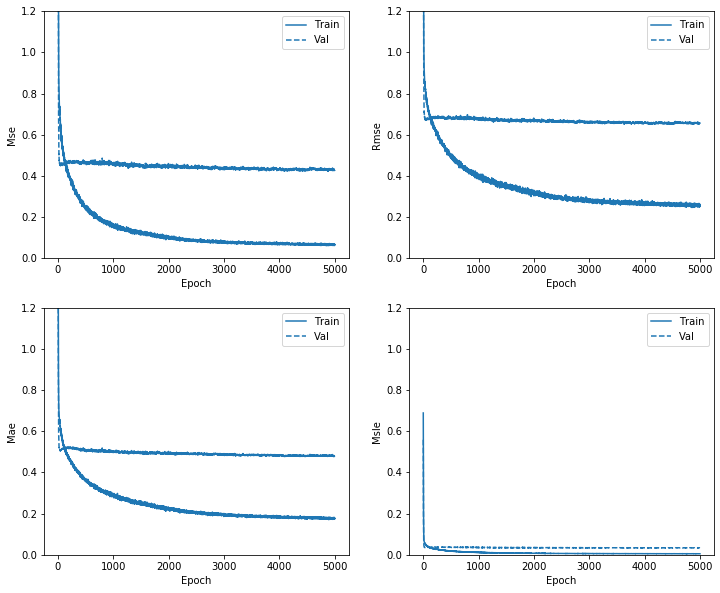

In [15]:
plot_metrics(baseline_history)

In [16]:
#这里考虑不加载验证集最好的时候试试！！！

model.load_weights(BAOCUNNAME)

In [16]:
model

In [17]:
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对误差
from sklearn.metrics import r2_score#R square

pred_test_value = model.predict(X_test)
Finally_MAE = mean_absolute_error(Y_test,pred_test_value)
Finnaly_MSE = mean_squared_error(Y_test,pred_test_value)
r2_score = r2_score(Y_test, pred_test_value)
print(Finally_MAE)
print(Finnaly_MSE)
print(r2_score)

0.48484926126651157
0.44432978642446247
0.5035736119461391


In [18]:
model.load_weights(BAOCUNNAME)
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对误差
from sklearn.metrics import r2_score#R square

pred_test_value = model.predict(X_test)
Finally_MAE = mean_absolute_error(Y_test,pred_test_value)
Finnaly_MSE = mean_squared_error(Y_test,pred_test_value)
r2_score = r2_score(Y_test, pred_test_value)
print(Finally_MAE)
print(Finnaly_MSE)
print(r2_score)

0.4850809532874192
0.4464290037776722
0.5012282663937291


In [18]:
print(Finally_MAE)

0.4754855933417682


In [19]:
print(Finnaly_MSE)

0.4175802288372886


In [20]:
r2_score = r2_score(Y_test, pred_test_value)
r2_score

0.5334594909953416